### ``The Social Equity Impact on Employee Attrition``

``Author: Mijail Q. Mariano``


----

In [1]:
# notebook dependencies
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 300

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# importing key libraries
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

# numpy import
import numpy as np
import random

# importing acquire module
import acquire
import prepare

# importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

# file cleaning modules
from skimpy import clean_columns

# stats/math modules
import scipy.stats as stats

# sklearn data science library
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.inspection import permutation_importance

# modules used in modeling
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE, RFECV, f_regression, chi2

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer

# reporting
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

### **<u>``Project Description``</u>**

Through this analysis, I attempt to understand how county-level social-mobility* metrics can impact company-employee attrition.

I use socioeconomic data from Harvard University's "Opportunity Atlas" platform which tracks anonymized metrics of social-mobility of children born in the years from 1978 - 1983 through adulthood.

I combine these metrics of social-mobility with an employee dataset of a medium-sized business originally created by IBM's AI "Watson" to help investigate potential drivers of employee attrition.

***
*Socioeconomic Mobility in the United States can refer to the upward or downward movement of American subgroups or classes from one particular social class or economic attainment to another. Although this metric can be measured for all subgroups, it is typically cited when studying historically marginalized communities or subgroups, and the barriers they overcome to obtain equal opportunities.*


*Socioeconomic mobility can be examined and measured through certain social factors such as employment/leadership opportunities, marriage, social networks, access to education, innovation, illegal activities, access to health care, or monetary wealth.*

For readability-ease I chose to use the terms 'social-mobility' and 'socioeconomic' interchangeably throughout the analysis.*

***

**<u>Exploration Questions:</u>**

1. How does an employee's geographical background such as where they live or grow up impact their decision to remain or leave their company?

2. Can socioeconomic data help to model true employee turn-over (sensitivity) better than a baseline prediction model?

3. What are the socioeconomic demographic differences between employees who leave the company and those who stay?

3. How can organizations think about employee attrition in the context of local-counties social-mobility?


#### **<u>``Project Assumptions``</u>**

I make several assumptions throughout the analysis. Here are some of the key underlying assumptions that should be considered when interpreting its findings.

**``Employee Attrition``**

Employee attrition can typically be categorized into two (2) broad-ranging measures, which are "voluntary" and "involuntary" attrition. Though not recorded in the IBM dataset, I ultimately made the decision to classify "attrition" in the data as voluntary resignation. This means that any employee recorded as having left the company made this decision without any influence of the business.

**``Geographical Assignment``**

I make the assumption that the employee data is from a mid-sized business in the United States, specifically the New York City, NY area. I also assume that its employees live or are from counties within a 30 mile commute radius of this business. 

Due to random county assignment for all employees, the analysis does not determine the directionality of socioeconomic impact on attrition. This is due to the uncertainty around employees' exact home-of-record locations and how other variables such as an employee's age, company tenure, and ultimately their decision to remain or leave the company are directly impacted by their county's social-mobility metrics.

-----

### **``Data Acquisition & Preparation``**

**<u>``Highlights:``</u>**

- Initial dataset: 1470 Unique Records & 46 Unique Features
- Initital dataset cleaning: 1230 Records & 34 Features
- Six (6) unique social-mobility features used in analysis
- Company-Employee Attrition: ~17.6% 
- Predicted Baseline Accuracy: ~82.4 (mode_method)
- Baseline "True-Positive" Rate: 0% (mode_method)

In [2]:
# acquiring dataset for analysis

df = acquire.get_employee_df()
df.head()

initial df shape: (1470, 47)


Unnamed: 0 Attrition  EmployeeNumber  Age     BusinessTravel  DailyRate  \
0           0       Yes               1   41      Travel_Rarely       1102   
1           1        No               2   49  Travel_Frequently        279   
2           2       Yes               4   37      Travel_Rarely       1373   
3           3        No               5   33  Travel_Frequently       1392   
4           4        No               7   27      Travel_Rarely        591   

               Department  DistanceFromHome  Education EducationField  ...  \
0                   Sales                 1          2  Life Sciences  ...   
1  Research & Development                 8          1  Life Sciences  ...   
2  Research & Development                 2          2          Other  ...   
3  Research & Development                 3          4  Life Sciences  ...   
4  Research & Development                 2          1        Medical  ...   

   state       cty household_income_at_35  high-school_graduation_rate  \
0     NY  cty36047                  37229                       0.8375   
1     NY  cty36005                  32542                       0.7783   
2     NY  cty36047                  37229                       0.8375   
3     NY  cty36047                  37229                       0.8375   
4     NY  cty36047                  37229                       0.8375   

   percentage_married_by_35  incarceration_rate women_teenage_birthrate  \
0                    0.3201              0.0138                  0.1956   
1                    0.2223              0.0163                  0.2765   
2                    0.3201              0.0138                  0.1956   
3                    0.3201              0.0138                  0.1956   
4                    0.3201              0.0138                  0.1956   

   poverty_rate employment_rates_at_35  single_parent_frac  
0        0.2291                 0.7317              0.3806  
1        0.3055                 0.7417              0.5914  
2        0.2291                 0.7317              0.3806  
3        0.2291                 0.7317              0.3806  
4        0.2291                 0.7317              0.3806  

[5 rows x 47 columns]

In [3]:
# initial df cleaning

df = prepare.clean_employee_df(df)
df.head() # 12 features/columns removed

37 column names have been cleaned

shape after cleaning: (1470, 34)


attrition  employee_age  monthly_income  percent_salary_hike  \
1       True            41            5993                   11   
2      False            49            5130                   23   
4       True            37            2090                   15   
5      False            33            2909                   11   
7      False            27            3468                   12   

   total_working_years  training_times_last_year  years_at_company  \
1                    8                         0                 6   
2                   10                         3                10   
4                    7                         3                 0   
5                    8                         3                 8   
7                    6                         3                 2   

   household_income_at_35  high_school_graduation_rate  \
1                   37229                       0.8375   
2                   32542                       0.7783   
4                   37229                       0.8375   
5                   37229                       0.8375   
7                   37229                       0.8375   

   percentage_married_by_35  ...               job_role  job_satisfaction  \
1                    0.3201  ...        Sales Executive                 4   
2                    0.2223  ...     Research Scientist                 2   
4                    0.3201  ...  Laboratory Technician                 3   
5                    0.3201  ...     Research Scientist                 3   
7                    0.3201  ...  Laboratory Technician                 2   

   marital_status  performance_rating  relationship_satisfaction  state  \
1          Single                   3                          1     NY   
2         Married                   4                          4     NY   
4          Single                   3                          2     NY   
5         Married                   3                          3     NY   
7         Married                   3                          4     NY   

  stock_option_level work_life_balance years_in_current_role  \
1                  0                 1                     4   
2                  1                 3                     7   
4                  0                 3                     0   
5                  0                 3                     7   
7                  1                 3                     2   

  years_with_curr_manager  
1                       5  
2                       7  
4                       0  
5                       0  
7                       2  

[5 rows x 34 columns]

In [4]:
# returning summary of lower/upperbounds outlier dataframe

prepare.get_lower_and_upper_bounds(df).sort_values(by="upper_outliers", ascending=False).reset_index(drop = True)

dataframe shape: (17, 7)


column column type        iqr  lower_bound  \
0      training_times_last_year       int64     1.0000       0.5000   
1                monthly_income       int64  5468.0000   -5291.0000   
2    years_since_last_promotion       int64     3.0000      -4.5000   
3              years_at_company       int64     6.0000      -6.0000   
4           total_working_years       int64     9.0000      -7.5000   
5         years_in_current_role       int64     5.0000      -5.5000   
6       years_with_curr_manager       int64     5.0000      -5.5000   
7                  poverty_rate     float64     0.1970      -0.1870   
8            single_parent_frac     float64     0.2650      -0.0711   
9        employment_rates_at_35     float64     0.0708       0.6255   
10                 employee_age       int64    13.0000      10.5000   
11      women_teenage_birthrate     float64     0.1495      -0.0973   
12           incarceration_rate     float64     0.0055       0.0026   
13  high_school_graduation_rate     float64     0.1357       0.5747   
14       household_income_at_35       int64 19231.0000    3695.5000   
15          percent_salary_hike       int64     6.0000       3.0000   
16     percentage_married_by_35     float64     0.2009      -0.0790   

    lower_outliers  upper_bound  upper_outliers  
0               54       4.5000             184  
1                0   16581.0000             114  
2                0       7.5000             107  
3                0      18.0000             104  
4                0      28.5000              63  
5                0      14.5000              21  
6                0      14.5000              14  
7                0       0.6010               0  
8                0       0.9889               0  
9                0       0.9087               0  
10               0      62.5000               0  
11               0       0.5008               0  
12               0       0.0245               0  
13               0       1.1176               0  
14               0   80619.5000               0  
15               0      27.0000               0  
16               0       0.7246               0

In [5]:
# treating dataset for upperbound outliers w/1.5 fence

df = prepare.df_outliers(df)
df.head() # 240 records removed or ~16% of original df

shape after outliers: (1230, 34)


attrition  employee_age  monthly_income  percent_salary_hike  \
1       True            41            5993                   11   
2      False            49            5130                   23   
4       True            37            2090                   15   
5      False            33            2909                   11   
7      False            27            3468                   12   

   total_working_years  training_times_last_year  years_at_company  \
1                    8                         0                 6   
2                   10                         3                10   
4                    7                         3                 0   
5                    8                         3                 8   
7                    6                         3                 2   

   household_income_at_35  high_school_graduation_rate  \
1                   37229                       0.8375   
2                   32542                       0.7783   
4                   37229                       0.8375   
5                   37229                       0.8375   
7                   37229                       0.8375   

   percentage_married_by_35  ...               job_role  job_satisfaction  \
1                    0.3201  ...        Sales Executive                 4   
2                    0.2223  ...     Research Scientist                 2   
4                    0.3201  ...  Laboratory Technician                 3   
5                    0.3201  ...     Research Scientist                 3   
7                    0.3201  ...  Laboratory Technician                 2   

   marital_status  performance_rating  relationship_satisfaction  state  \
1          Single                   3                          1     NY   
2         Married                   4                          4     NY   
4          Single                   3                          2     NY   
5         Married                   3                          3     NY   
7         Married                   3                          4     NY   

  stock_option_level work_life_balance years_in_current_role  \
1                  0                 1                     4   
2                  1                 3                     7   
4                  0                 3                     0   
5                  0                 3                     7   
7                  1                 3                     2   

  years_with_curr_manager  
1                       5  
2                       7  
4                       0  
5                       0  
7                       2  

[5 rows x 34 columns]

#### **``Outlier Observations``**

**Since the socioeconomic/opportunity atlas data represents the only 'real' figures in the dataset, I intetionally choose to leave outliers in the dataset for testing and evaluating against attrition.**

<u>Ater applying an interquartile range with k value (fence) of 1.5, I will apply/ommit the following outlier cleaning:</u>

**monthly_income:** upperbound $16581.00

- this signals to me that these employees are either contractors or senior leaders at the company. If they are senior leaders, my assumption is that they are more reluctant to make an employment change due to their potential leadership responsibilities, role, and stated salary. 

**year_since_last_promotion:** upperbound 7.50 years

- this signals to me that these employees may already be seeking other opportunities elsewhere - potentially with an employer that is willing to offer them a better position with greater responsibilities, and salary. I will ommit employees over the dataset upperbound.

**years_at_company:** upperbound 18.00 years

- this signals to me that these employees may be reluctant to leave their current employer given the length of their tenure. Additionally, the current median employee tenure in the US is ~5 years, I will ommit employees over this upperbound.

**total_working_years:** upperbound 28.50 year

- similar to above, these employees may also be enroute to retirement or are simply less willing to make a career/employment shift given this late into their careers. Additionally, they might have also learned ways in which they can successfully navigate the socioeconomic challenges apparent in their communities. I will ommit employees over this upperbound.

**years_in_current_role:** upperbound 14.50 years

- given the median US employee/employer tenure, I assume that these employees 1. may already be seeking other opportunities or 2. are comfortable in their current roles and thefore are less willing to take socioeconomic factors as reason to leave their company. 

**years_with_curr_manager:** upperbound 14.50 years

- same as above, yet there could also be a relationship factor thats prevelant in the employees' tenure. Employees may have a good working relationship with their managers where they potentially feel "heard" and are having their socioeconomic concerns addressed. I will ommit employees over this upperbound.

----

``References:``

- https://www.bls.gov/news.release/tenure.nr0.htm


In [6]:
# examining the df and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230 entries, 1 to 2068
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   attrition                    1230 non-null   bool   
 1   employee_age                 1230 non-null   int64  
 2   monthly_income               1230 non-null   int64  
 3   percent_salary_hike          1230 non-null   int64  
 4   total_working_years          1230 non-null   int64  
 5   training_times_last_year     1230 non-null   int64  
 6   years_at_company             1230 non-null   int64  
 7   household_income_at_35       1230 non-null   int64  
 8   high_school_graduation_rate  1230 non-null   float64
 9   percentage_married_by_35     1230 non-null   float64
 10  incarceration_rate           1230 non-null   float64
 11  women_teenage_birthrate      1230 non-null   float64
 12  poverty_rate                 1230 non-null   float64
 13  employment_rates_a

In [7]:
# summary statistics

summary_stats = df.describe().T
summary_stats["range"] = summary_stats["max"] - summary_stats["min"]
summary_stats.sort_index()

count       mean        std        min  \
employee_age                1230.0000    35.2780     8.5203    18.0000   
employment_rates_at_35      1230.0000     0.7557     0.0309     0.7317   
high_school_graduation_rate 1230.0000     0.8496     0.0591     0.7783   
household_income_at_35      1230.0000 42578.3228 11464.2434 32542.0000   
incarceration_rate          1230.0000     0.0121     0.0047     0.0029   
monthly_income              1230.0000  5086.4715  2933.3684  1009.0000   
percent_salary_hike         1230.0000    15.2699     3.6037    11.0000   
percentage_married_by_35    1230.0000     0.3413     0.1011     0.2223   
poverty_rate                1230.0000     0.2068     0.0857     0.0748   
single_parent_frac          1230.0000     0.3970     0.1359     0.2005   
total_working_years         1230.0000     8.8837     5.2022     0.0000   
training_times_last_year    1230.0000     2.8122     1.3039     0.0000   
women_teenage_birthrate     1230.0000     0.1804     0.0815     0.0410   
years_at_company            1230.0000     5.3683     3.7118     0.0000   
years_in_current_role       1230.0000     3.5642     3.0593     0.0000   
years_since_last_promotion  1230.0000     1.3992     1.9562     0.0000   
years_with_curr_manager     1230.0000     3.4943     3.0557     0.0000   

                                   25%        50%        75%        max  \
employee_age                   29.0000    34.0000    40.0000    60.0000   
employment_rates_at_35          0.7317     0.7417     0.8025     0.8047   
high_school_graduation_rate     0.7783     0.8375     0.9140     0.9408   
household_income_at_35      32542.0000 37229.0000 51773.0000 63424.0000   
incarceration_rate              0.0108     0.0138     0.0163     0.0163   
monthly_income               2742.2500  4412.0000  6384.7500 16422.0000   
percent_salary_hike            12.0000    14.0000    18.0000    25.0000   
percentage_married_by_35        0.2223     0.3201     0.4232     0.5089   
poverty_rate                    0.1085     0.2291     0.3055     0.3055   
single_parent_frac              0.3264     0.3806     0.5914     0.5914   
total_working_years             5.0000     8.0000    11.0000    28.0000   
training_times_last_year        2.0000     3.0000     3.0000     6.0000   
women_teenage_birthrate         0.1270     0.1956     0.2765     0.2765   
years_at_company                2.0000     5.0000     8.0000    18.0000   
years_in_current_role           2.0000     2.0000     7.0000    14.0000   
years_since_last_promotion      0.0000     1.0000     2.0000     7.0000   
years_with_curr_manager         1.0000     2.0000     7.0000    13.0000   

                                 range  
employee_age                   42.0000  
employment_rates_at_35          0.0730  
high_school_graduation_rate     0.1625  
household_income_at_35      30882.0000  
incarceration_rate              0.0134  
monthly_income              15413.0000  
percent_salary_hike            14.0000  
percentage_married_by_35        0.2866  
poverty_rate                    0.2307  
single_parent_frac              0.3909  
total_working_years            28.0000  
training_times_last_year        6.0000  
women_teenage_birthrate         0.2355  
years_at_company               18.0000  
years_in_current_role          14.0000  
years_since_last_promotion      7.0000  
years_with_curr_manager        13.0000

In [8]:
# using a for loop to sample data by feature

prepare.data_samples(df)

Feature/column: attrition
Date type: bool
Missing values: False
Number of unique values: 2
Data Sample: [False, False, False, False, False, True, True]
-------------------------------------------------------------------
Feature/column: employee_age
Date type: int64
Missing values: False
Number of unique values: 43
Data Sample: [27, 32, 33, 37, 41, 49, 59]
-------------------------------------------------------------------
Feature/column: monthly_income
Date type: int64
Missing values: False
Number of unique values: 1120
Data Sample: [2090, 2670, 2909, 3068, 3468, 5130, 5993]
-------------------------------------------------------------------
Feature/column: percent_salary_hike
Date type: int64
Missing values: False
Number of unique values: 15
Data Sample: [11, 11, 12, 13, 15, 20, 23]
-------------------------------------------------------------------
Feature/column: total_working_years
Date type: int64
Missing values: False
Number of unique values: 29
Data Sample: [6, 7, 8, 8, 8, 10, 1

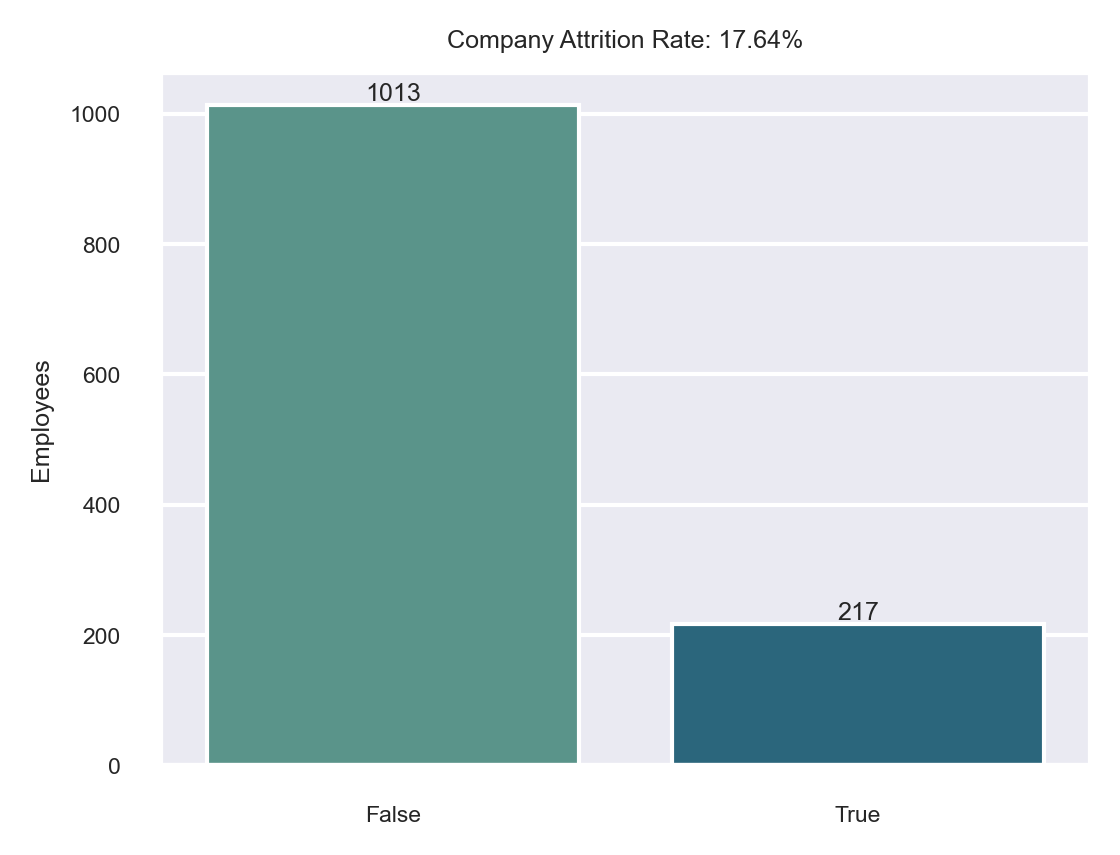

In [9]:
# let's examine the target variable after handling outliers

attrition_mean = df["attrition"].mean()

plt.figure(figsize = (4, 3))
sns.set(font_scale = 0.5)

ax = sns.countplot(
    x = "attrition",
    data = df,
    order = df["attrition"].value_counts().index,
    palette = "crest")

ax.bar_label(ax.containers[0])

plt.title(f'Company Attrition Rate: {attrition_mean:.2%}')
plt.xlabel(None)
plt.ylabel("Employees")

plt.show()

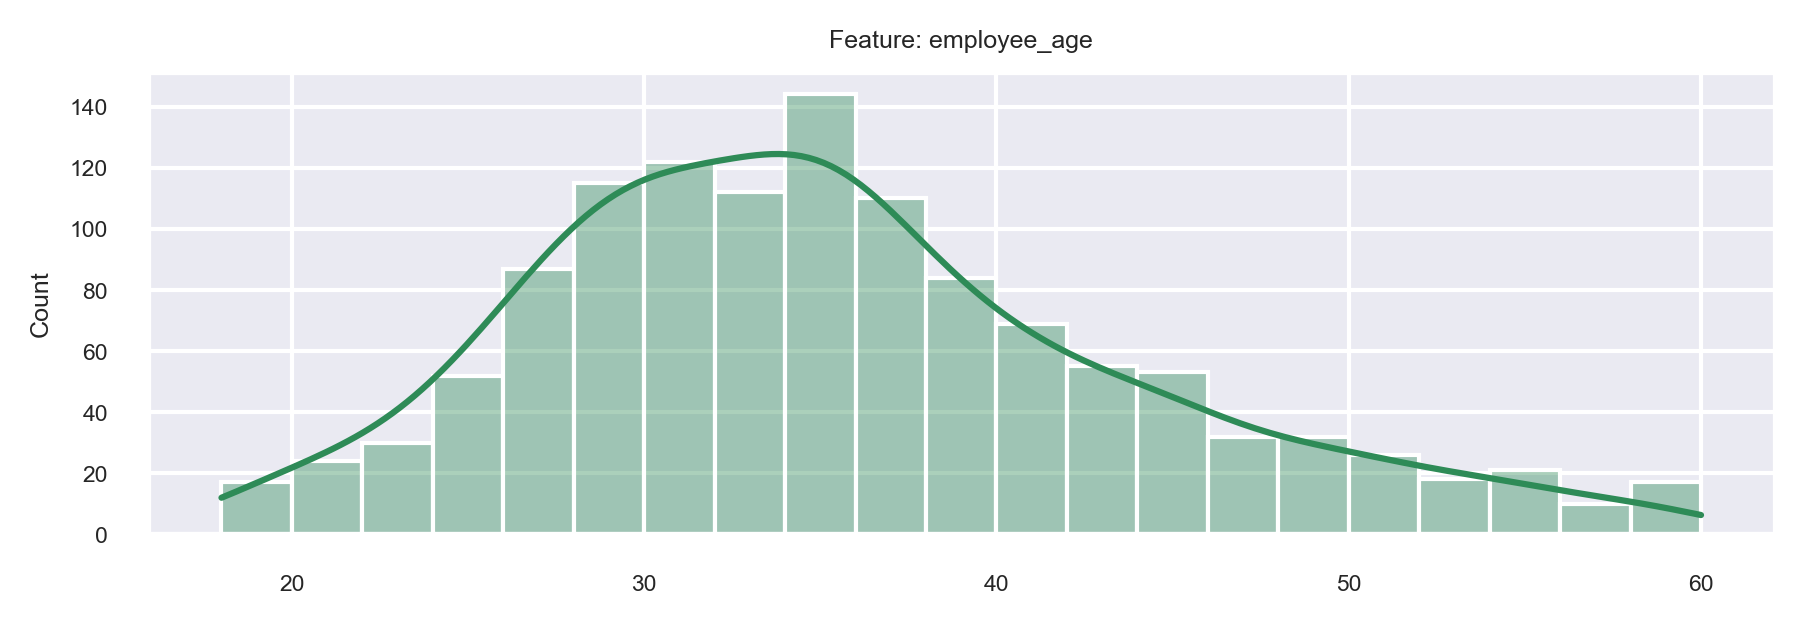

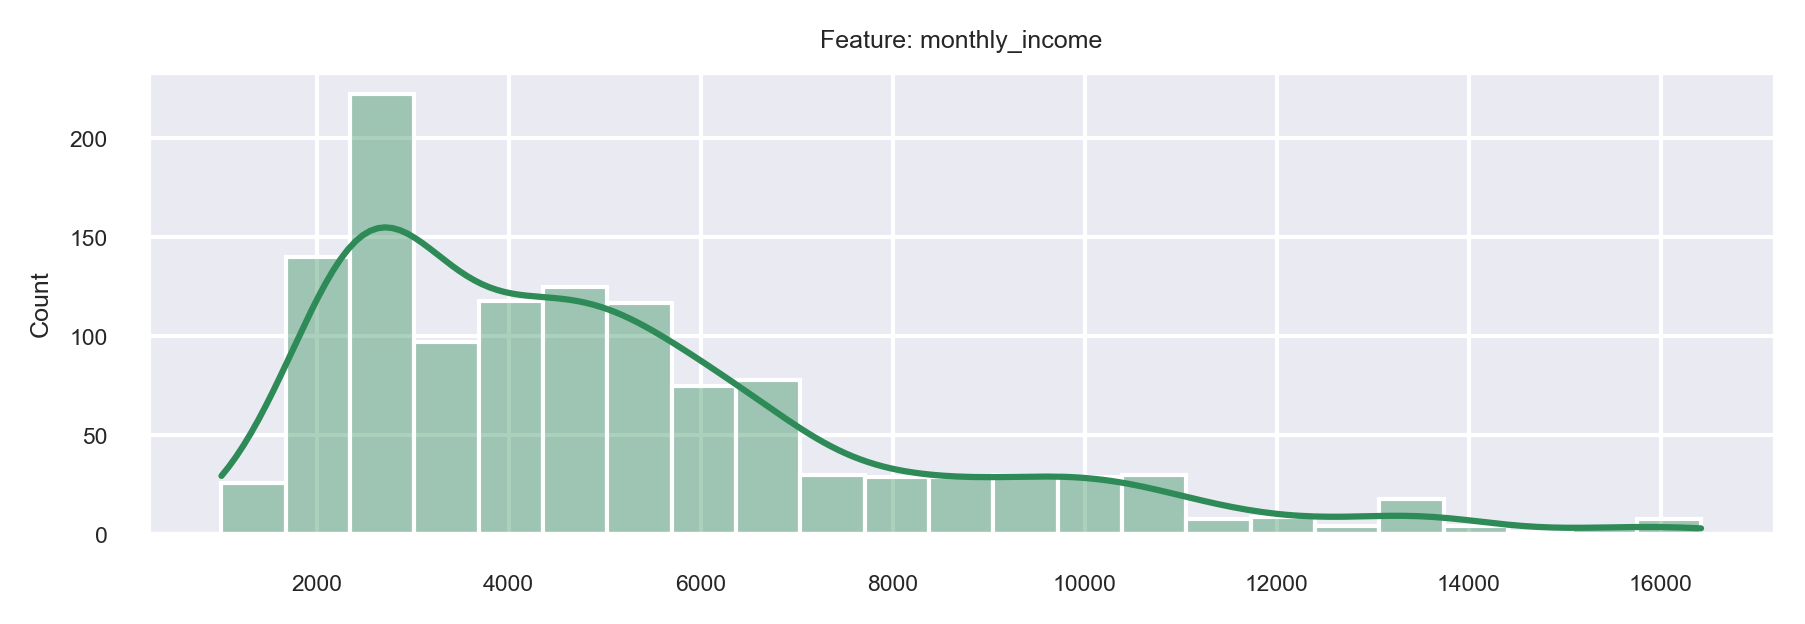

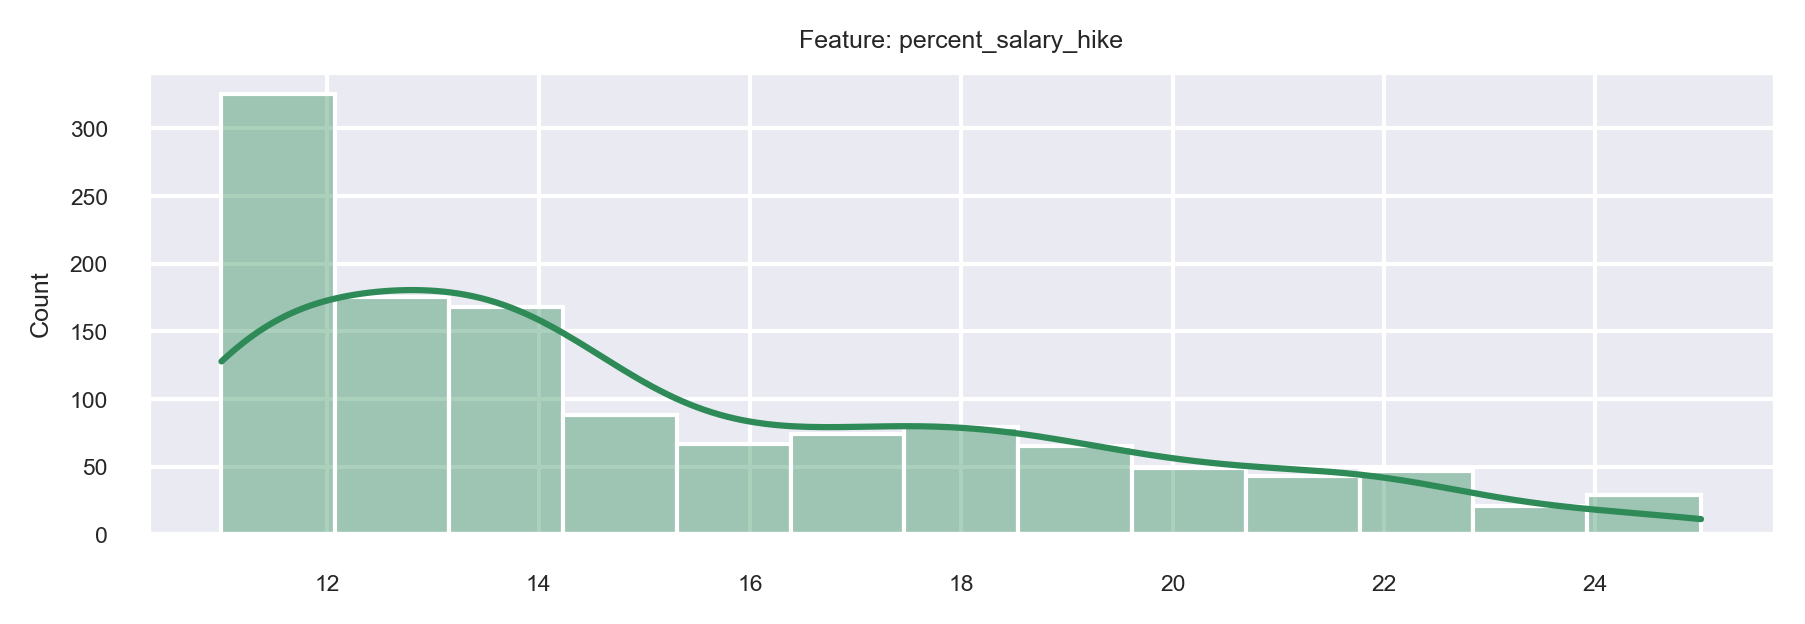

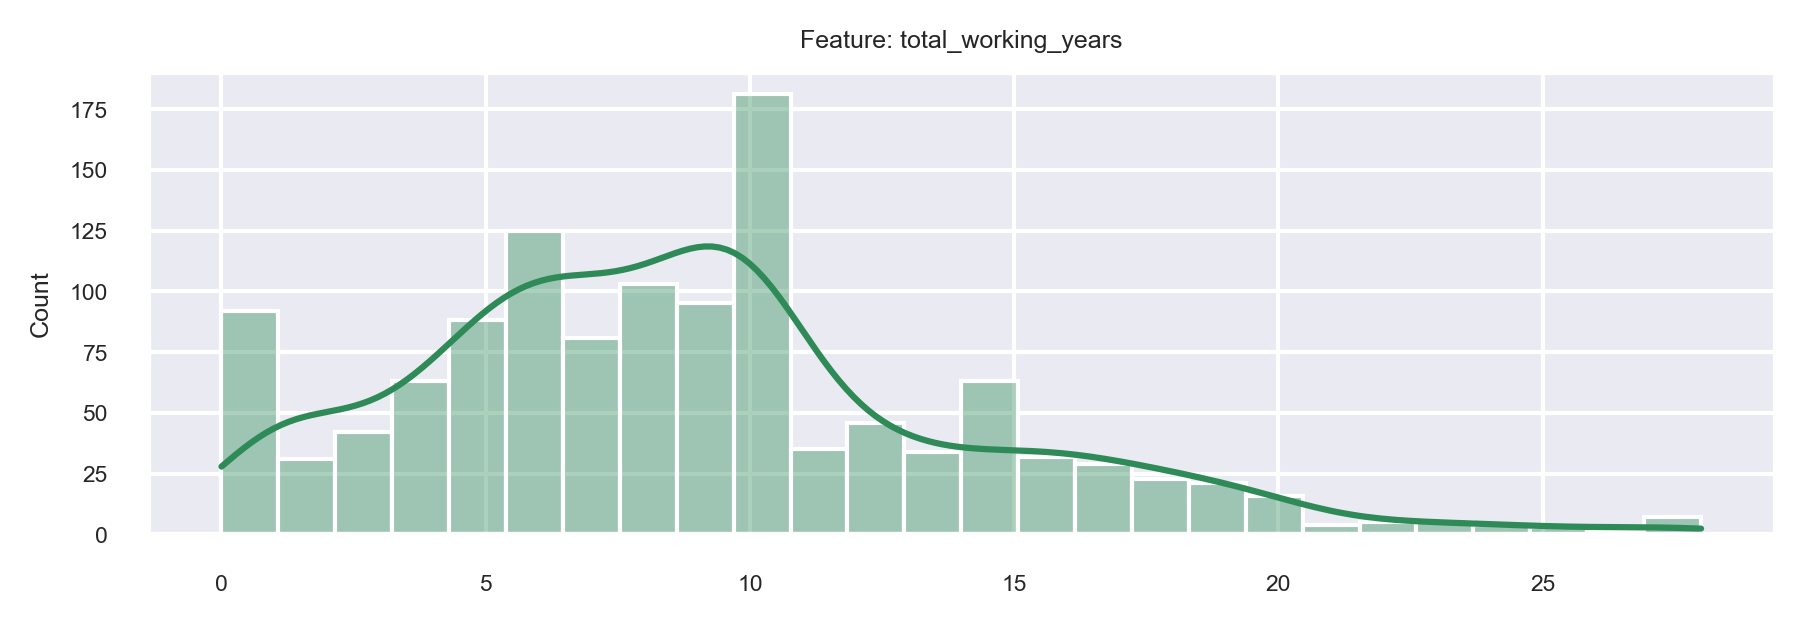

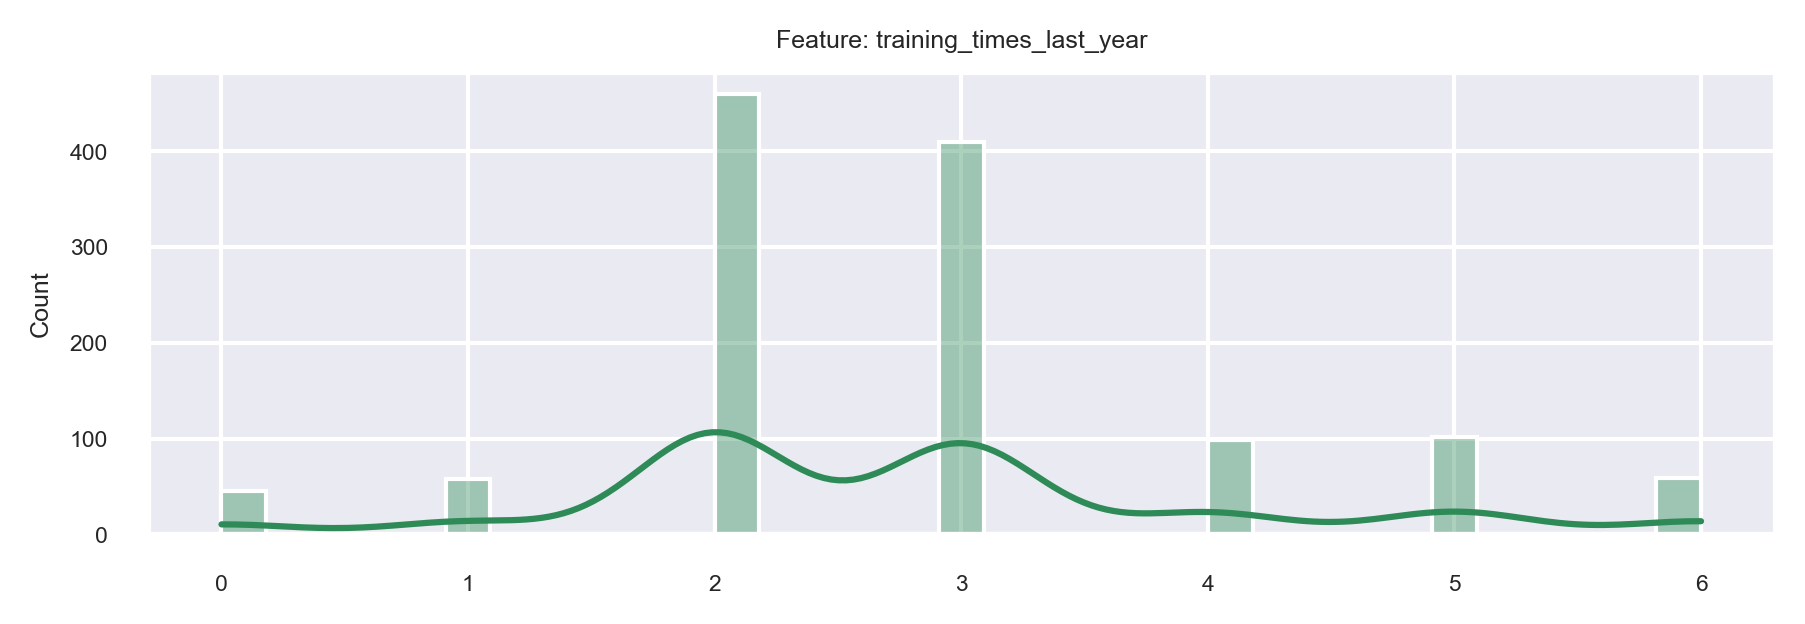

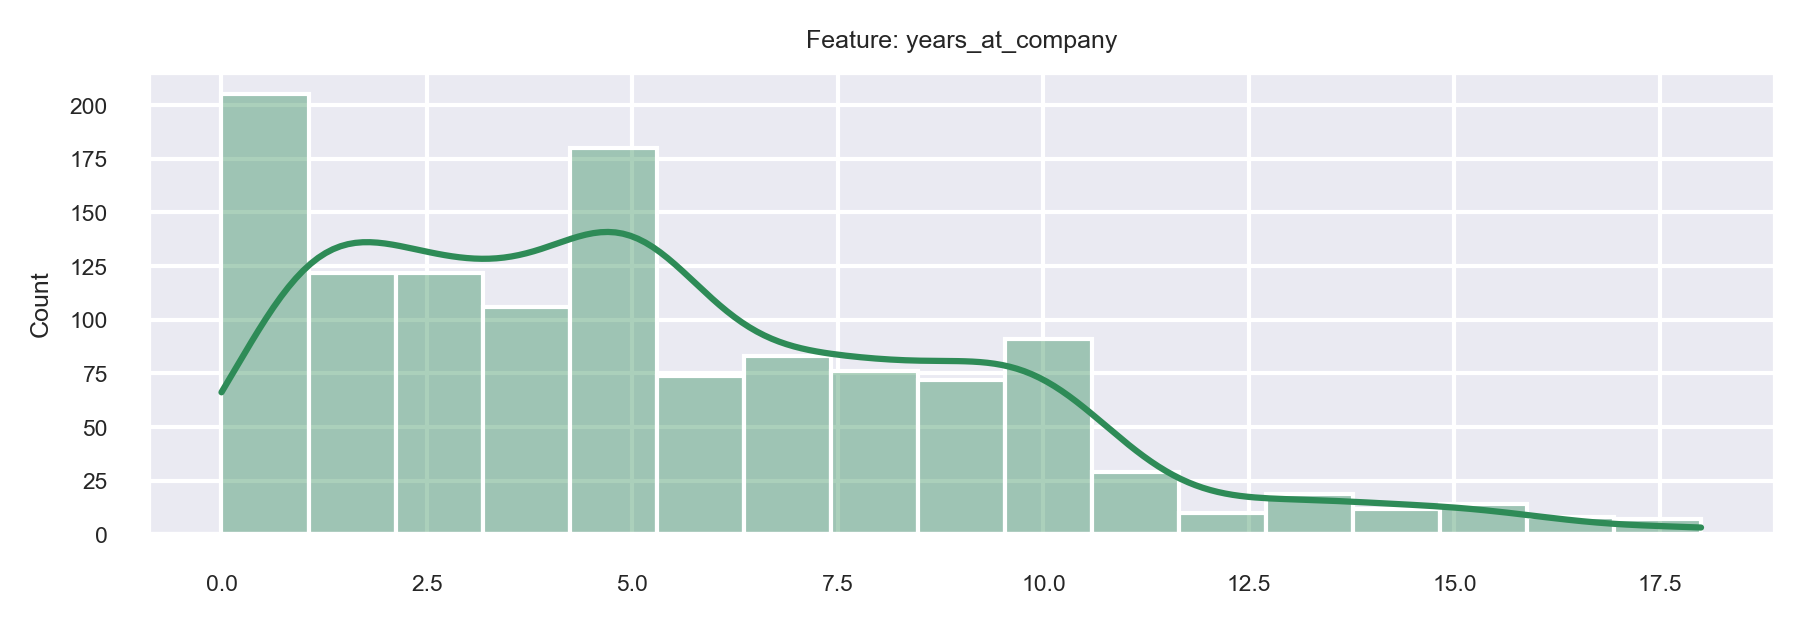

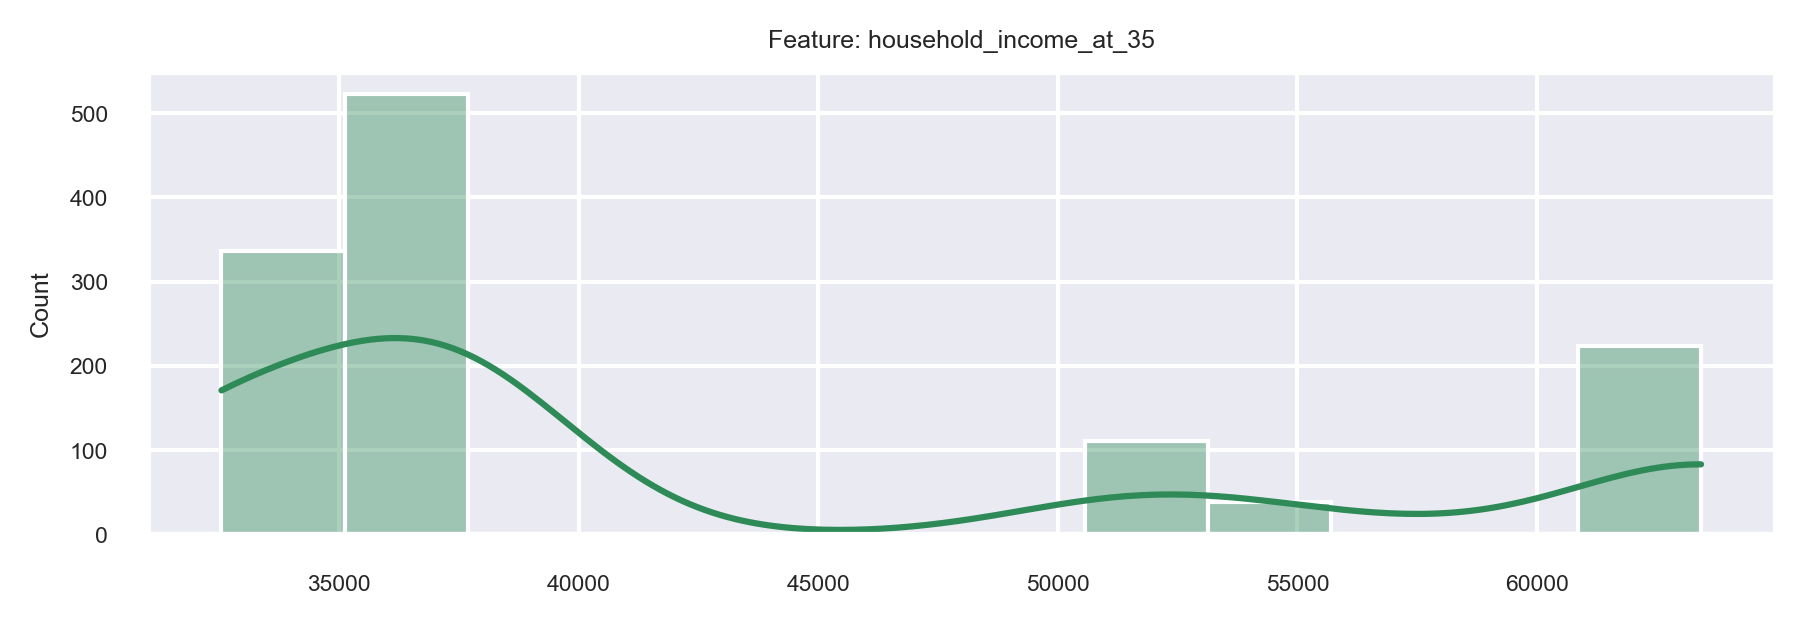

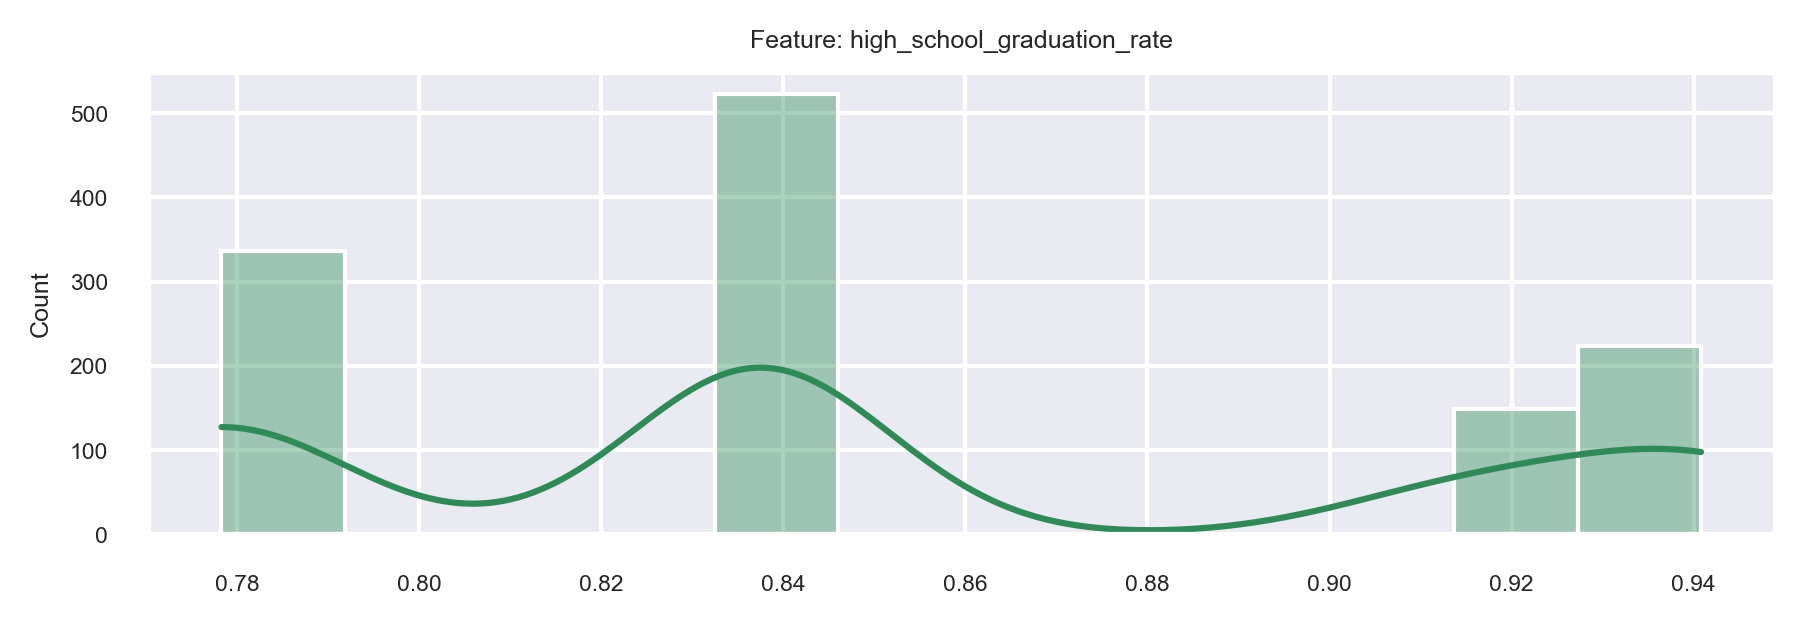

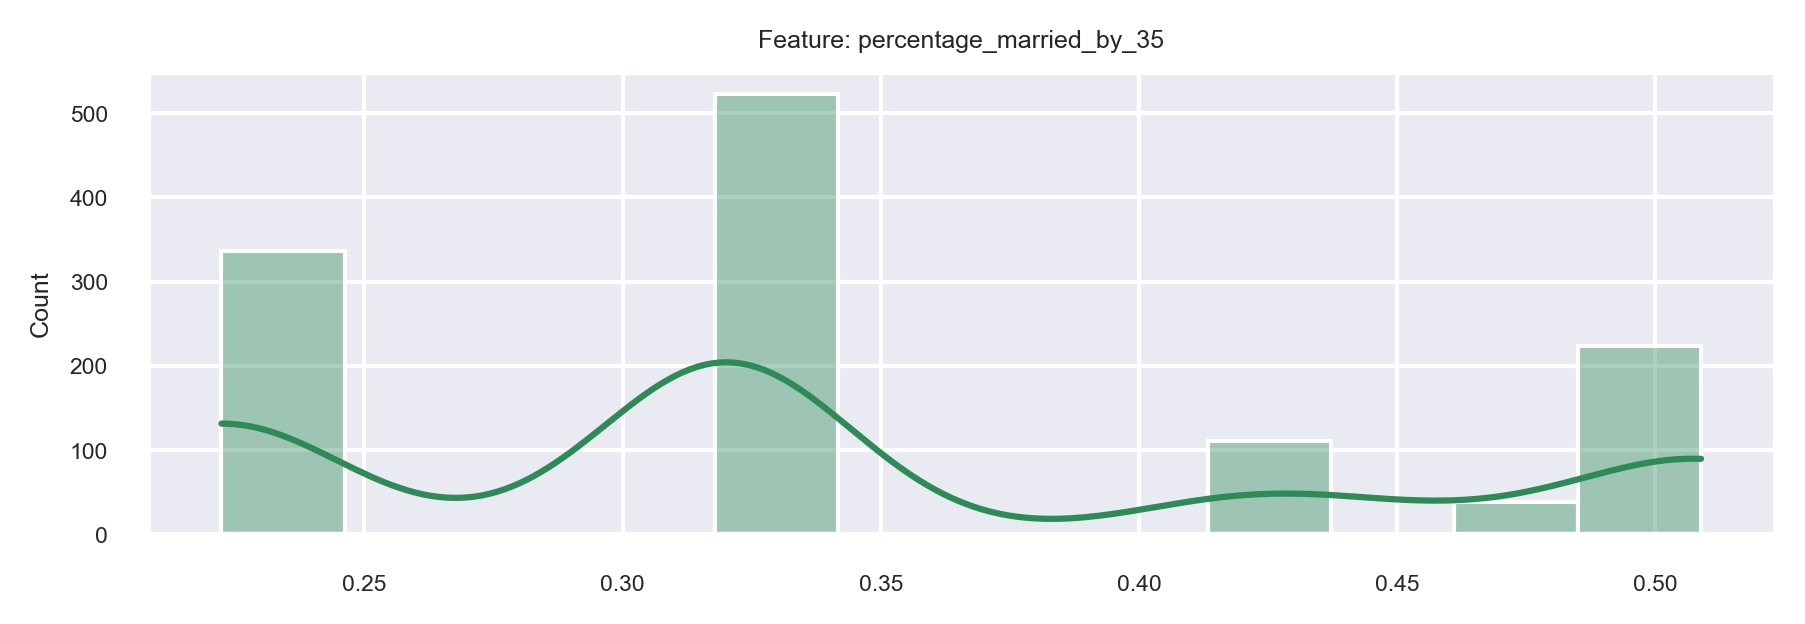

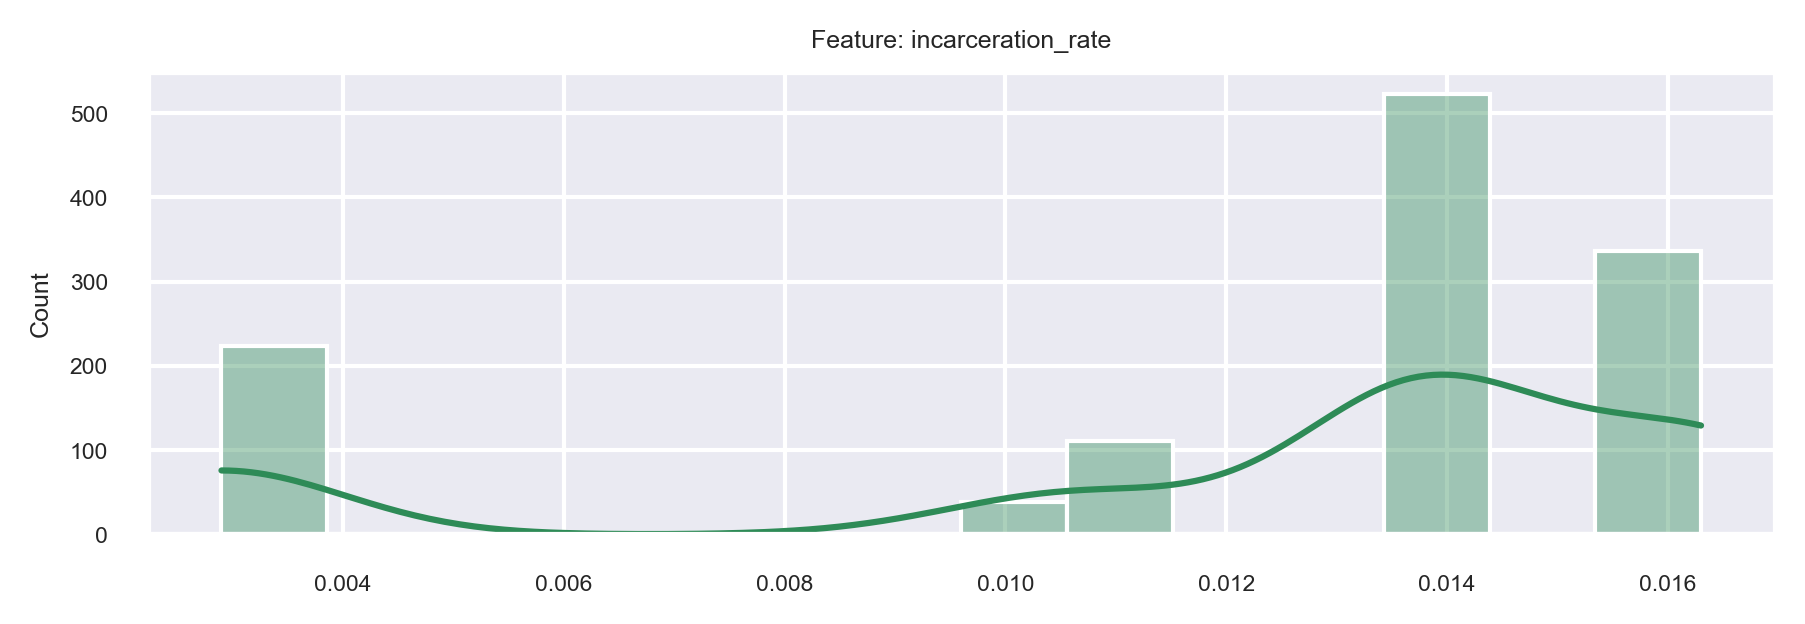

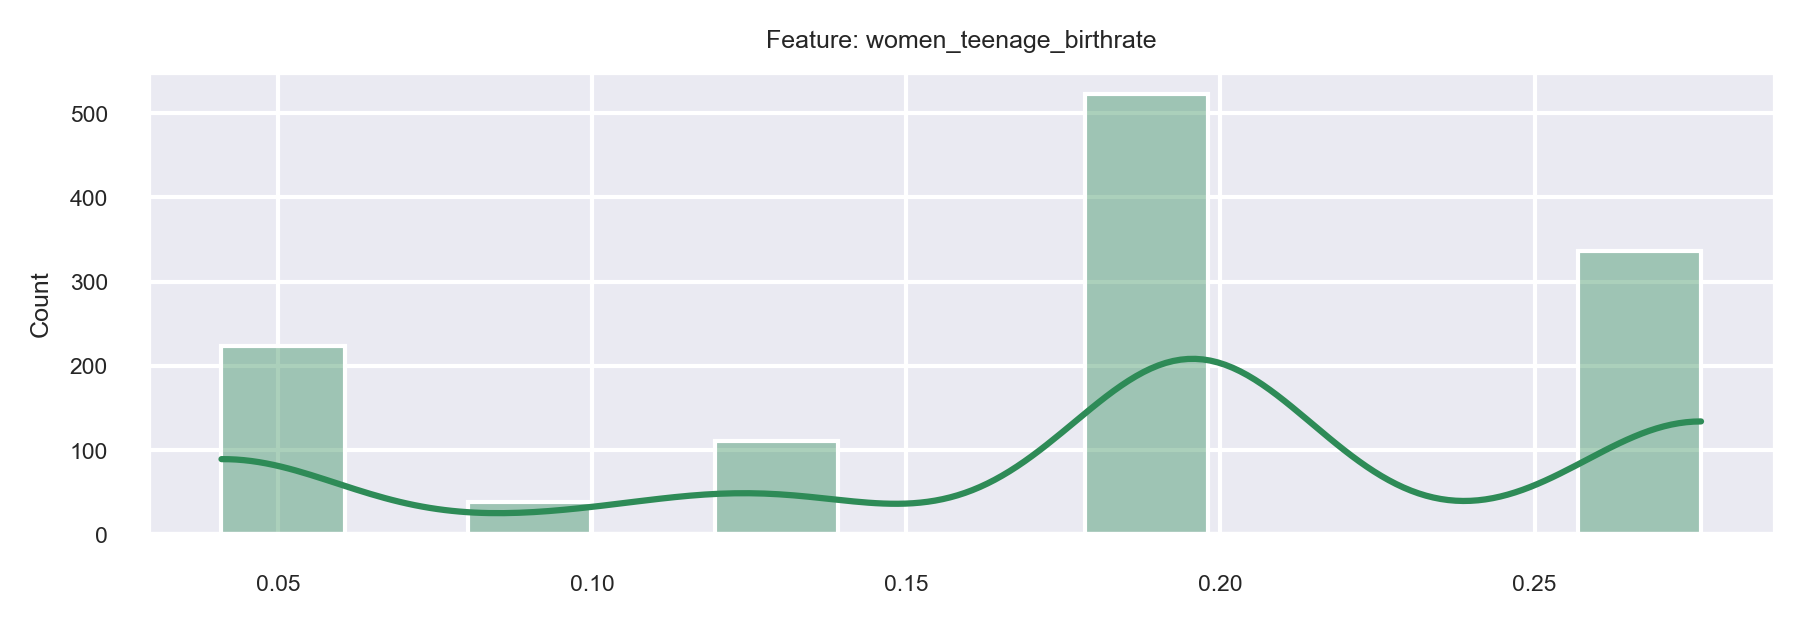

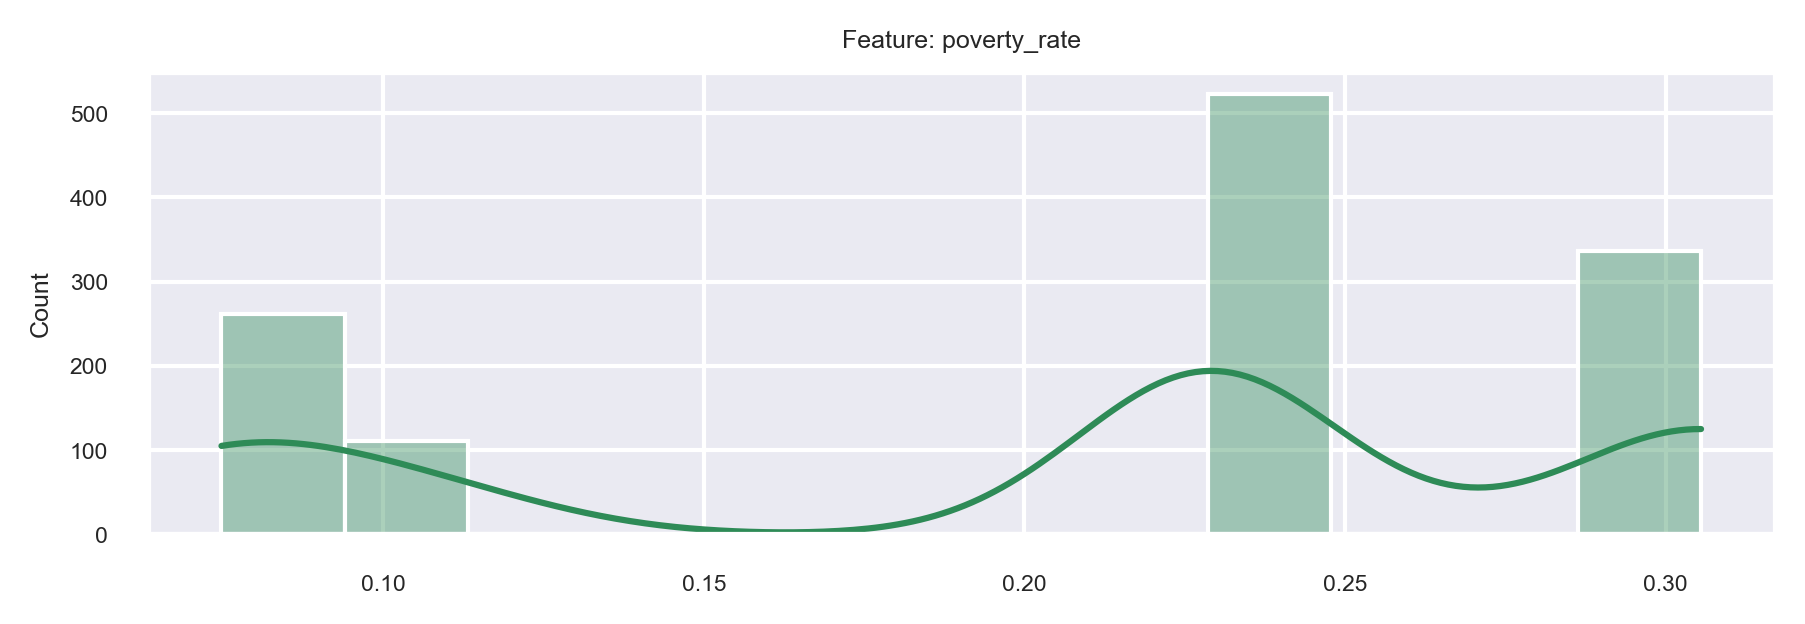

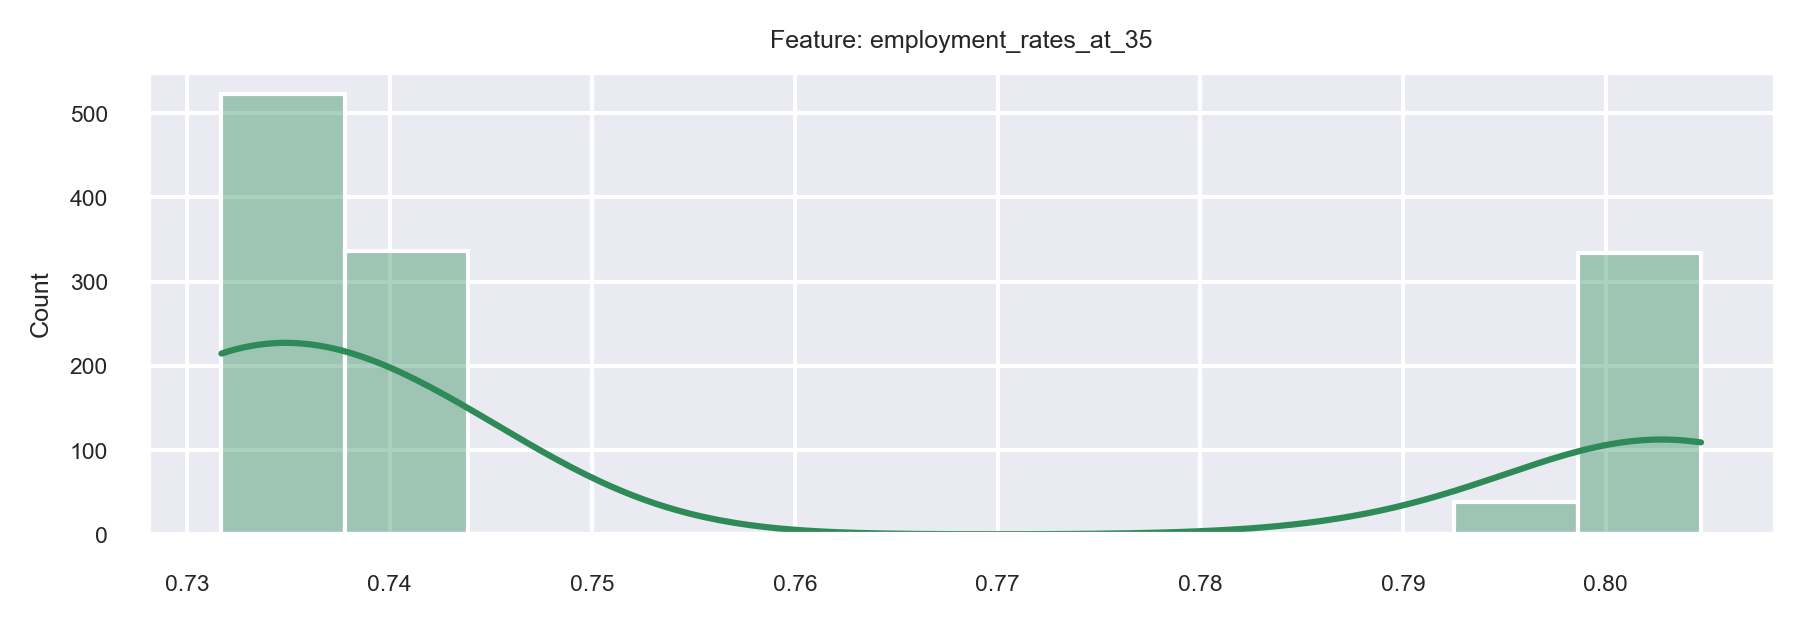

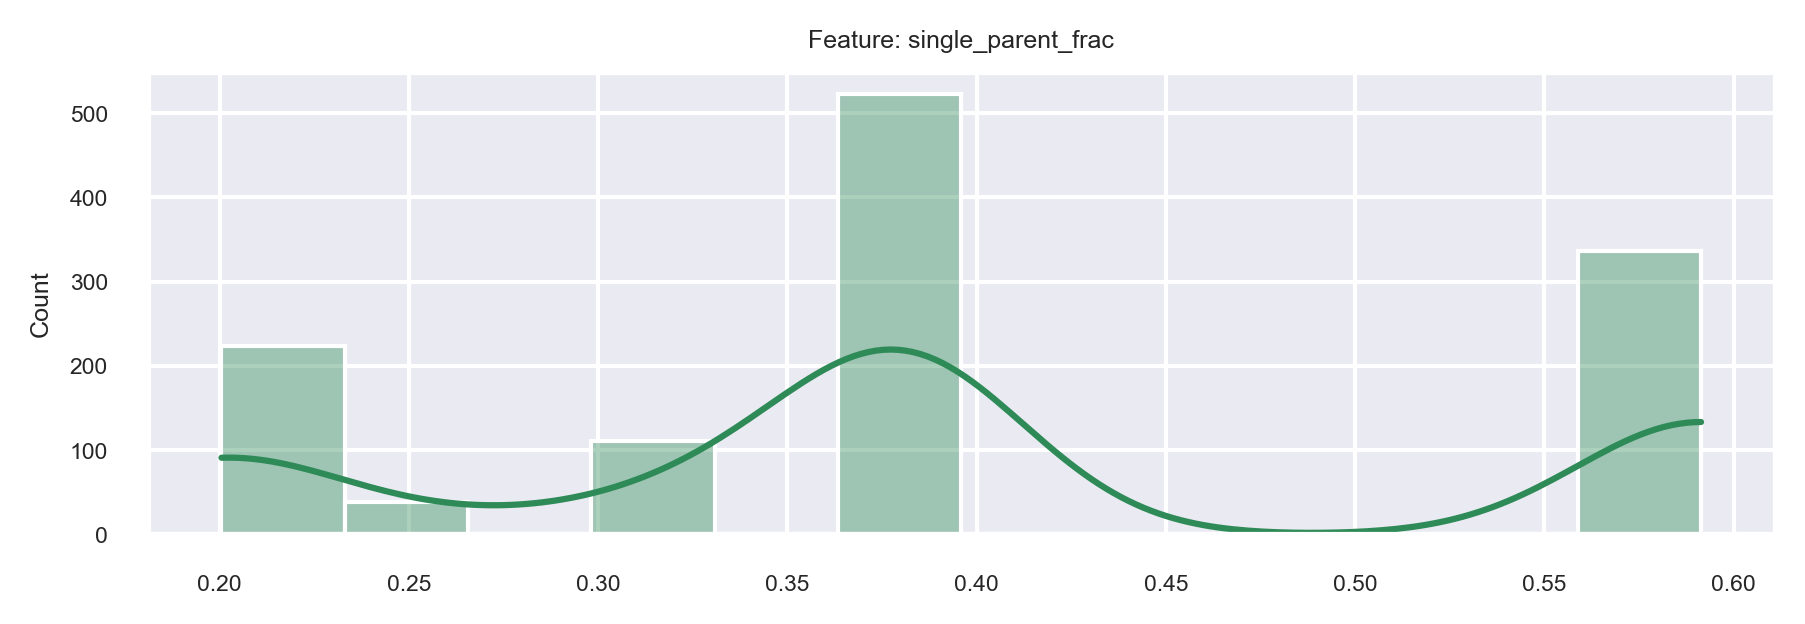

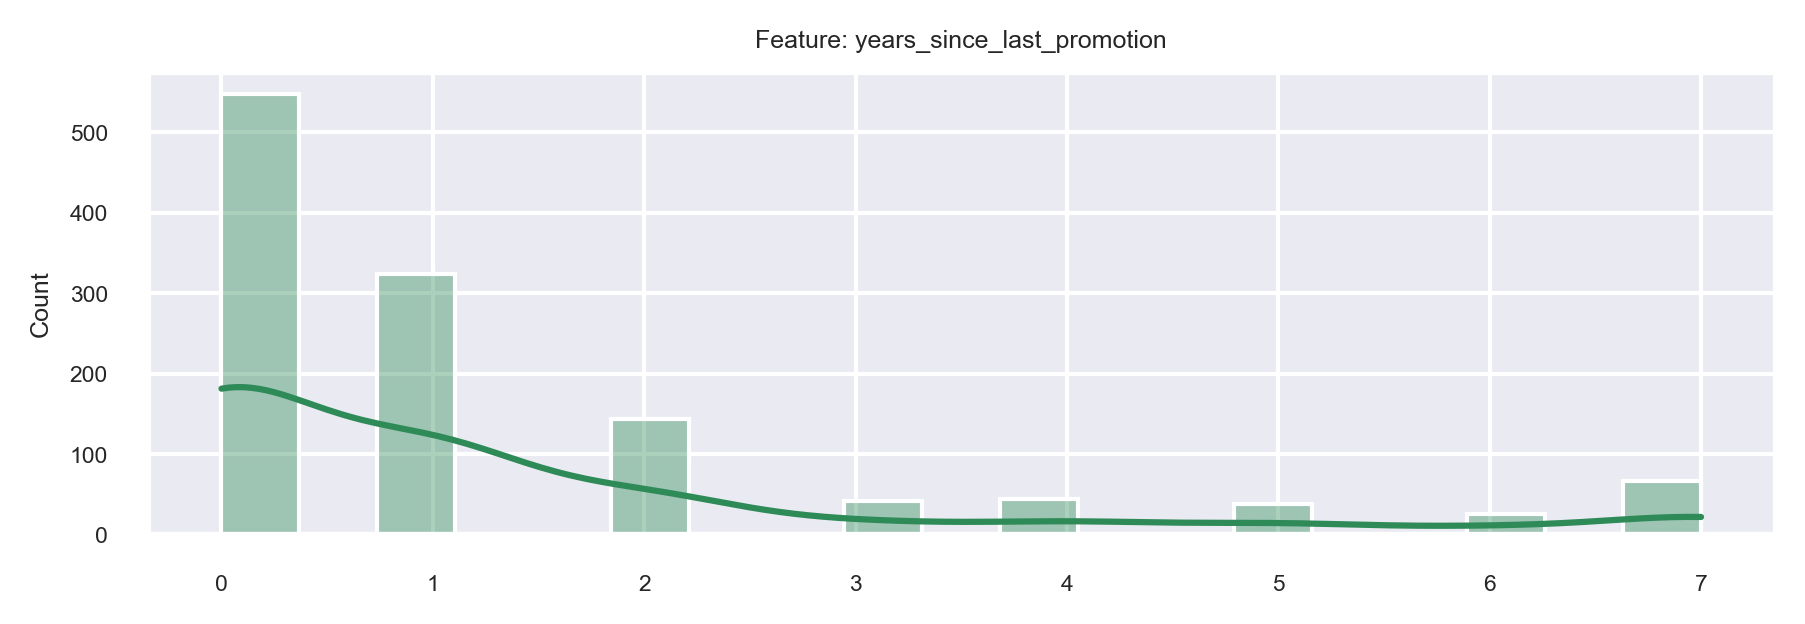

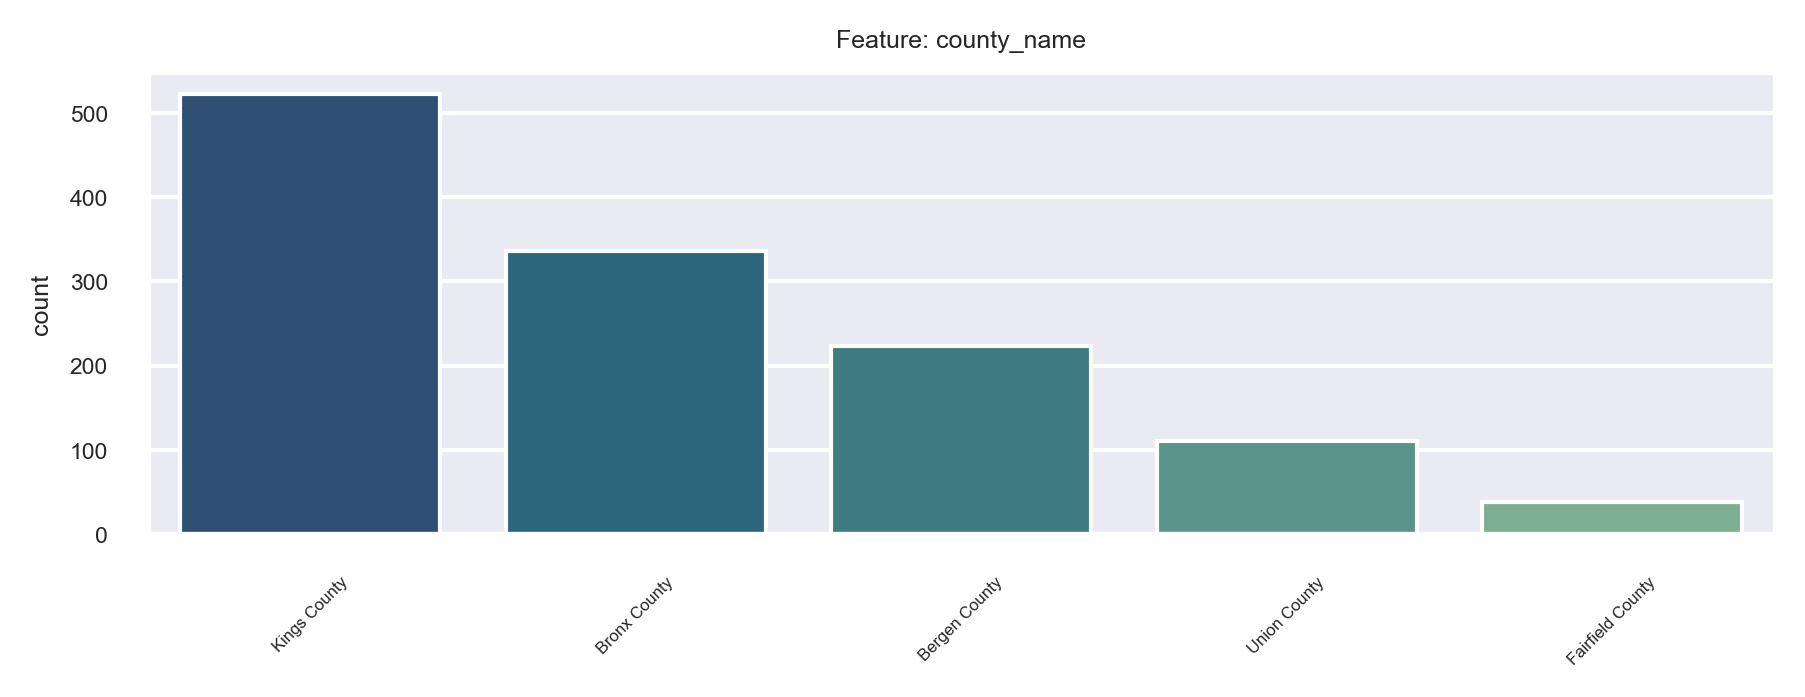

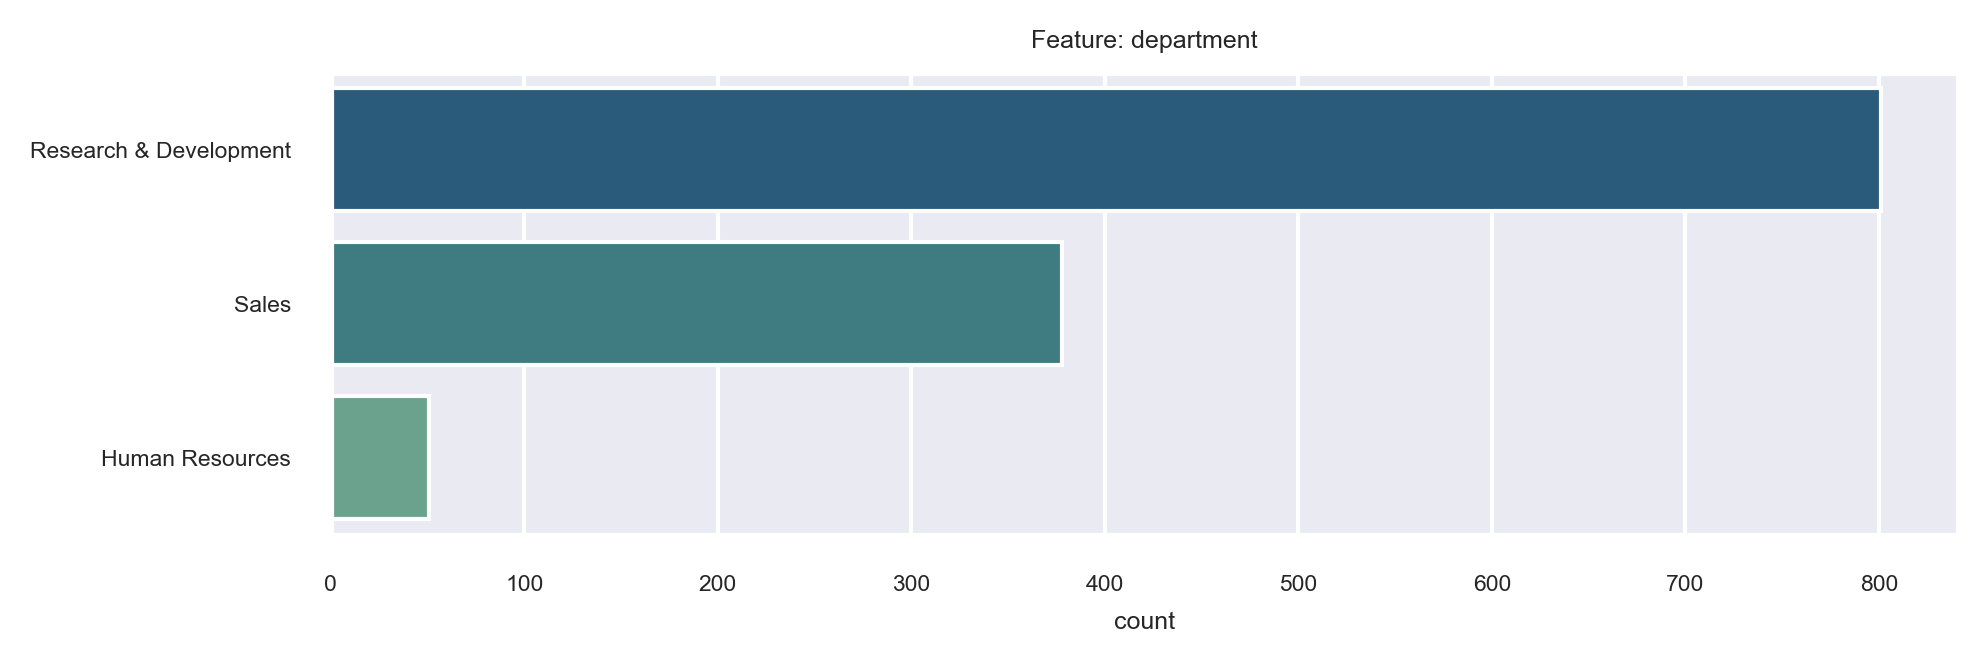

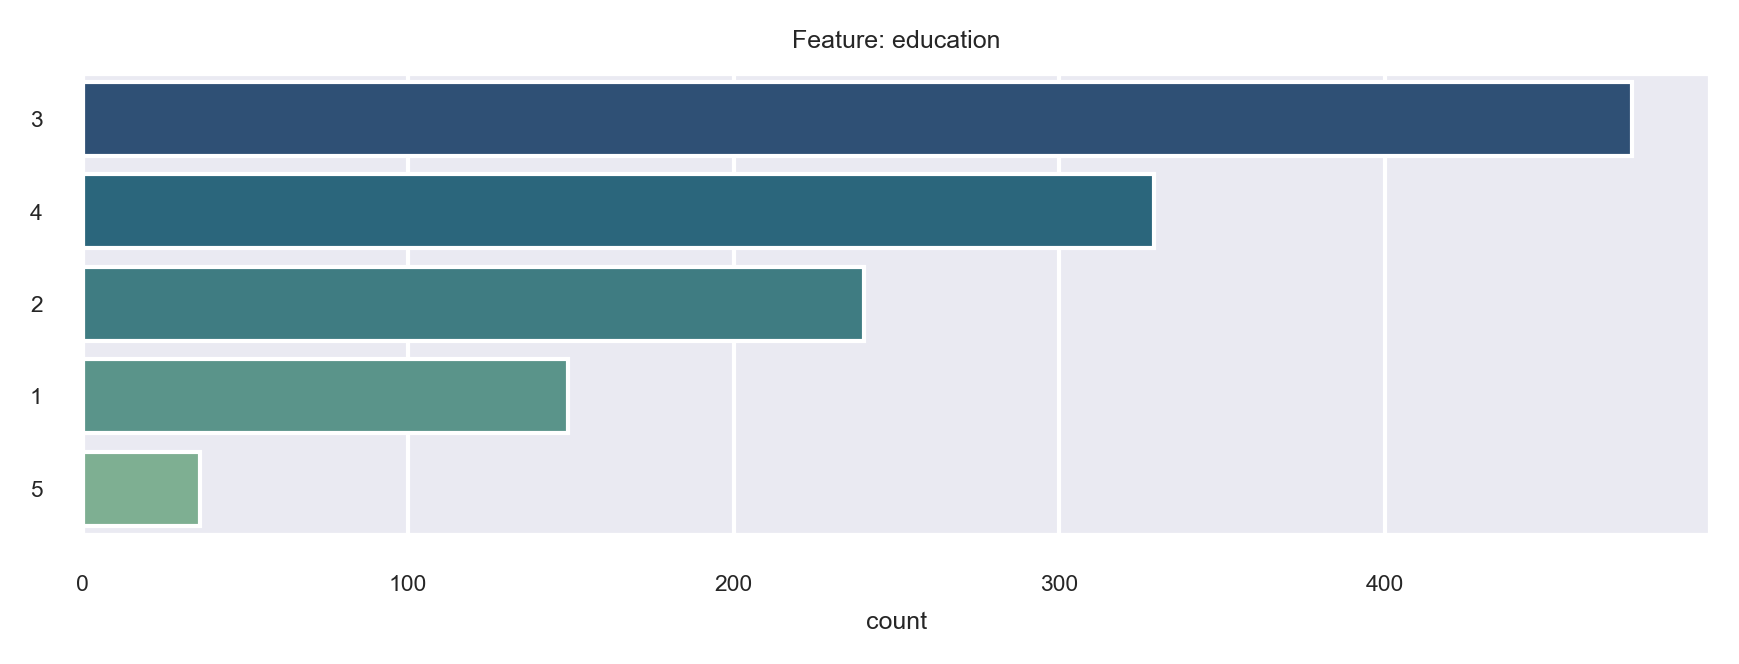

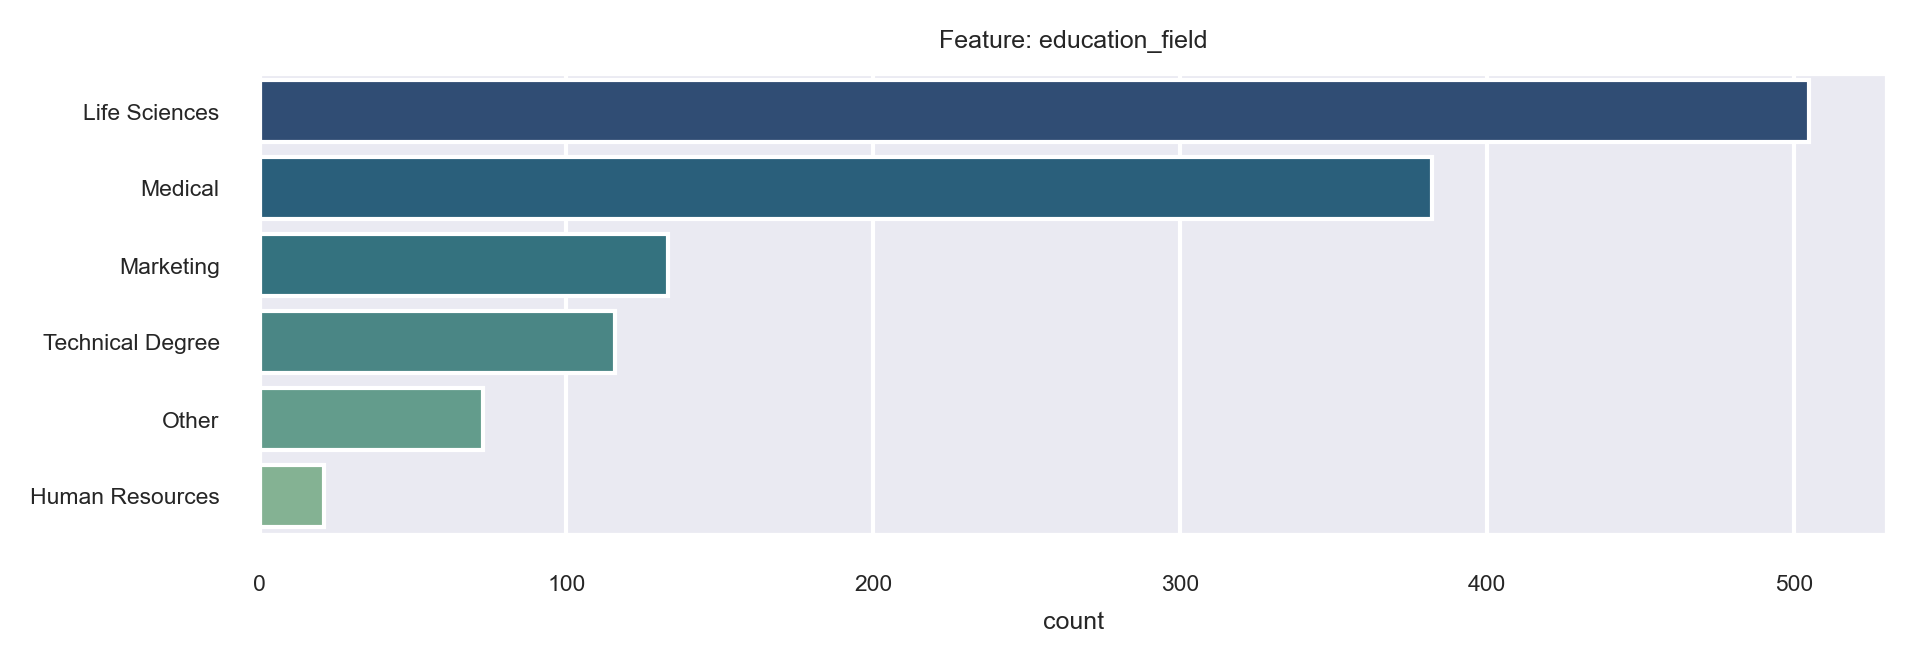

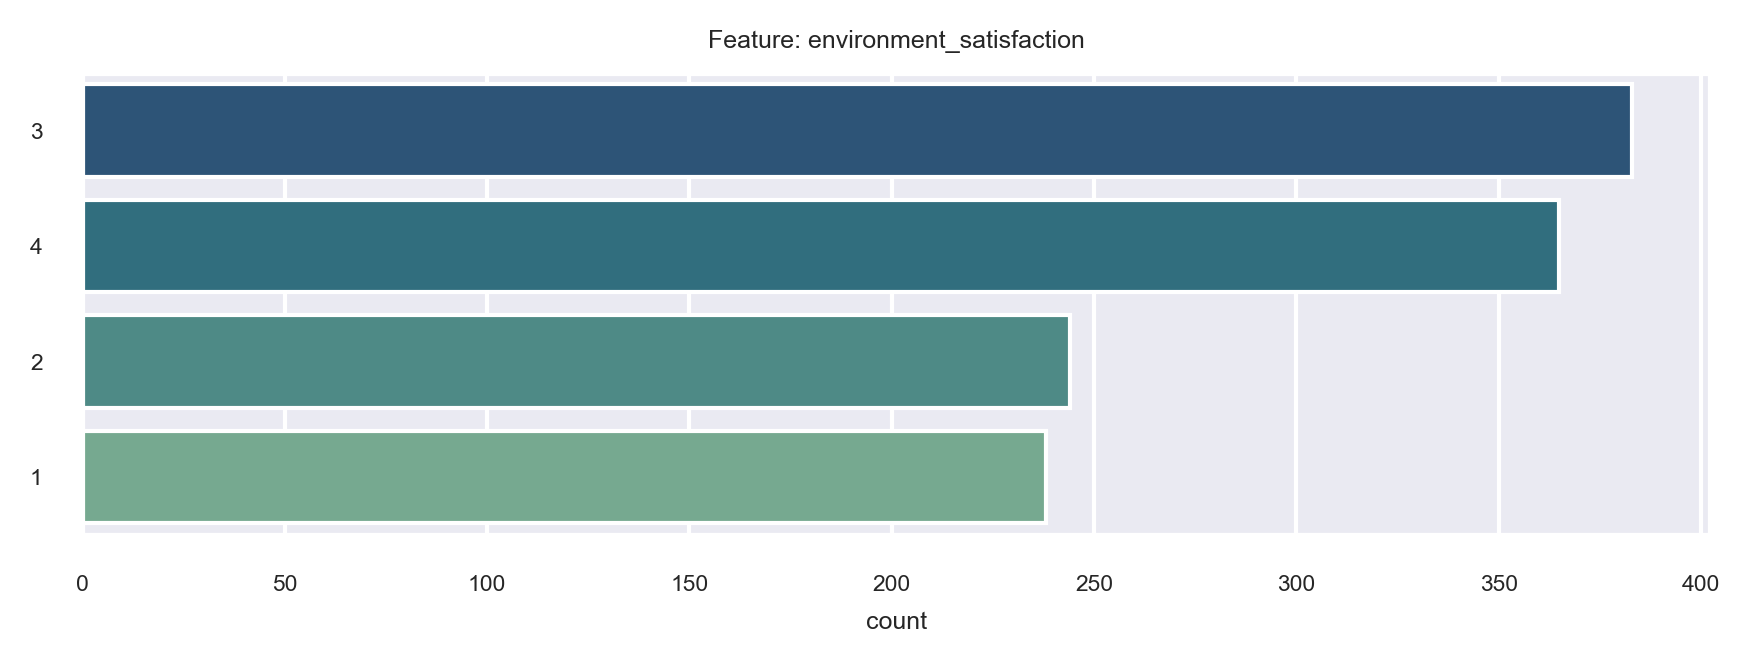

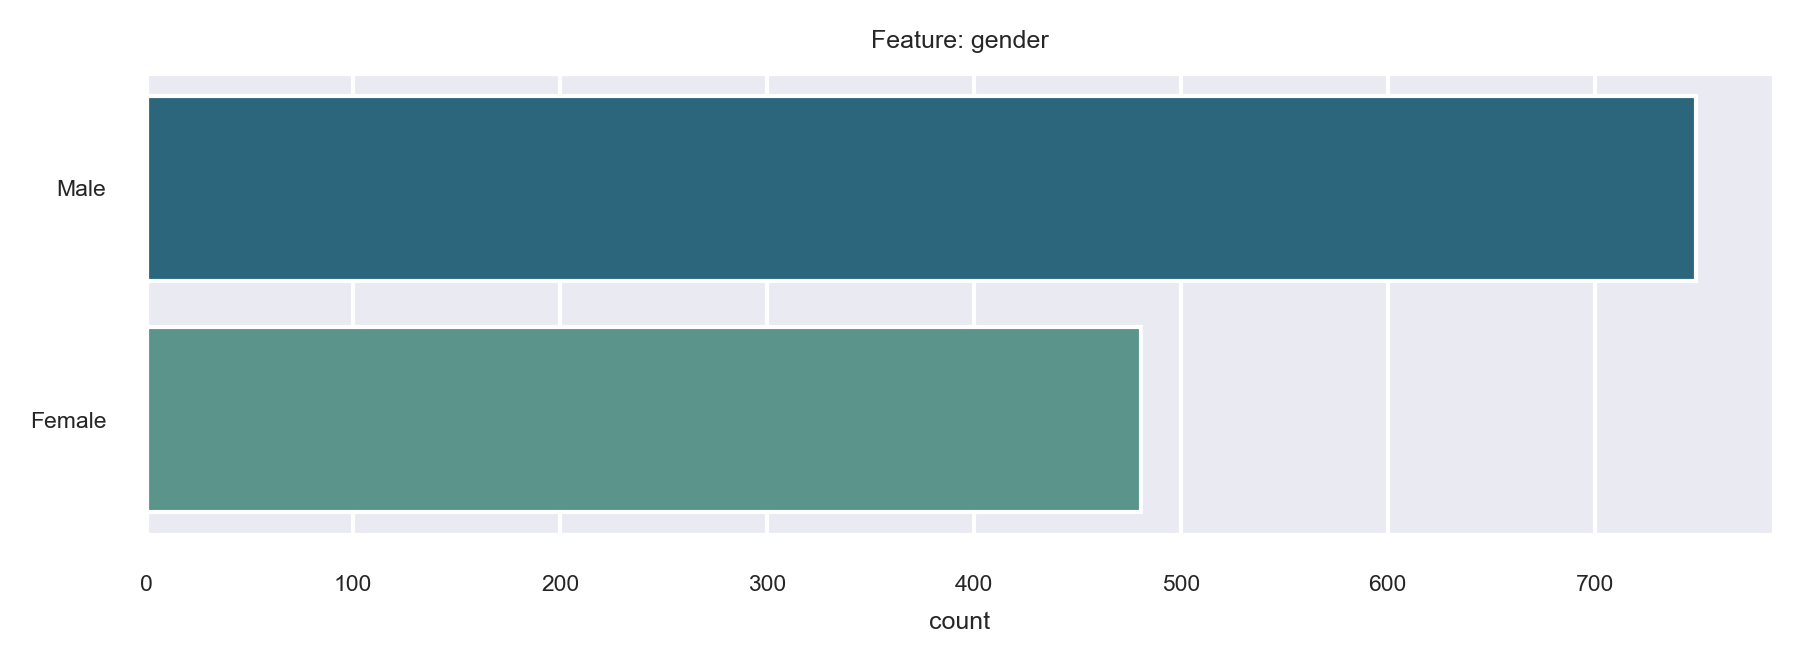

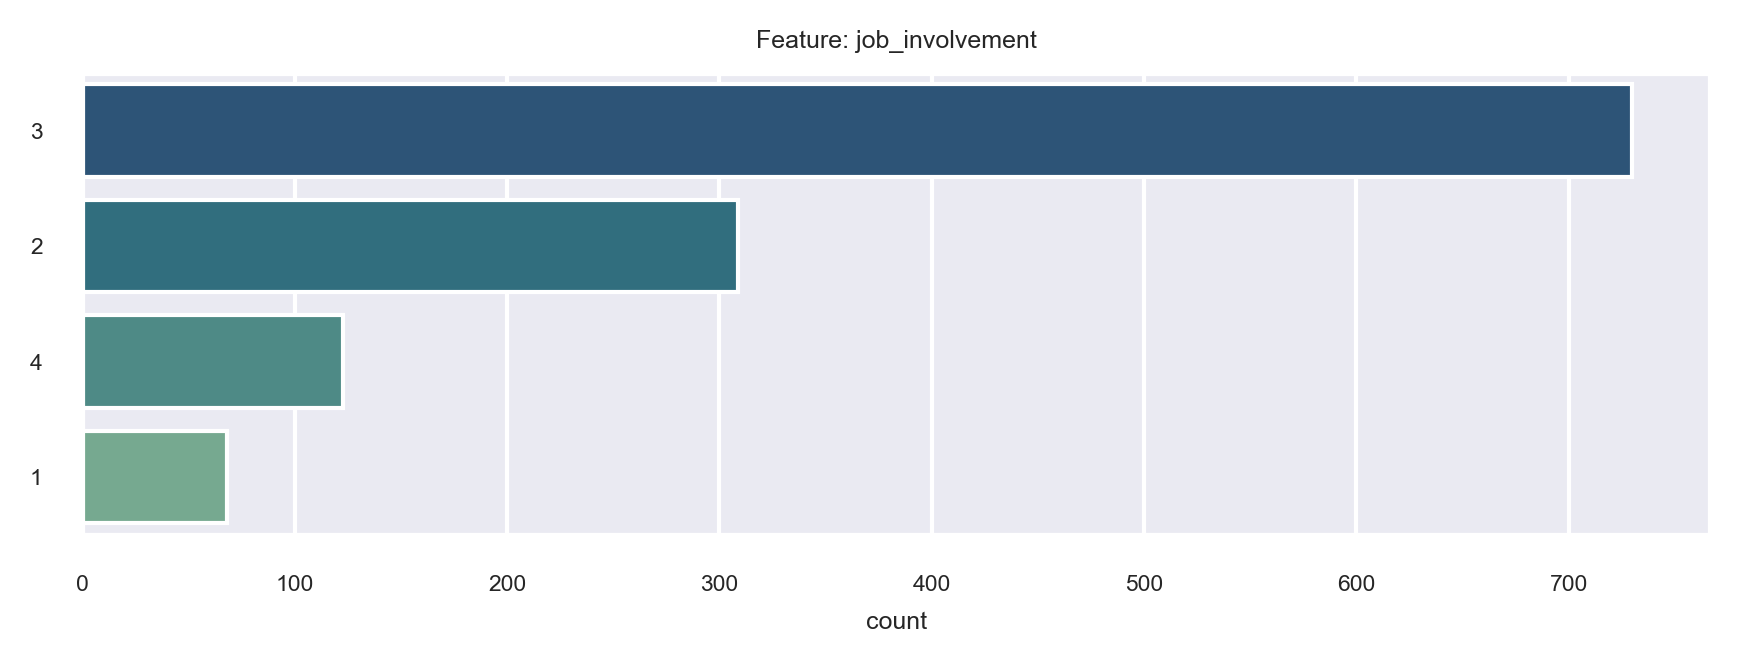

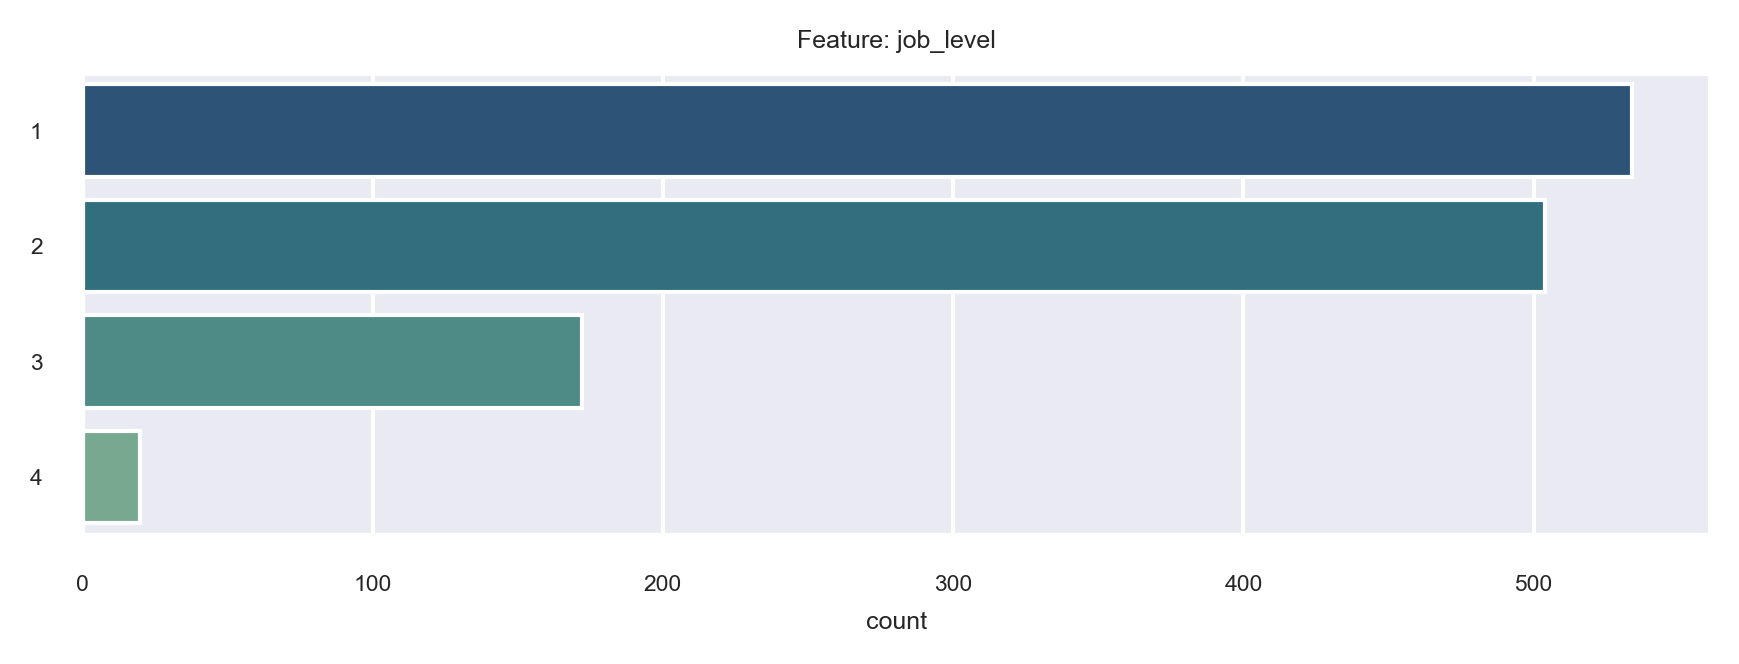

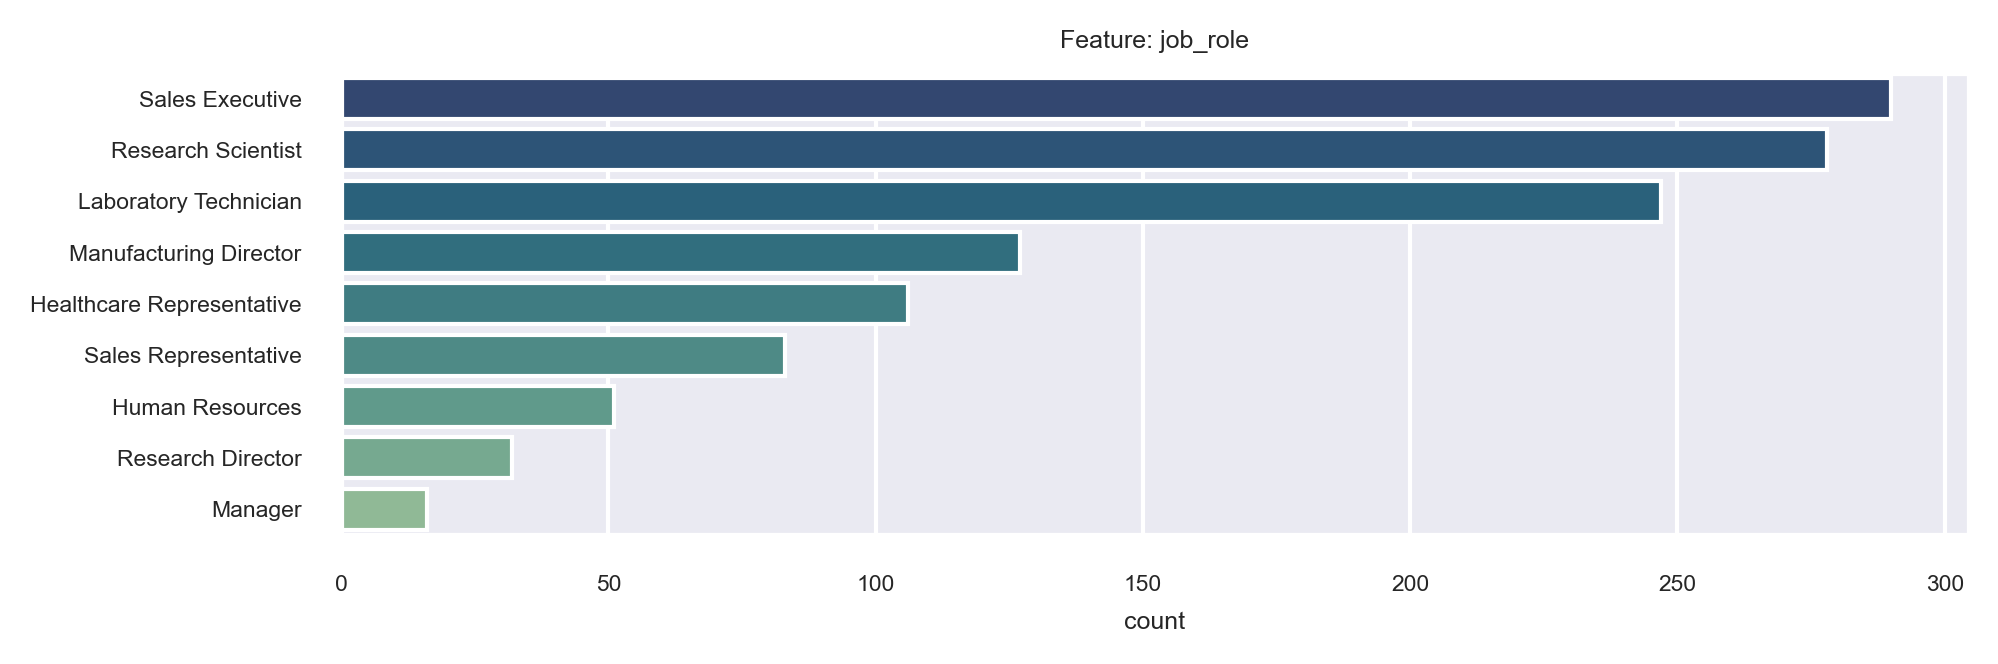

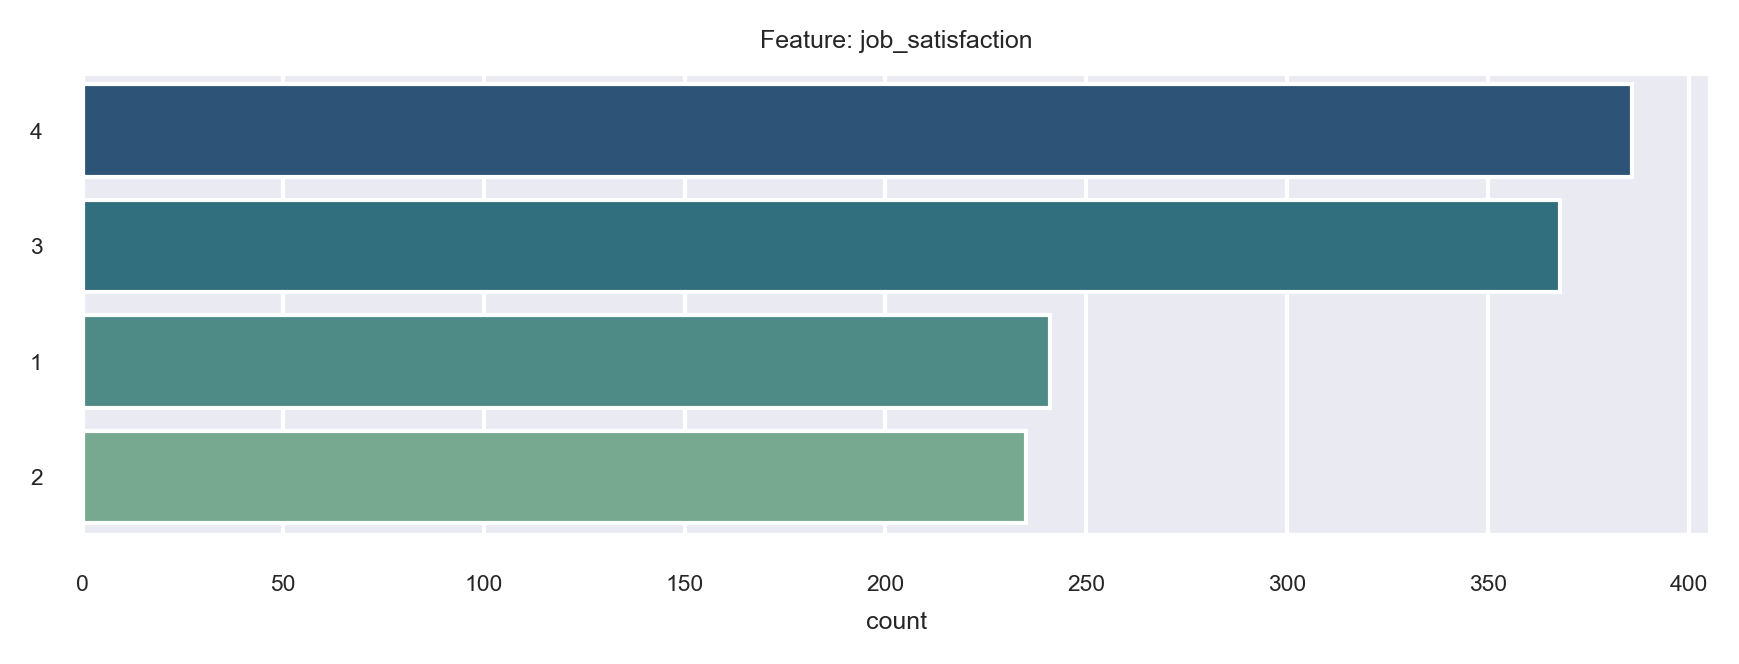

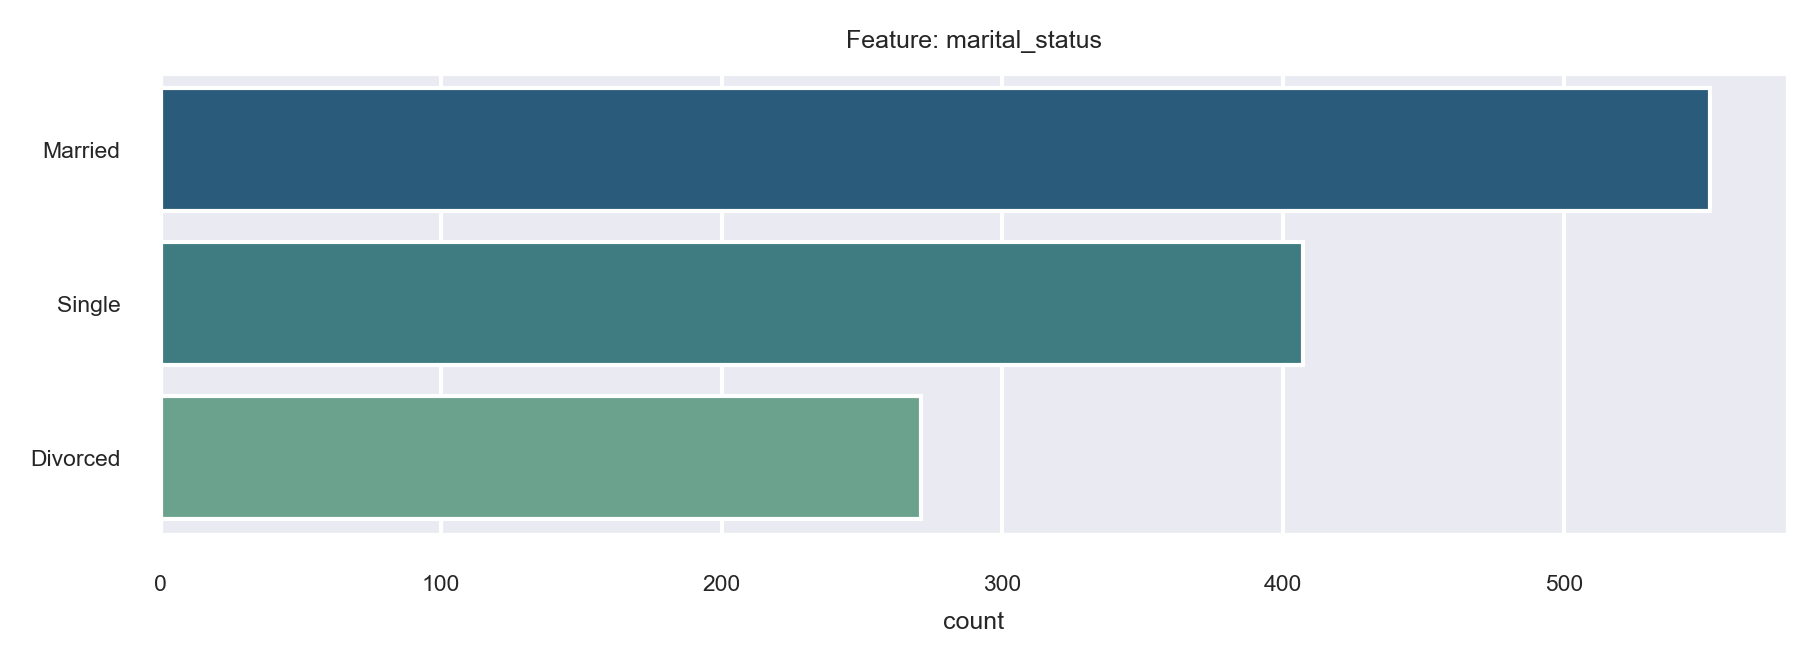

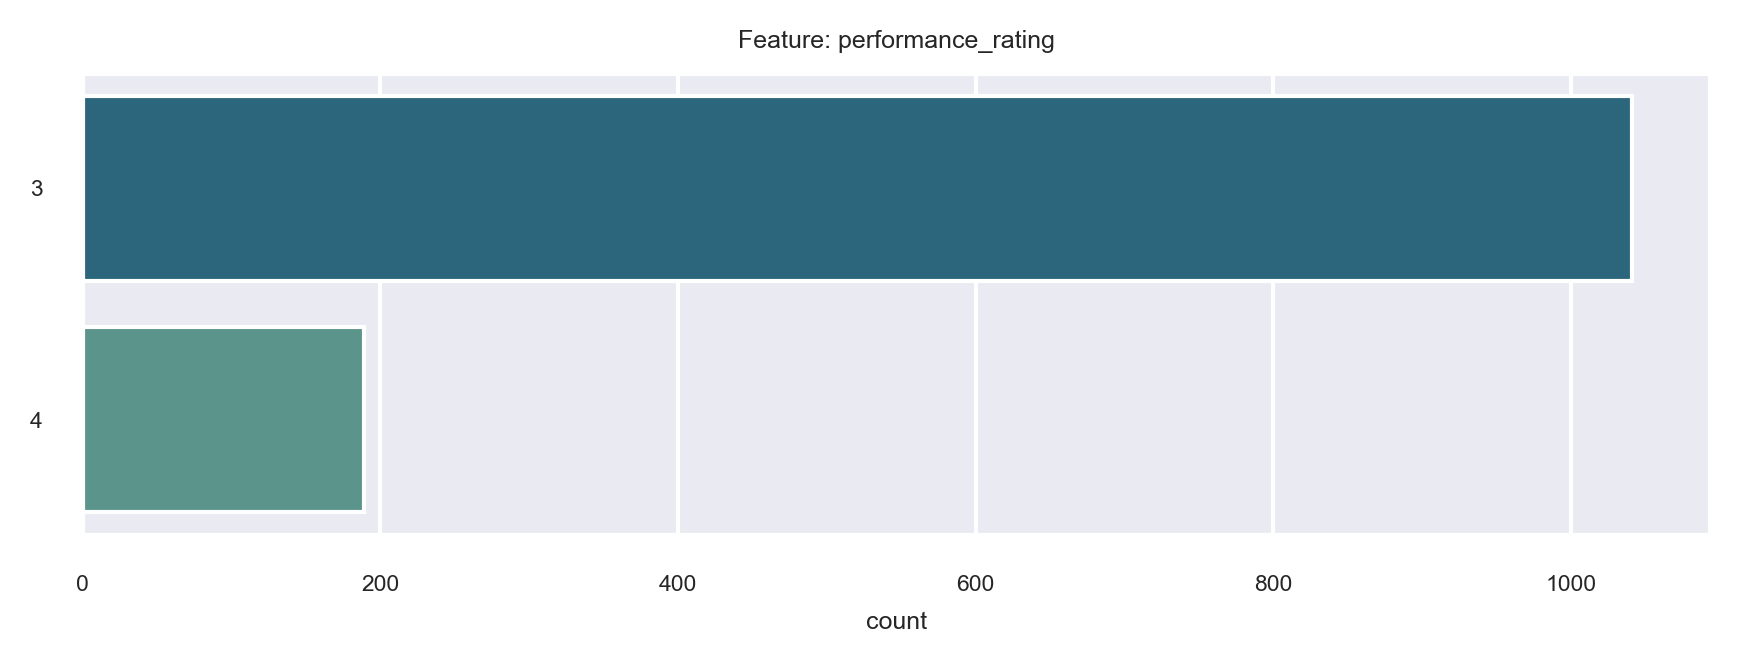

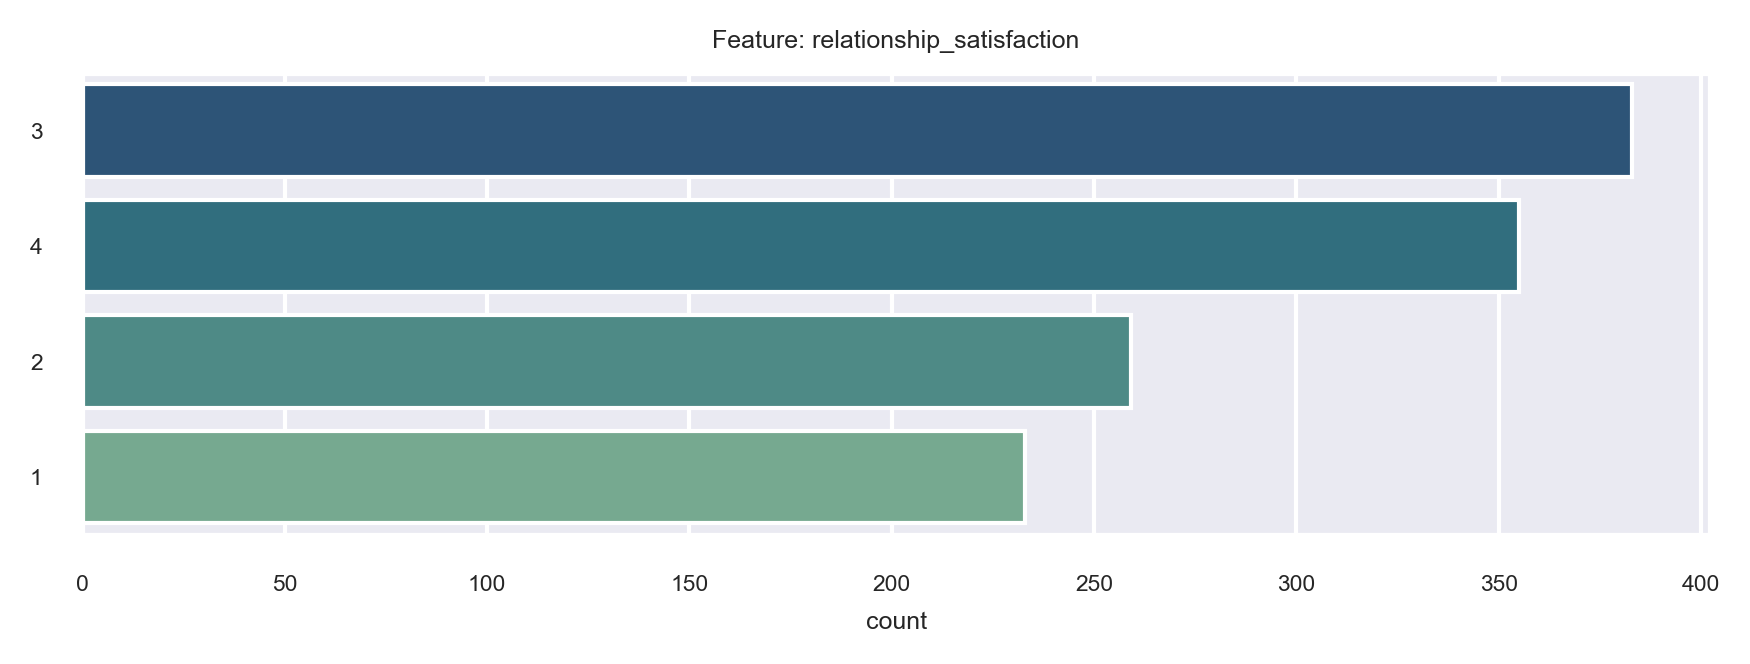

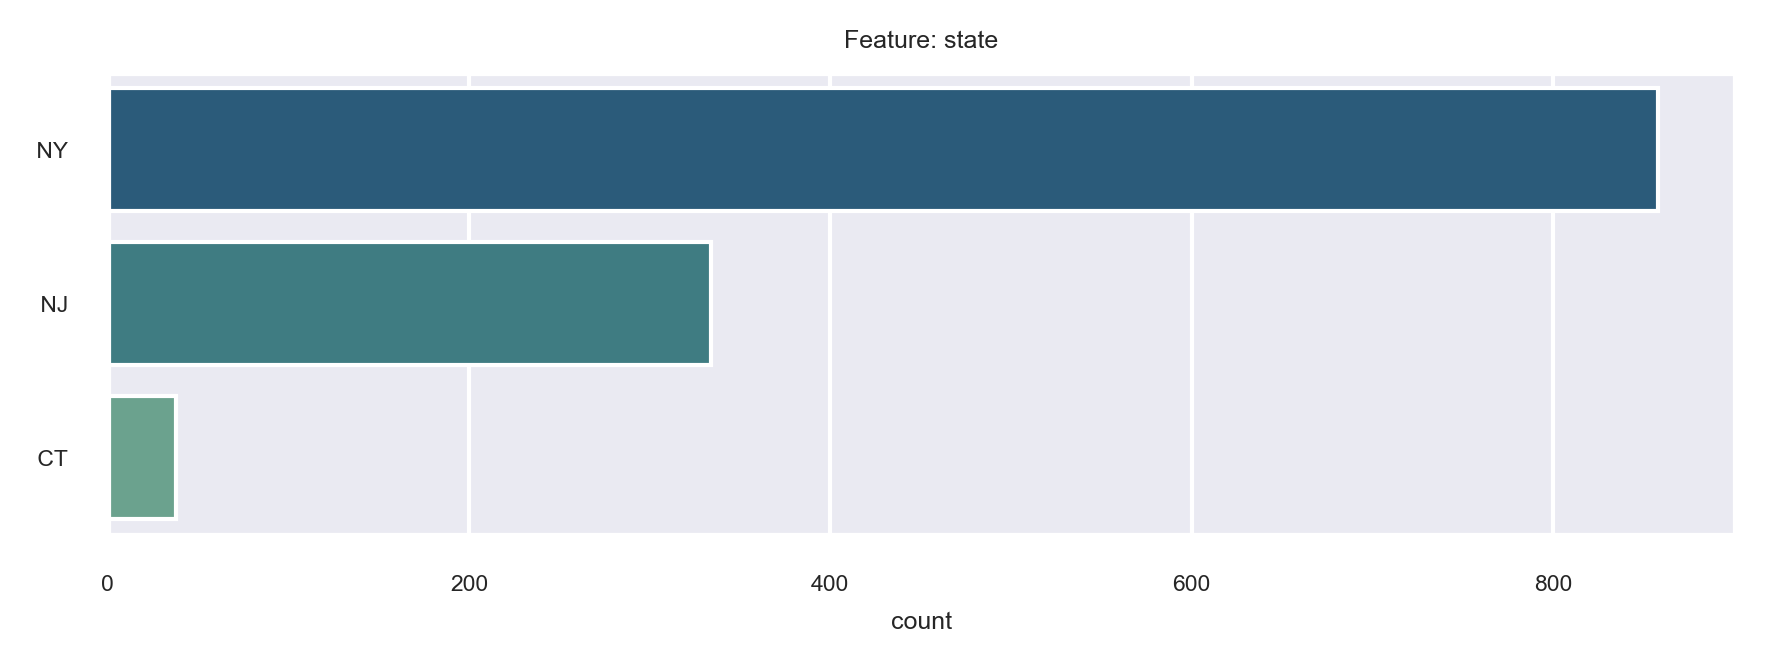

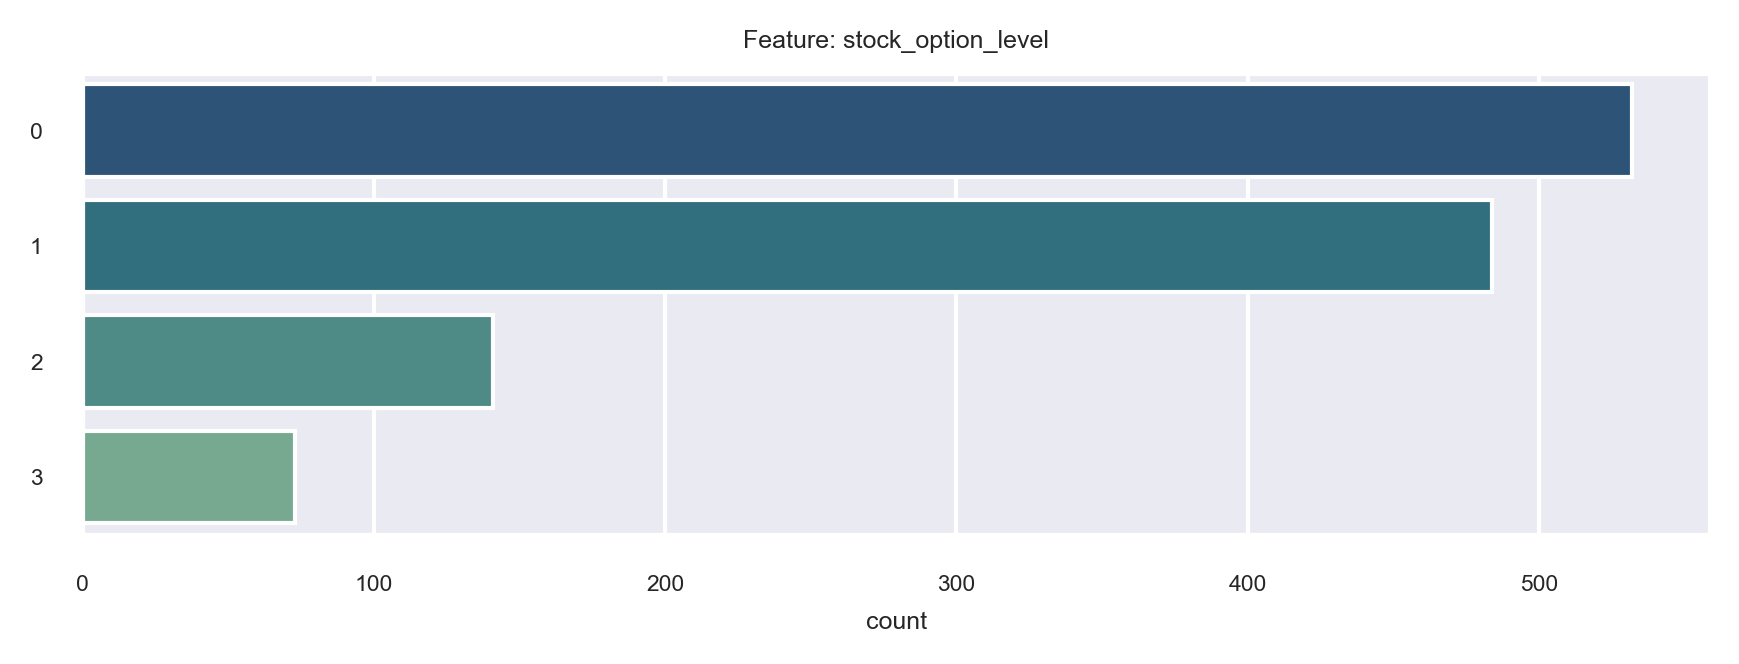

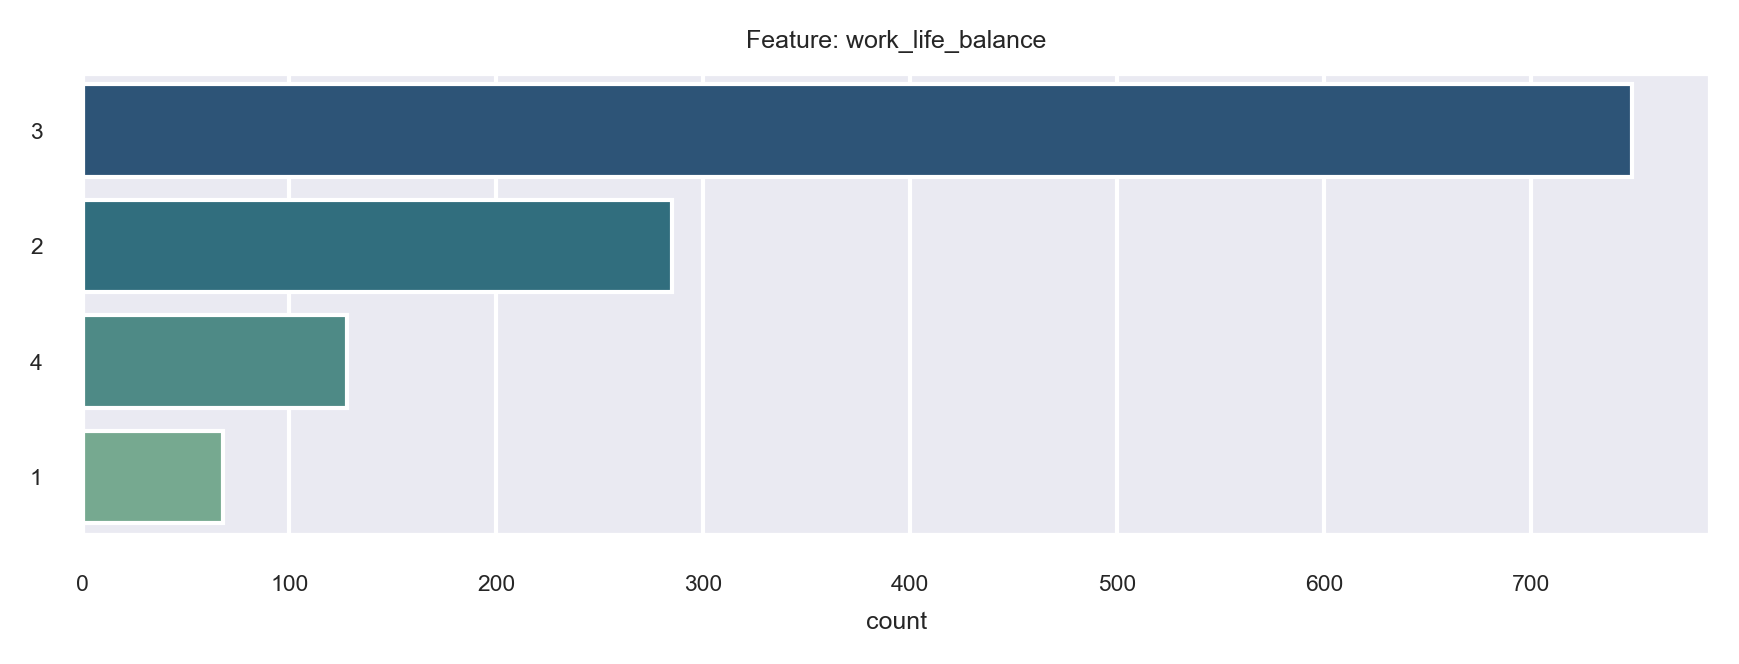

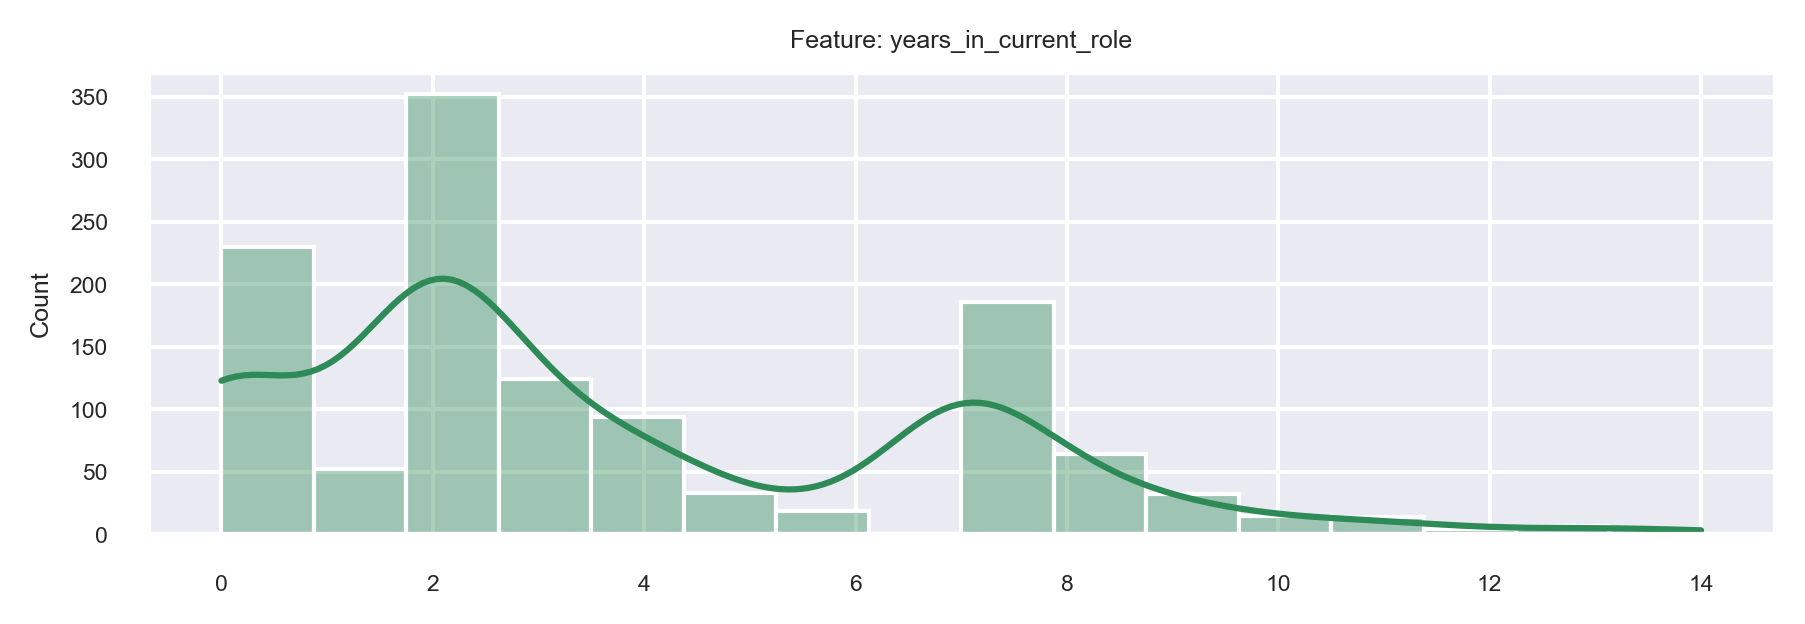

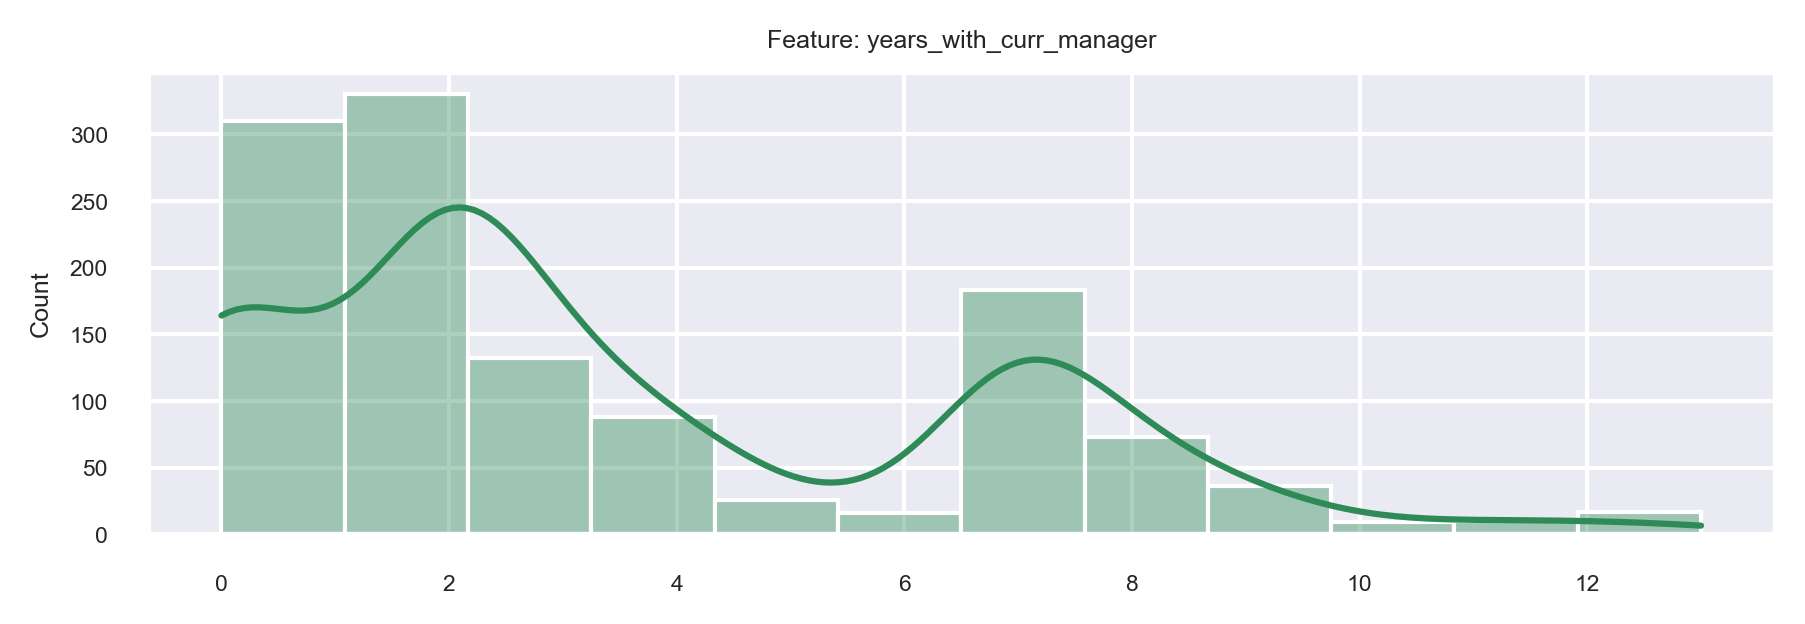

In [10]:
# visually examining the distribution of each feature/column 

prepare.plot_distribution(df)

In [11]:
# classifiying/viewing features by data type: discrete/categorical or continuous 

disc_lst = df.select_dtypes(exclude = "number").columns.sort_values().tolist()
cont_lst = df.select_dtypes(include = "number").columns.sort_values().tolist()

print(f'Discrete/Categorical Variables:\n-----------------------------------\n{disc_lst}')
print()
print(f'Continuous Variables:\n-----------------------------------\n{cont_lst}')

Discrete/Categorical Variables:
-----------------------------------
['attrition', 'county_name', 'department', 'education', 'education_field', 'environment_satisfaction', 'gender', 'job_involvement', 'job_level', 'job_role', 'job_satisfaction', 'marital_status', 'performance_rating', 'relationship_satisfaction', 'state', 'stock_option_level', 'work_life_balance']

Continuous Variables:
-----------------------------------
['employee_age', 'employment_rates_at_35', 'high_school_graduation_rate', 'household_income_at_35', 'incarceration_rate', 'monthly_income', 'percent_salary_hike', 'percentage_married_by_35', 'poverty_rate', 'single_parent_frac', 'total_working_years', 'training_times_last_year', 'women_teenage_birthrate', 'years_at_company', 'years_in_current_role', 'years_since_last_promotion', 'years_with_curr_manager']


----
### **``Data Preparation: First Split of Original Dataset``**

**<u>Highlights:</u>**
 
- Stratified on: "Attrition" for equal distribution of target variable in each dataset
- Data splits : 56% Train | 24% Validate | 20% Test

In [12]:
# calling a created function to split the dataframe 

train, validate, test = prepare.train_validate_test_split(df)

train shape: (688, 34)
validate shape: (296, 34)
test shape: (246, 34)


In [13]:
# checking the percentage of the target variable in ea. dataset

print(f'target percentage in train: {round(len(train[train["attrition"] == True])/train.shape[0], 3)}')
print(f'target percentage in validate: {round(len(validate[validate["attrition"] == True])/validate.shape[0], 3)}')
print(f'target percentage in test: {round(len(test[test["attrition"] == True])/test.shape[0], 3)}')

target percentage in train: 0.177
target percentage in validate: 0.176
target percentage in test: 0.175


#### ``Baseline Accuracy (mode outcome): Employee Attrition``

In [14]:
# setting an attrition baseline using a mode method for ea. dataset
# for the baseline accuracy, I have taken the mode of the two (2) binary "attrition" options = False and have set this as the baseline prediction
# baseline accuracy score: the total number of times that the baseline prediction matched the actual employee attrition outcome
# baseline accuracy score: ~82.0% **(note that if the goal is to predict attrition = 1, then baseline accuracy is ~18%)
    
train_baseline = train
train_baseline["baseline_prediction"] = False
baseline_train = (train_baseline["baseline_prediction"] == train_baseline["attrition"]).mean().round(4)
print(f'Training Baseline Accuracy: % {(baseline_train * 100).round(5)}')

print('-------------------------------------------')

validate_baseline = validate
validate_baseline["baseline_prediction"] = False
baseline_val = (validate_baseline["baseline_prediction"] == validate_baseline["attrition"]).mean().round(4)
print(f'Validate Baseline Accuracy: % {(baseline_val * 100).round(5)}')

Training Baseline Accuracy: % 82.27
-------------------------------------------
Validate Baseline Accuracy: % 82.43


-----

### **``Exploration: Hypothesis Testing``**

**``Variables intentionally not taken into exploration:``**

1. business travel
2. cty
3. daily rate
4. distance from home
5. hourly rate
6. monthly rate
7. num companies worked
8. over time

**``Continuous Variables:``**

1. employee age
2. employment rates at 35
3. high school graduation rate
4. household income at 35
5. incarceration rate
6. monthly income
7. percent salary hike
8. percentage married by 35
9. poverty rate
10. single parent frac
11. total working years
12. training times last year
13. women teenage birthrate
14. years at company
15. years since last promotion
16. years in current role
17. years with current manager

**``Discrete Variables:``**

1. attrition
2. county name
3. department
4. education
5. education field
6. environment satisfaction
7. gender
8. job involvement
9. job level
10. job role
11. job satisfaction
12. marital status
13. performance rating
14. relationship satisfaction
15. standard hours
16. state
17. stock option level
18. work life balance

In [15]:
# setting continuous variables list for testing

cont_lst = sorted([
'employee_age',
'monthly_income',
'percent_salary_hike',
'total_working_years',
'training_times_last_year',
'years_at_company',
'household_income_at_35',
'high_school_graduation_rate',
'percentage_married_by_35',
'incarceration_rate',
'women_teenage_birthrate',
'poverty_rate',
'employment_rates_at_35',
'single_parent_frac',
'years_since_last_promotion',
'years_in_current_role',
'years_with_curr_manager',
])

In [16]:
# setting discrete/categorical variables list for testing

disc_lst = sorted([
'stock_option_level',
'work_life_balance',
'education',
'job_involvement',
'job_level',
'job_satisfaction',
'performance_rating',
'relationship_satisfaction',
'county_name',
'state',
'department',
'education_field',
'gender',
'job_role',
'marital_status',
'environment_satisfaction'
])

In [17]:
# 2nd split: splitting larger datasets into x and y variables

X_train = train.drop(columns = "attrition")
y_train = train['attrition']

X_validate = validate.drop(columns = "attrition")
y_validate = validate['attrition']

X_test = test.drop(columns = "attrition")
y_test = test['attrition']

In [18]:
# checking the target variable
# note: the model will also read boolean type (F/T) as either (0/1)
# False (with the company):         566 employees
# True (has left the company):      122 employees

y_train.value_counts()

False    566
True     122
Name: attrition, dtype: int64

----
### ``Hypothesis Tests: Continuous Variables``

**<u>``1-sample | 2 Tail T-test``</u>**


$H_0$ (Null Hypothesis): The variable mean of turn over employees is not statistically different than the population variable mean.

$H_a$ (Alternate Hypothesis): The variable mean for turn over employees is statistically different than the population variable mean.

* $alpha$: 1.0 - Confidence Interval (95% confidence level)
* $\alpha$ = 0.05

In [19]:
# setting an alpha value

alpha = 0.05

In [20]:
# setting a list of social-mobility metrics

social_lst = [col for col in train.columns if 'rate' in col or 'household' in col or 'by' in col or 'employee' in col]

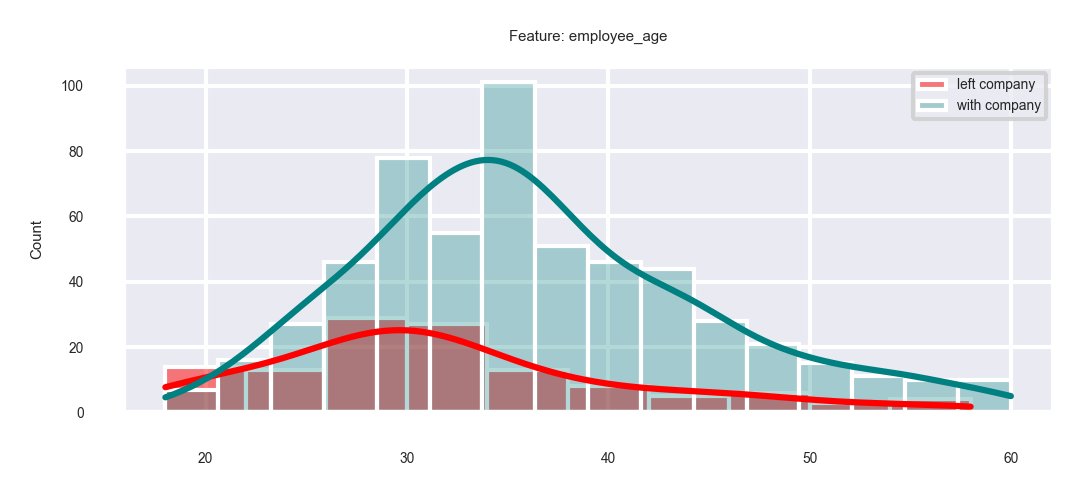

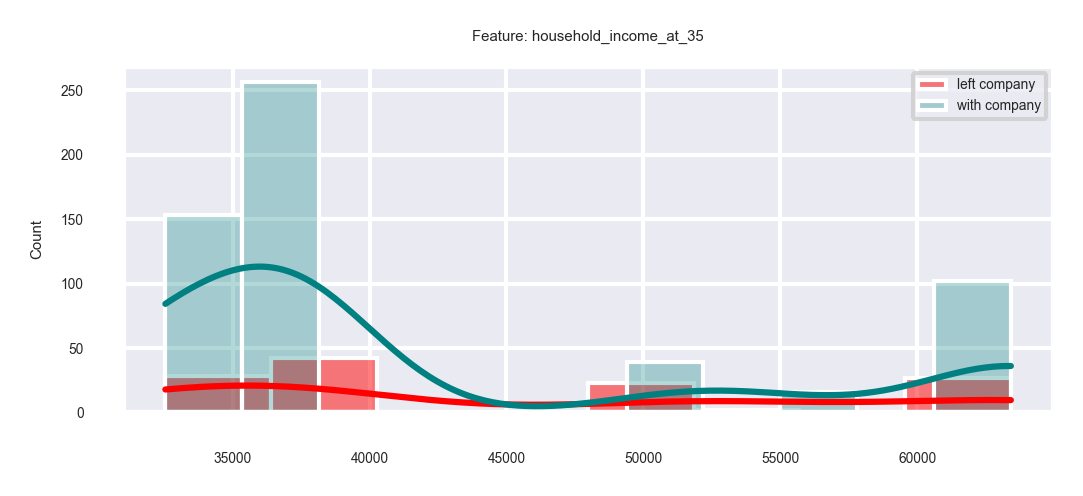

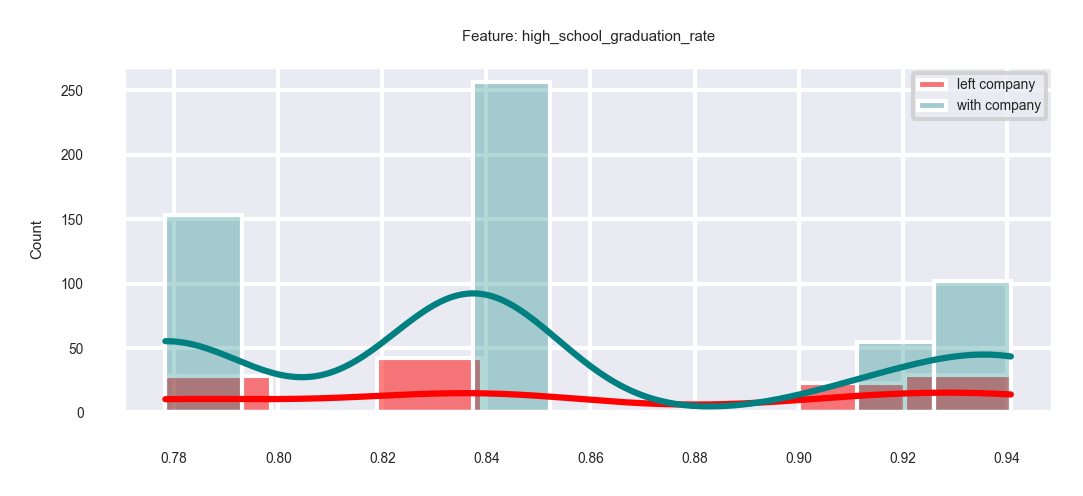

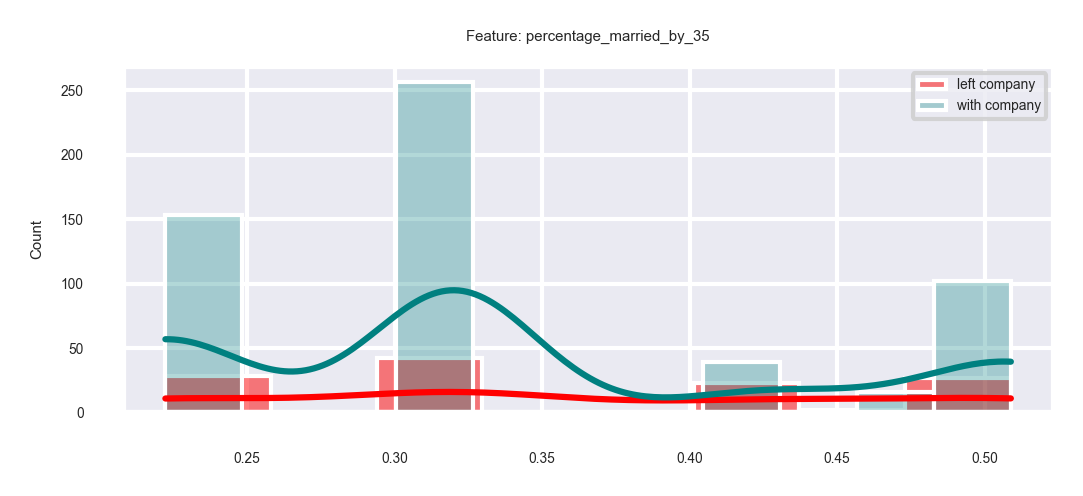

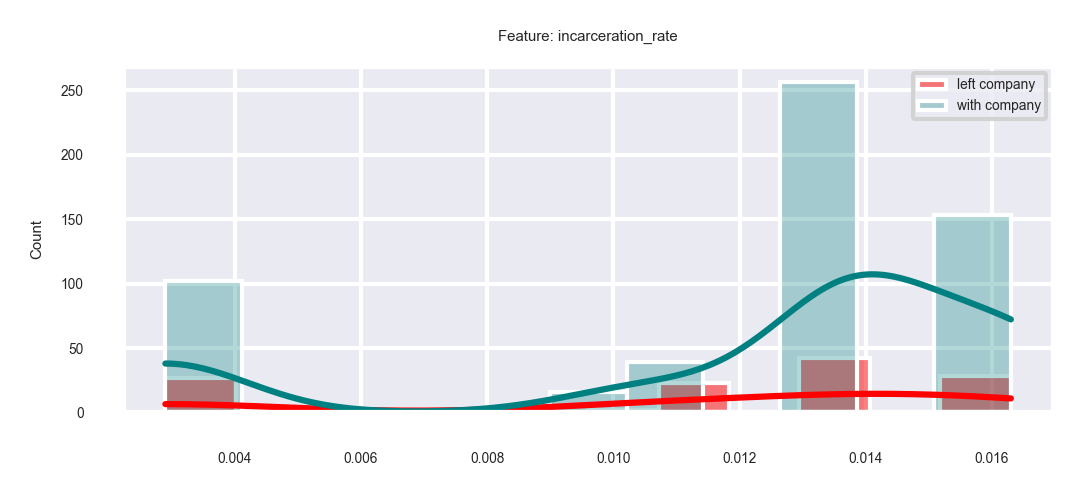

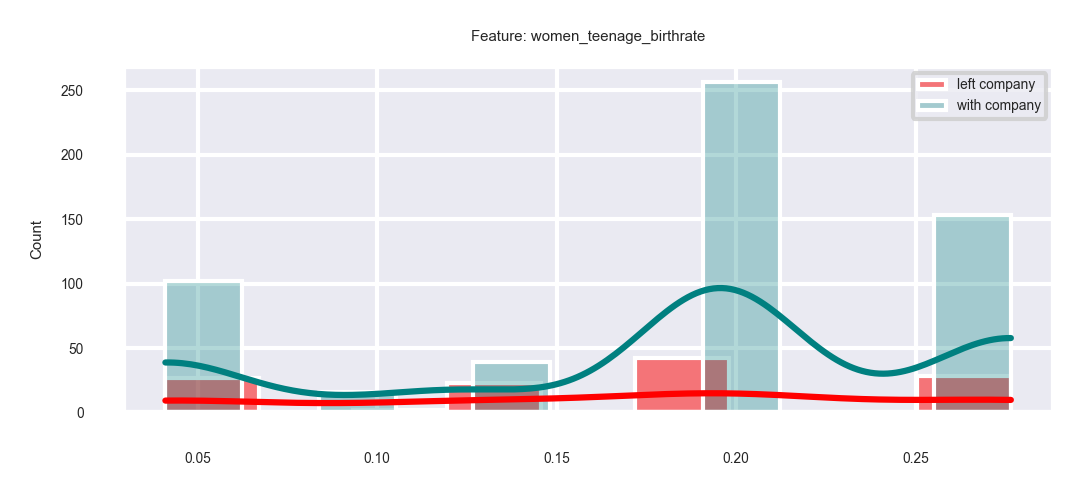

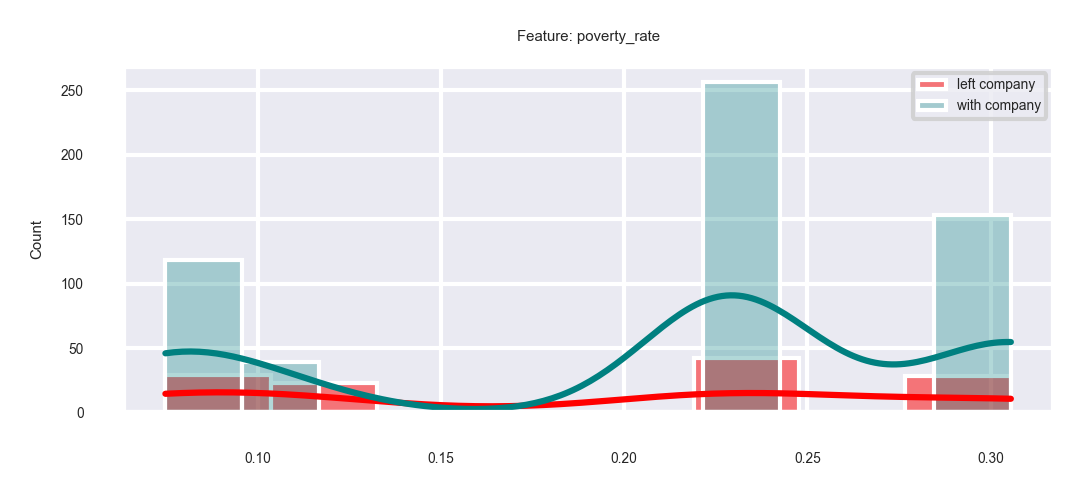

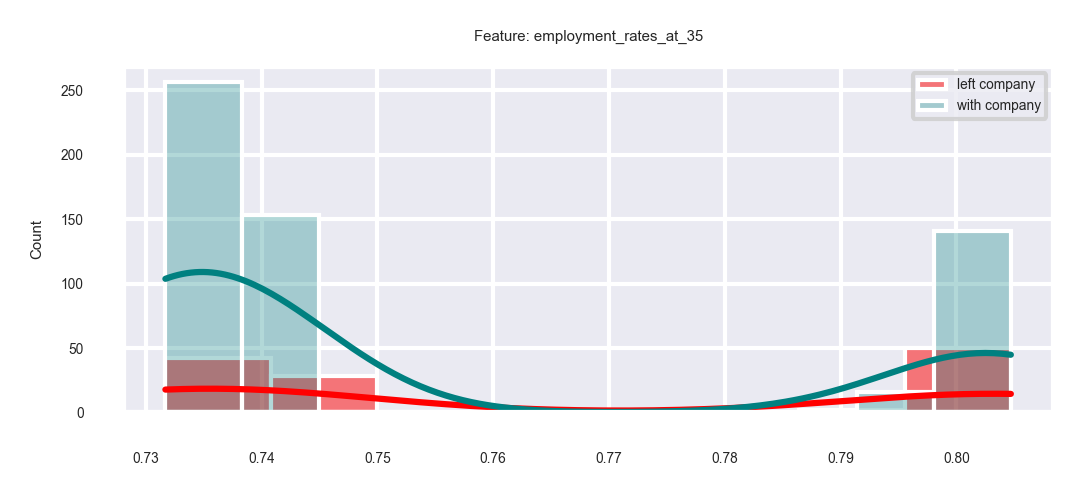

In [21]:
# distribution plot of employee equity / demographic variables

for col in social_lst:
    plt.figure(figsize= (4, 1.5))
    sns.set(font_scale = 0.3, style="darkgrid")

    sns.histplot(train[train["attrition"] == True][col], color="red", alpha = 0.5, label="left company", kde=True)
    sns.histplot(train[train["attrition"] == False][col], color="teal", alpha = 0.3, label="with company", kde=True)


    plt.title(f'Feature: {col}')
    plt.xlabel(None)
    plt.legend() 
    plt.show()

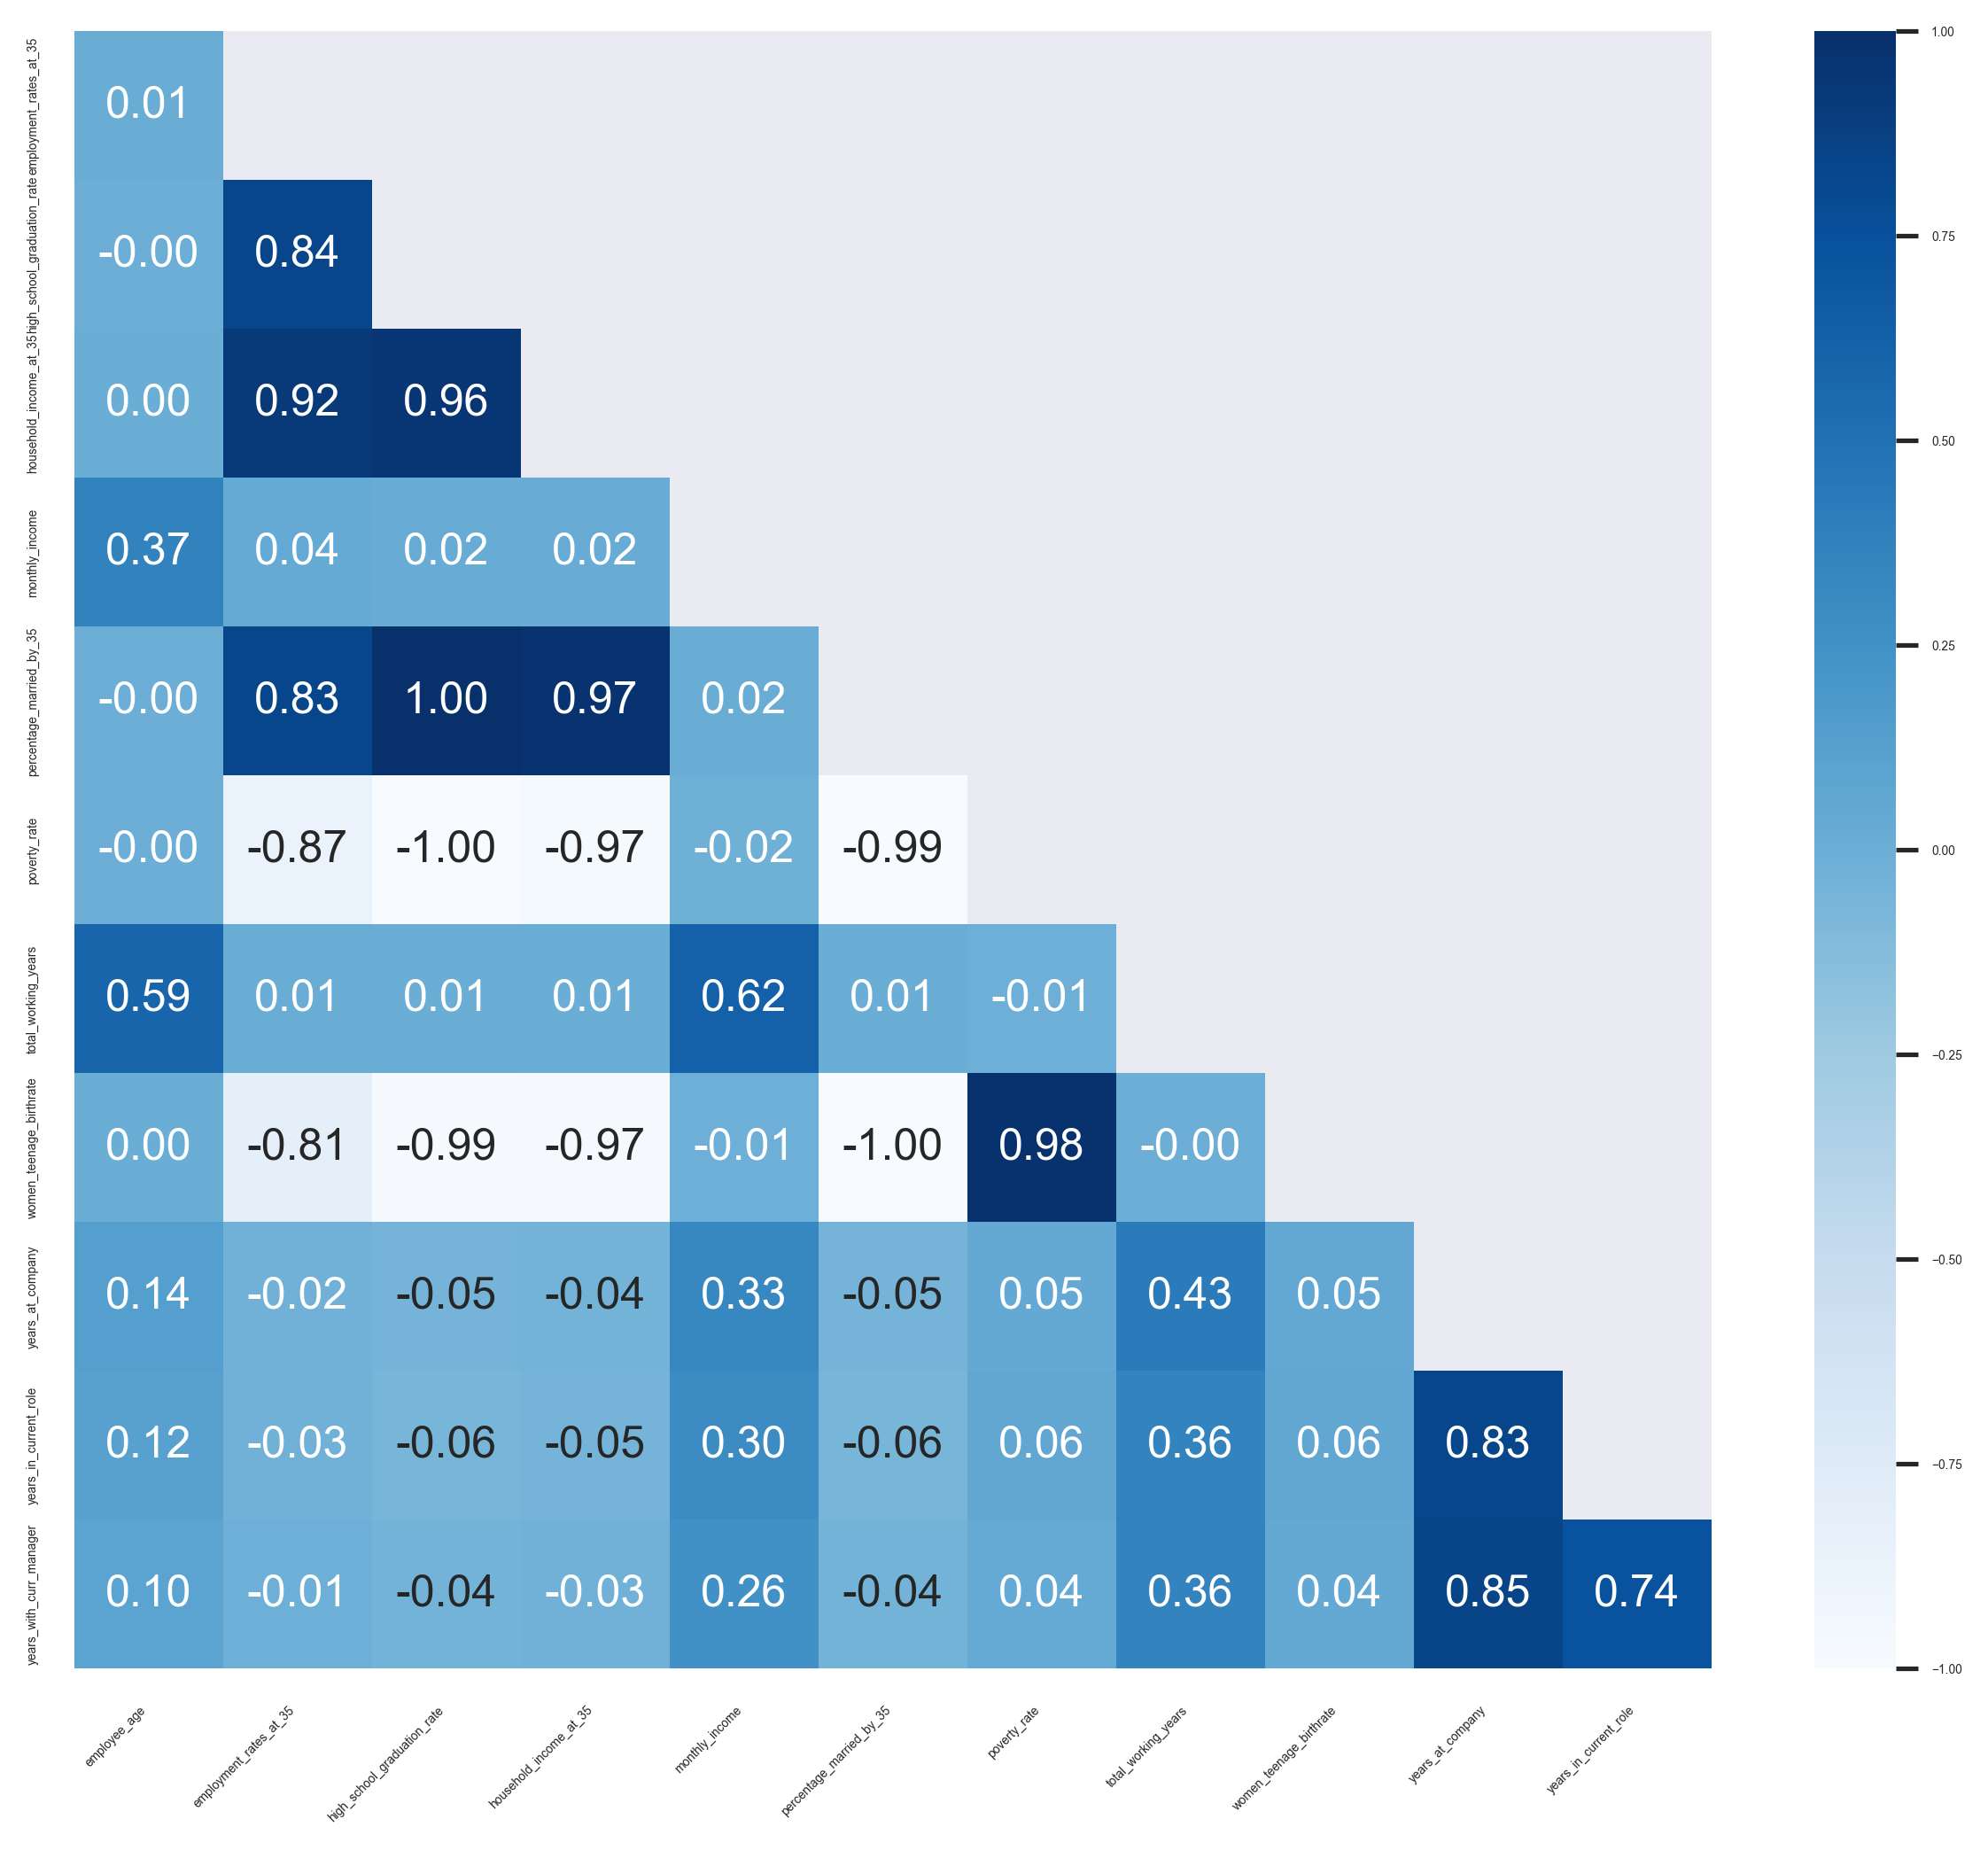

In [22]:
# viewing potential correlation amongst continuous variables

# taking needed variables sample
corr_df = train[[ 
    'employee_age',
    'employment_rates_at_35',
    'high_school_graduation_rate',
    'household_income_at_35',
    'monthly_income',
    'percentage_married_by_35',
    'poverty_rate',
    'total_working_years',
    'women_teenage_birthrate',
    'years_at_company',
    'years_in_current_role',
    'years_with_curr_manager']].reset_index(drop = True)

# returning correlation coefficient 
corr_array = corr_df.corr()

# creating the object and axes
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_style("white")

# mask
mask = np.triu(np.ones_like(corr_array, dtype=bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = corr_array.iloc[1:,:-1].copy()

g = sns.heatmap(
    corr, 
    mask=mask,
    cmap = "Blues",
    vmin = -1, 
    vmax = 1, 
    annot = True,
    annot_kws={
        'fontsize': 12
    },
    fmt =".2f",
    linewidths = 0,
    square = True)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.grid(False)
plt.show()

In [23]:
# continuous variables and evaluating statistical signifance in sample mean vs. population mean

metrics = []

for col in cont_lst:
    pop_mean = train[col].mean()
    sample_col = train[train["attrition"] == True][col]

    t_score, p_value = stats.ttest_1samp(sample_col, pop_mean)

    if p_value < alpha:
        output = {
            "continuous_feature": col,
            "t_score": t_score,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'Column: {col} is not statistically significant.')
        print("------------------------------------------------------------")

onesample_t_test_scores = pd.DataFrame(metrics)
onesample_t_test_scores.round(4)

Column: incarceration_rate is not statistically significant.
------------------------------------------------------------
Column: percent_salary_hike is not statistically significant.
------------------------------------------------------------
Column: percentage_married_by_35 is not statistically significant.
------------------------------------------------------------
Column: single_parent_frac is not statistically significant.
------------------------------------------------------------
Column: training_times_last_year is not statistically significant.
------------------------------------------------------------
Column: women_teenage_birthrate is not statistically significant.
------------------------------------------------------------
Column: years_since_last_promotion is not statistically significant.
------------------------------------------------------------


continuous_feature  t_score  p_value
0                 employee_age  -4.3084   0.0000
1       employment_rates_at_35   2.8331   0.0054
2  high_school_graduation_rate   2.1863   0.0307
3       household_income_at_35   2.1180   0.0362
4               monthly_income  -4.6421   0.0000
5                 poverty_rate  -2.2564   0.0258
6          total_working_years  -5.6756   0.0000
7             years_at_company  -5.0105   0.0000
8        years_in_current_role  -4.3125   0.0000
9      years_with_curr_manager  -4.4062   0.0000

----

#### **``Summary: 1-sample T-test Results``**

After hypotheses testing of continuous variables' population mean - I conclude that the following features/variables hold a statistical correlation with employee attrition:

1. age
2. employment rates at 35
3. high school graduation rate
4. household income at 35
5. monthly income
6. percentage married by 35
7. poverty rate
8. total working years
9. women teenage birthrate
10. years at company
11. years in current role
12. years with curr manager

**<u>Follow-up questions/thoughts after analysis:</u>**

There are several variables that I will want to further investigate against the population. For example, are variables such as county percentage of single parents or the total number of years since an employee's last promotion non-linear and therefore would warrant non-parametric/linear relationship testing which may be more suitable for measuring their relationship with attrition. 

----

### **``Hypothesis Tests: Categorical/Discrete Variables``**

**<u>``Chi_Squared Test``</u>**

$H_0$: "There is not a relationship between observed variable outcomes and expected employee turn over."

$H_a$: "There is a relationship between observed variable outcomes and expected employee turn over."

* $alpha$: 1 - Confidence Interval (95% confidence level)
* $\alpha$ = 0.05

In [24]:
# setting an alpha value 

alpha = 0.05

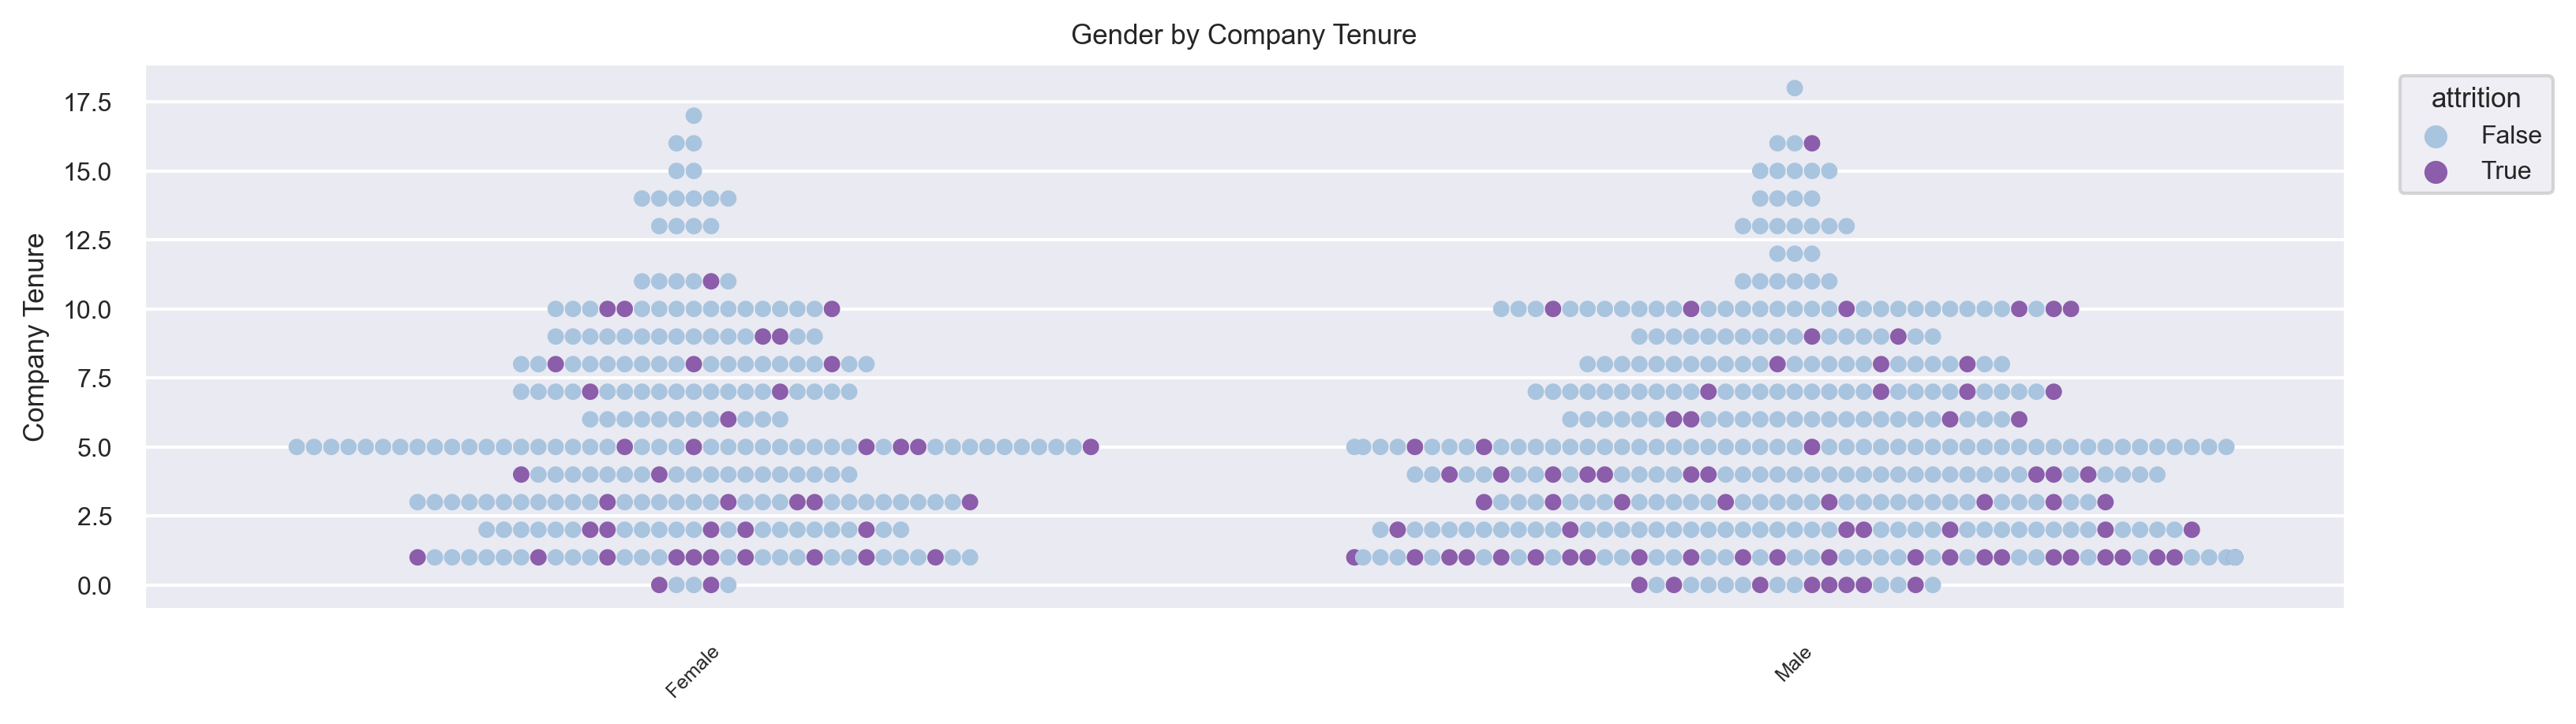

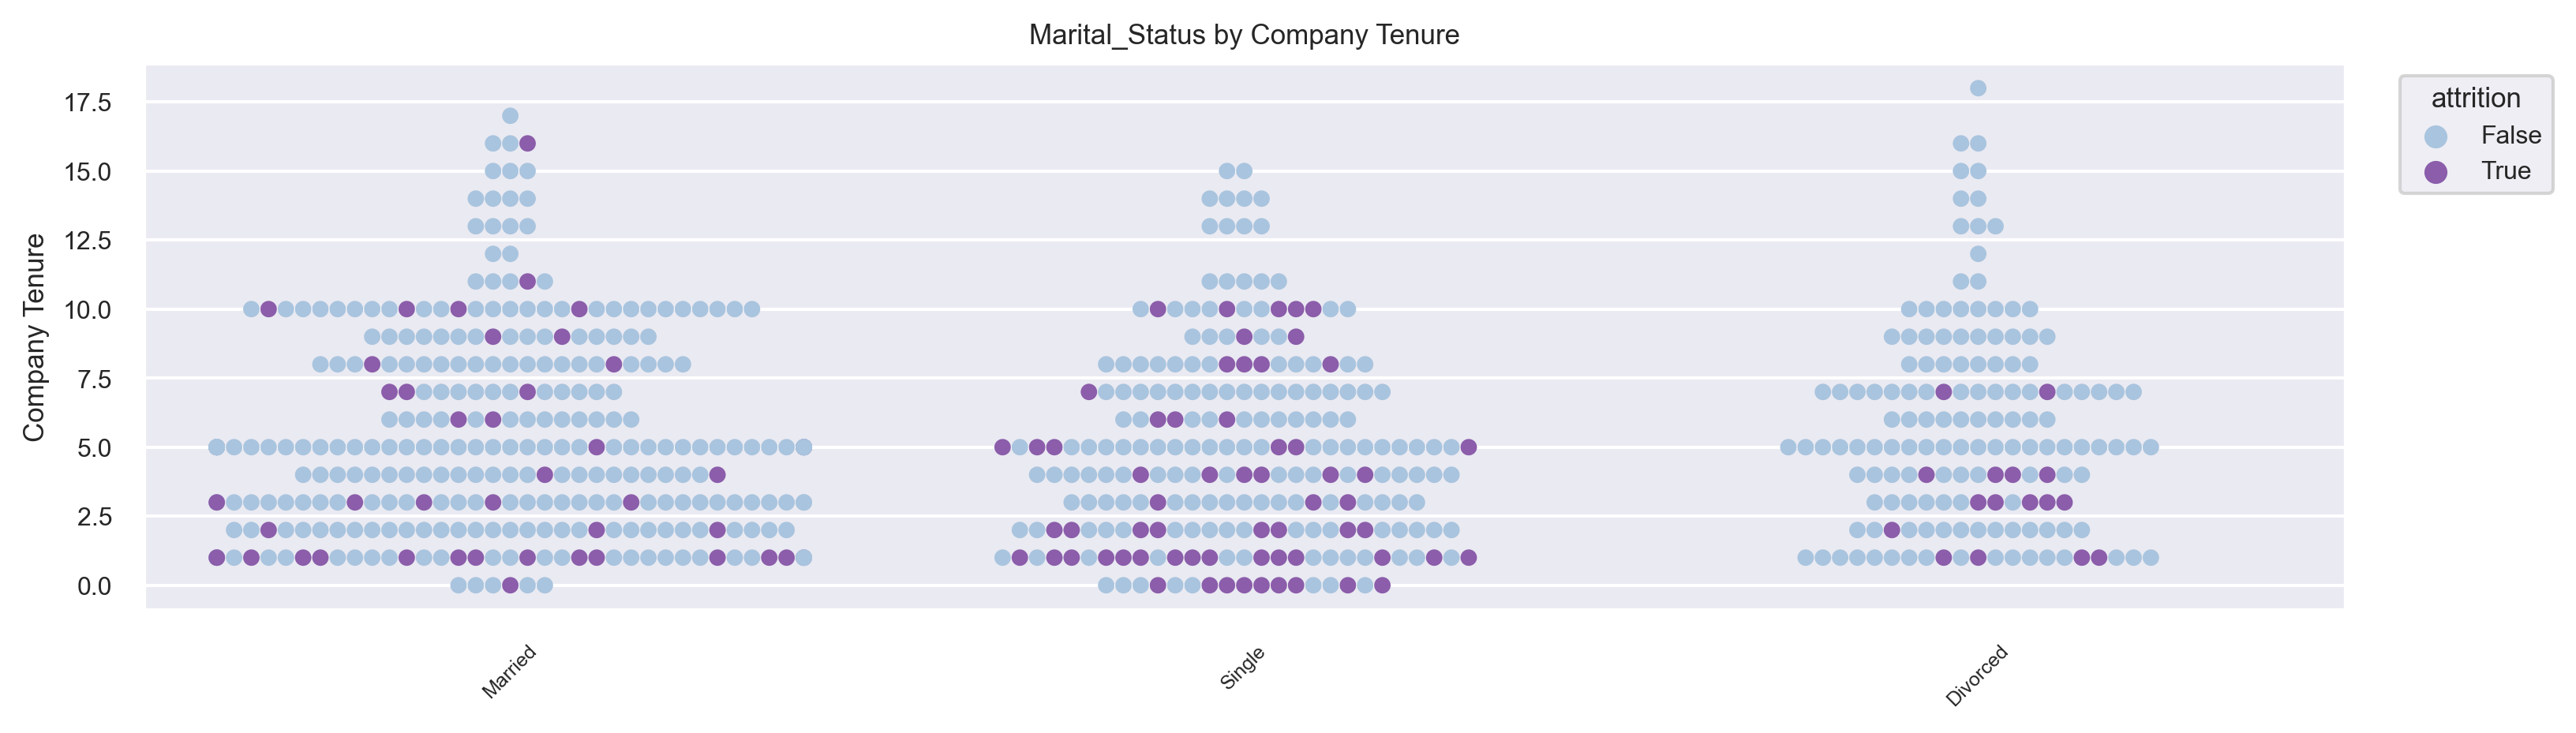

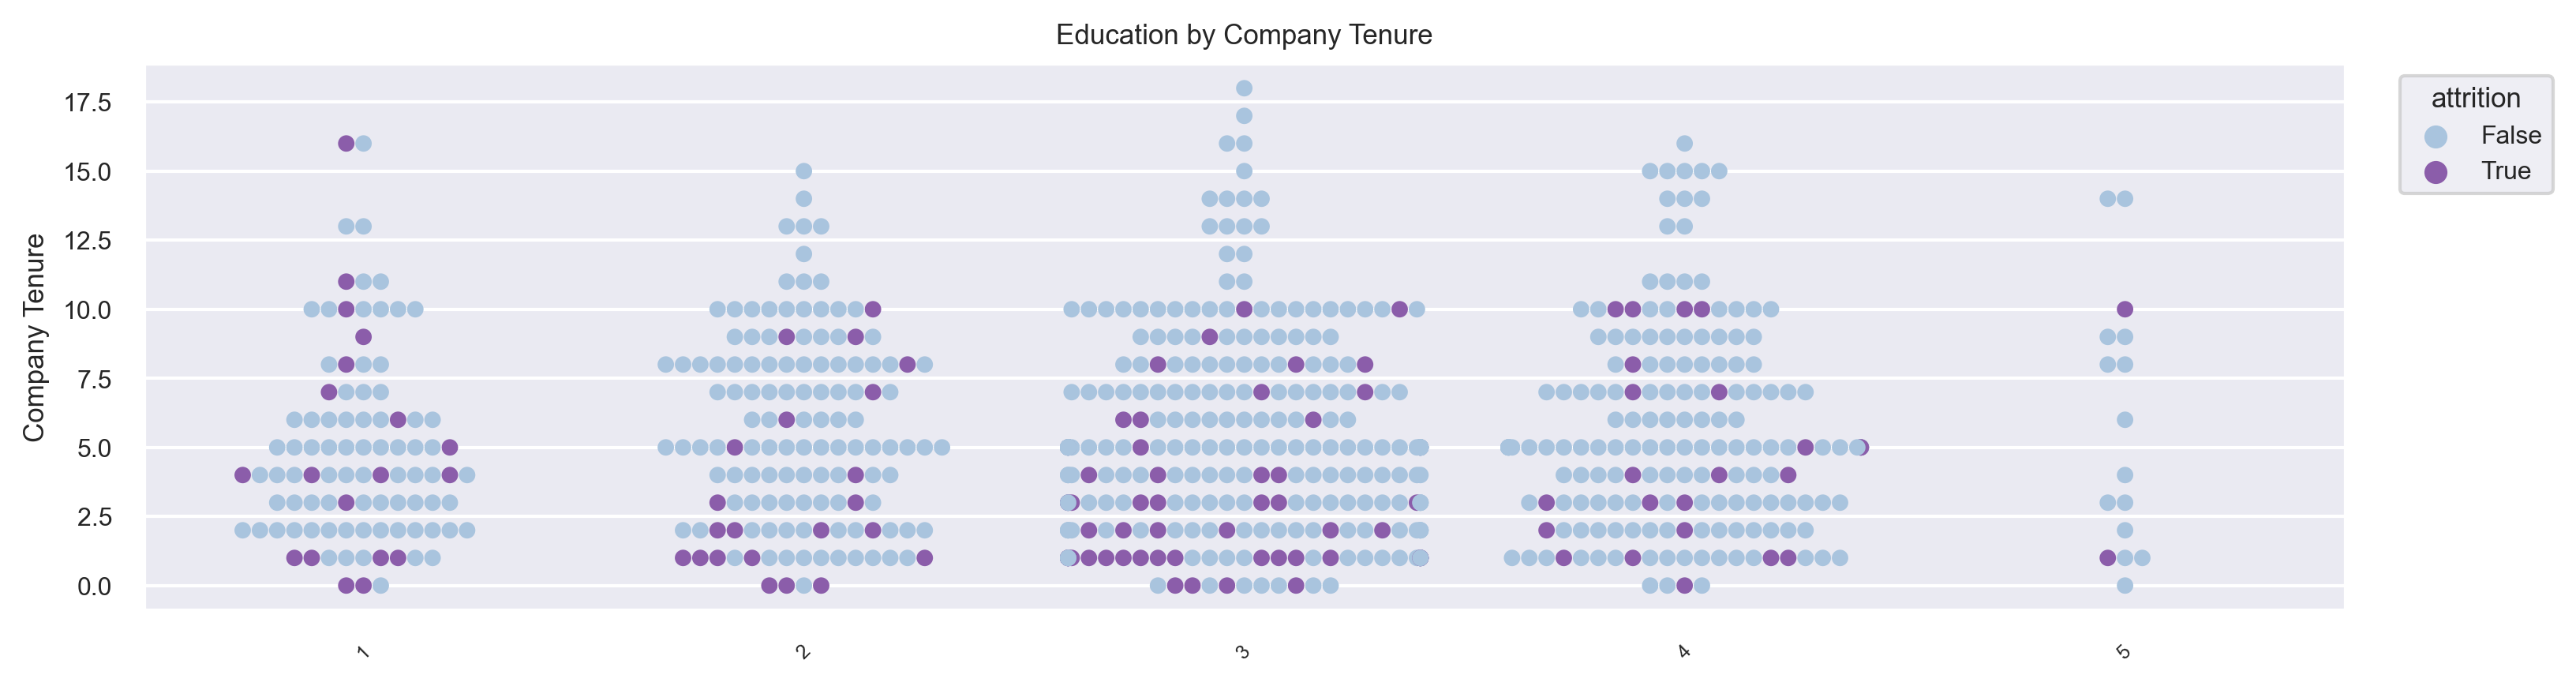

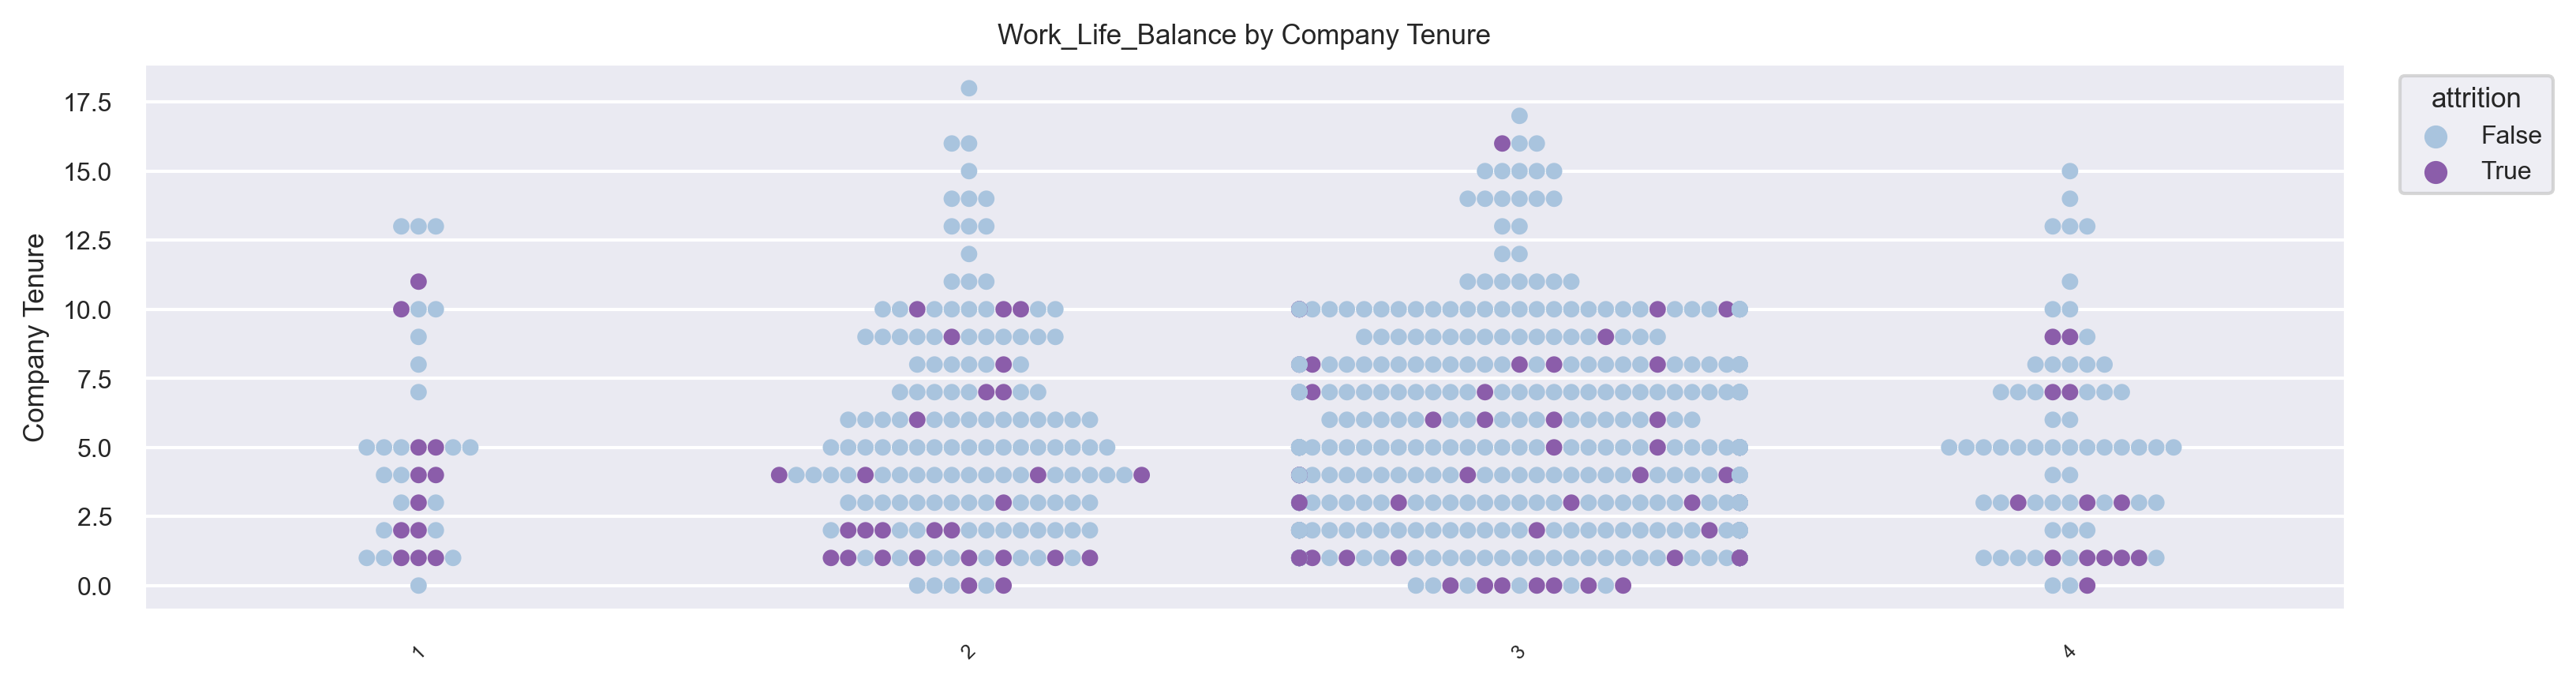

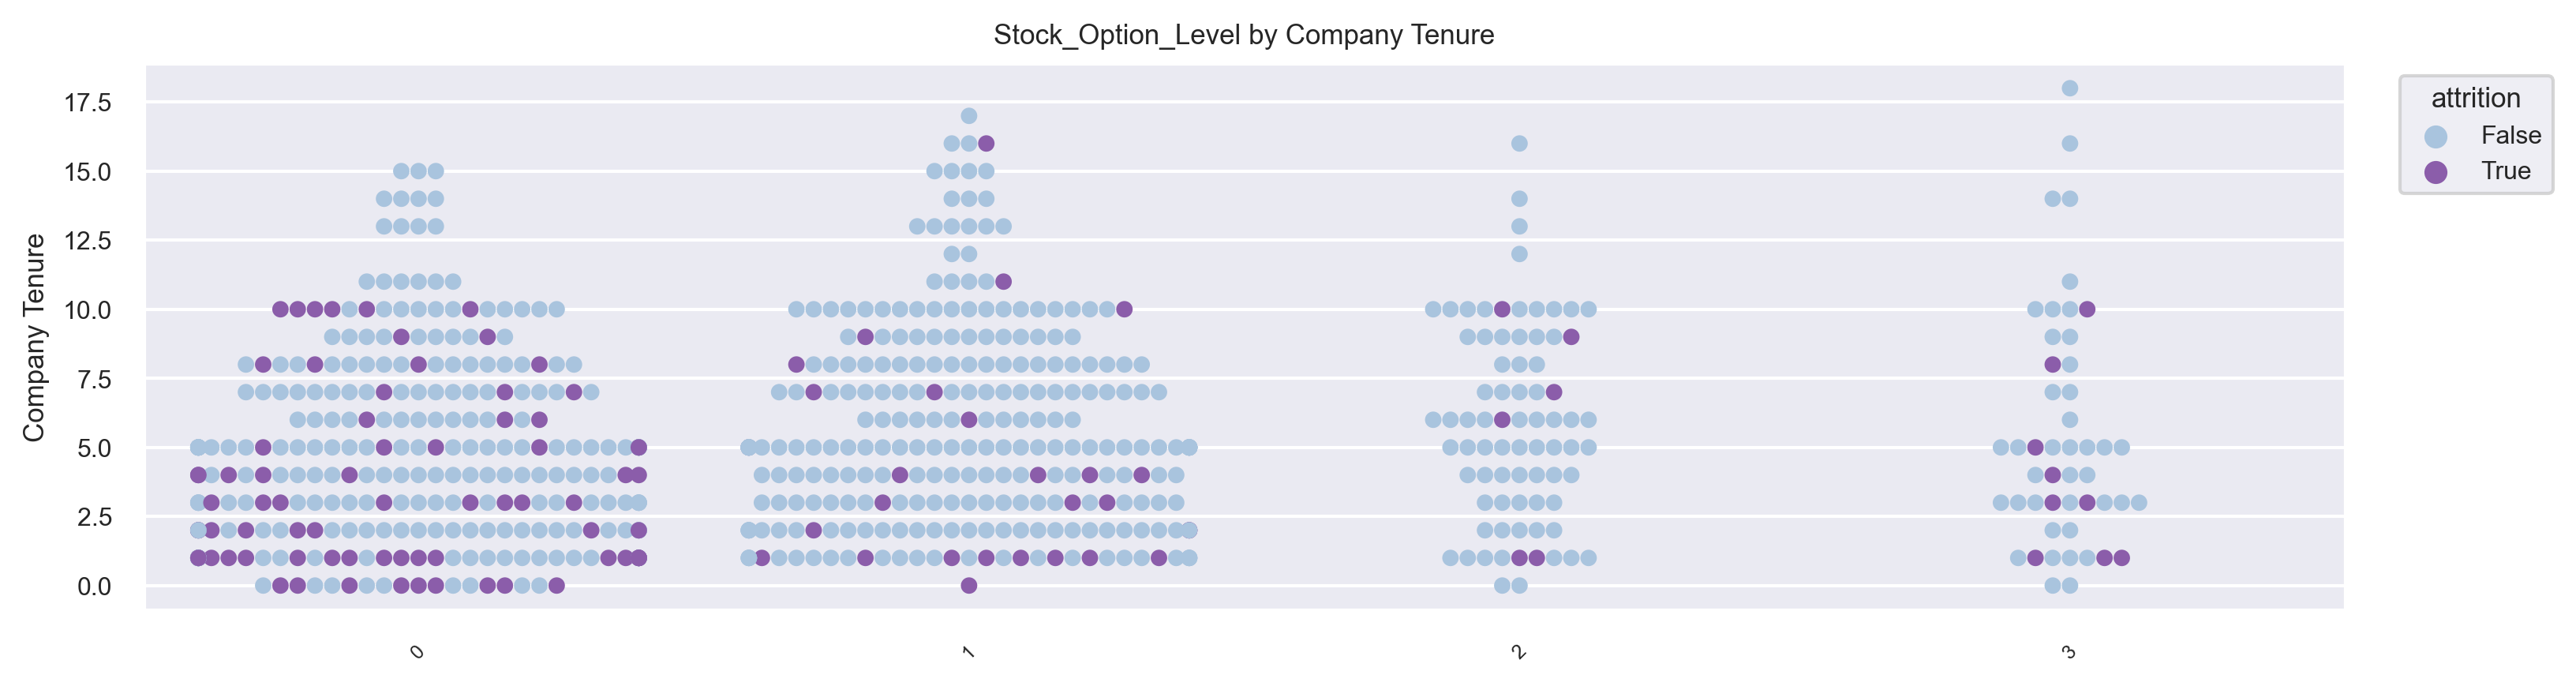

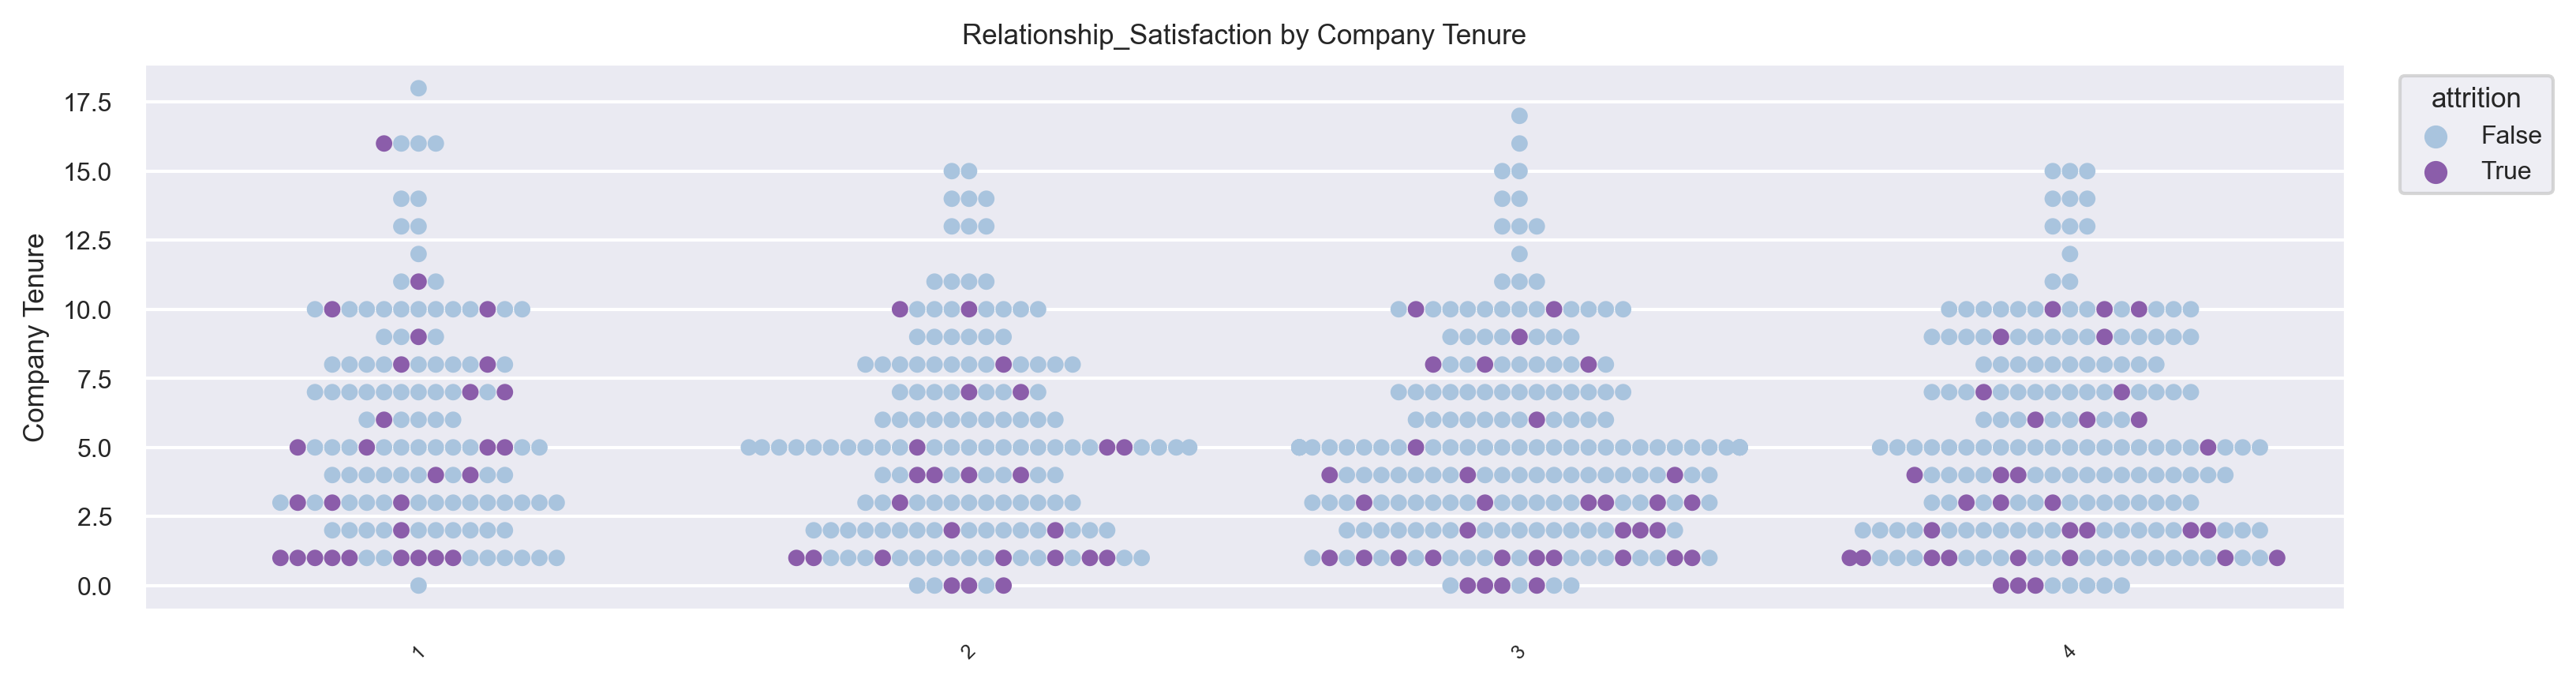

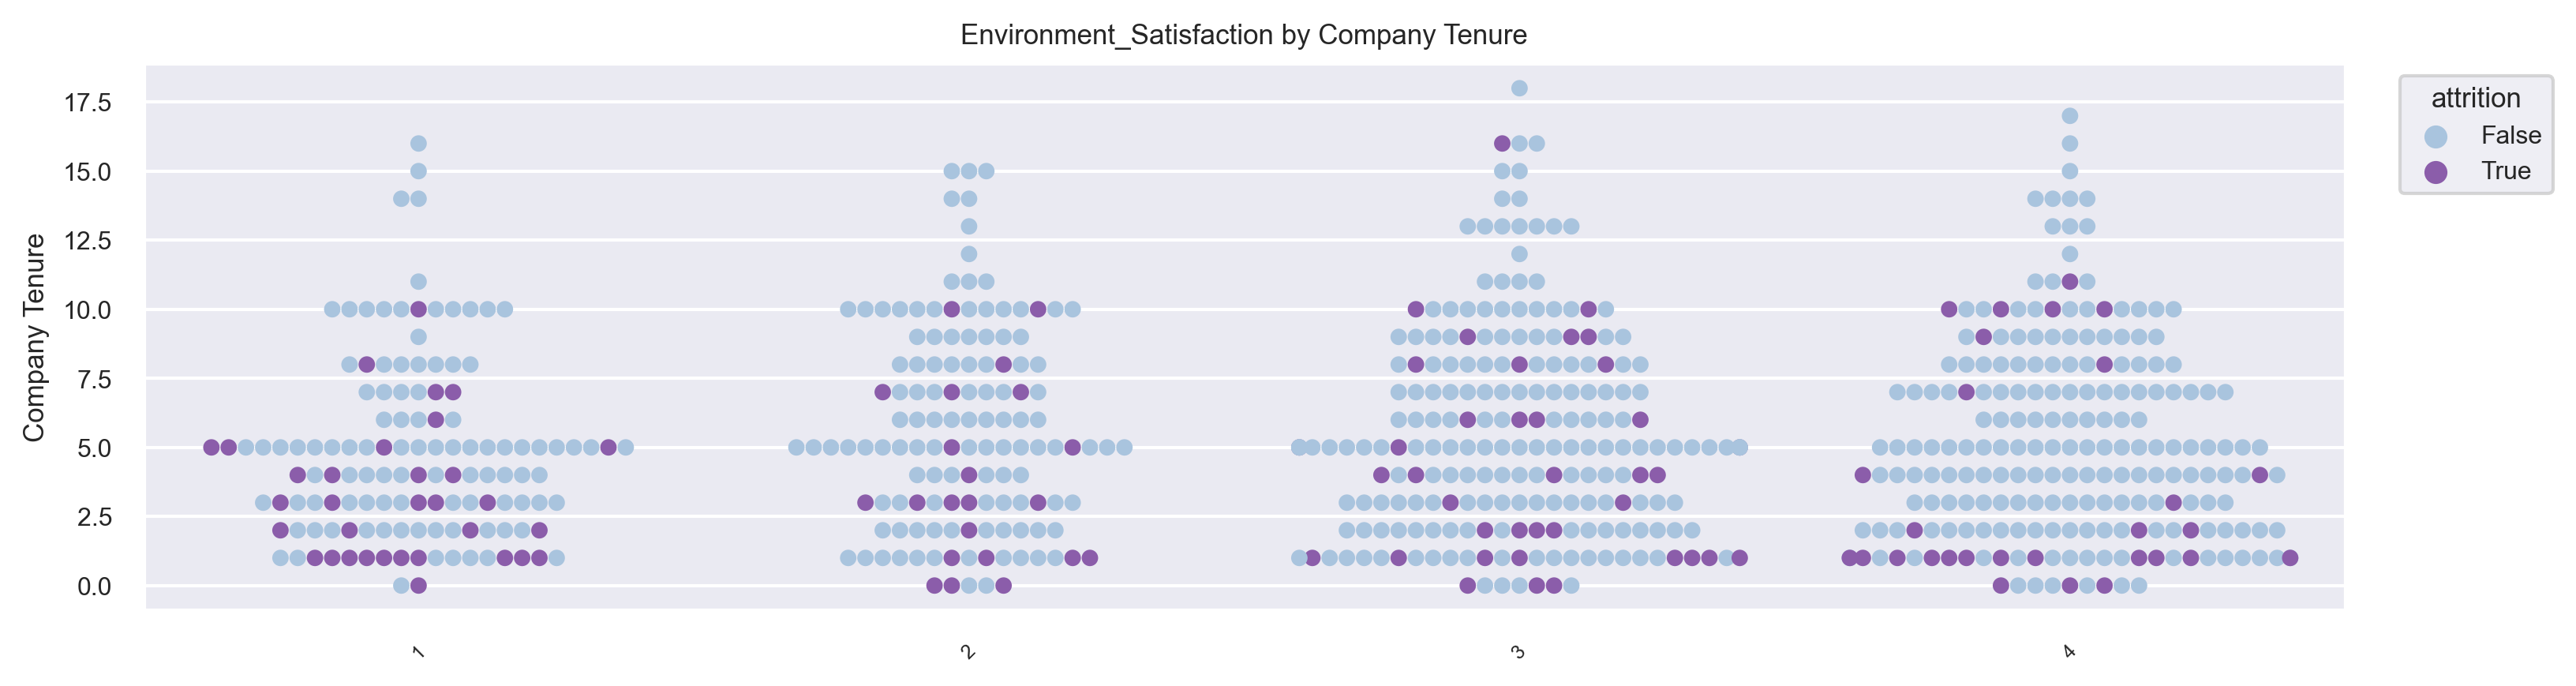

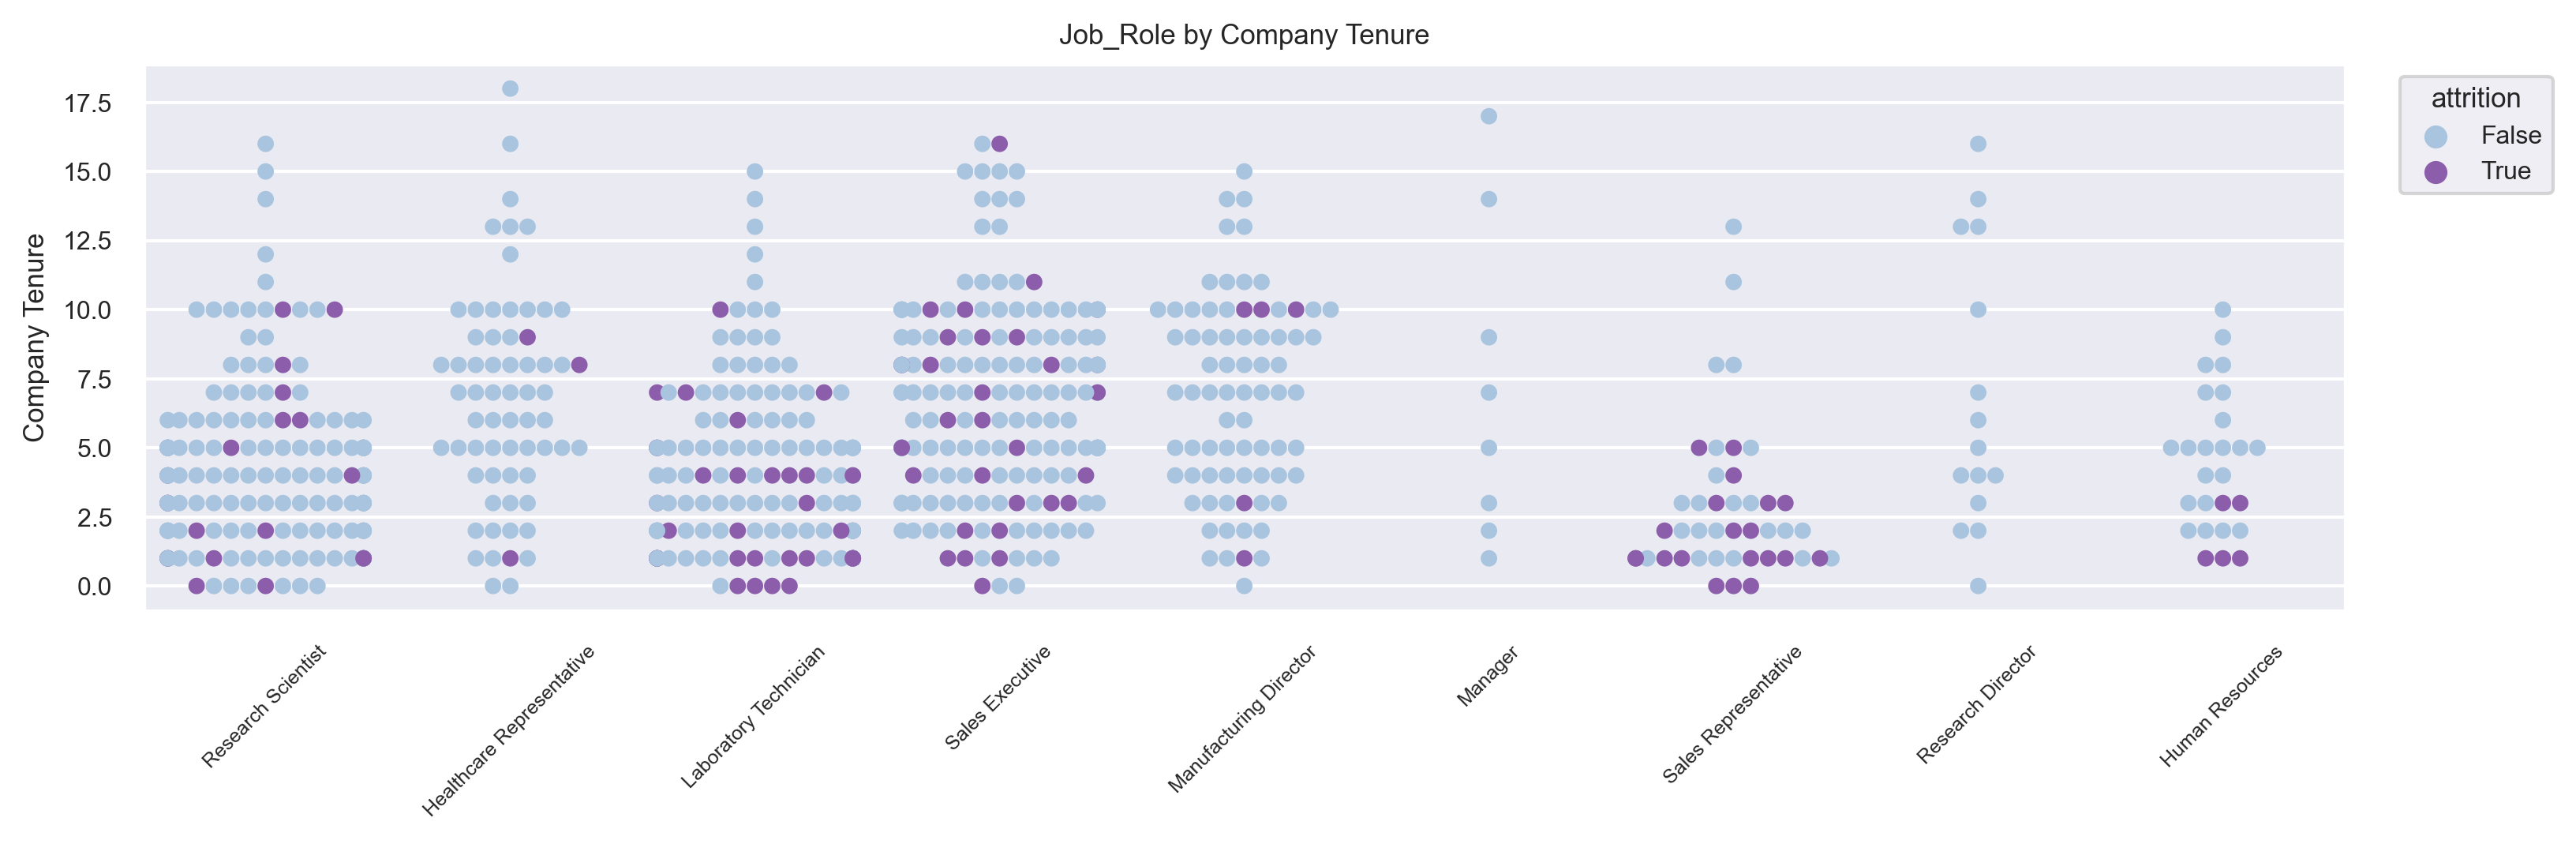

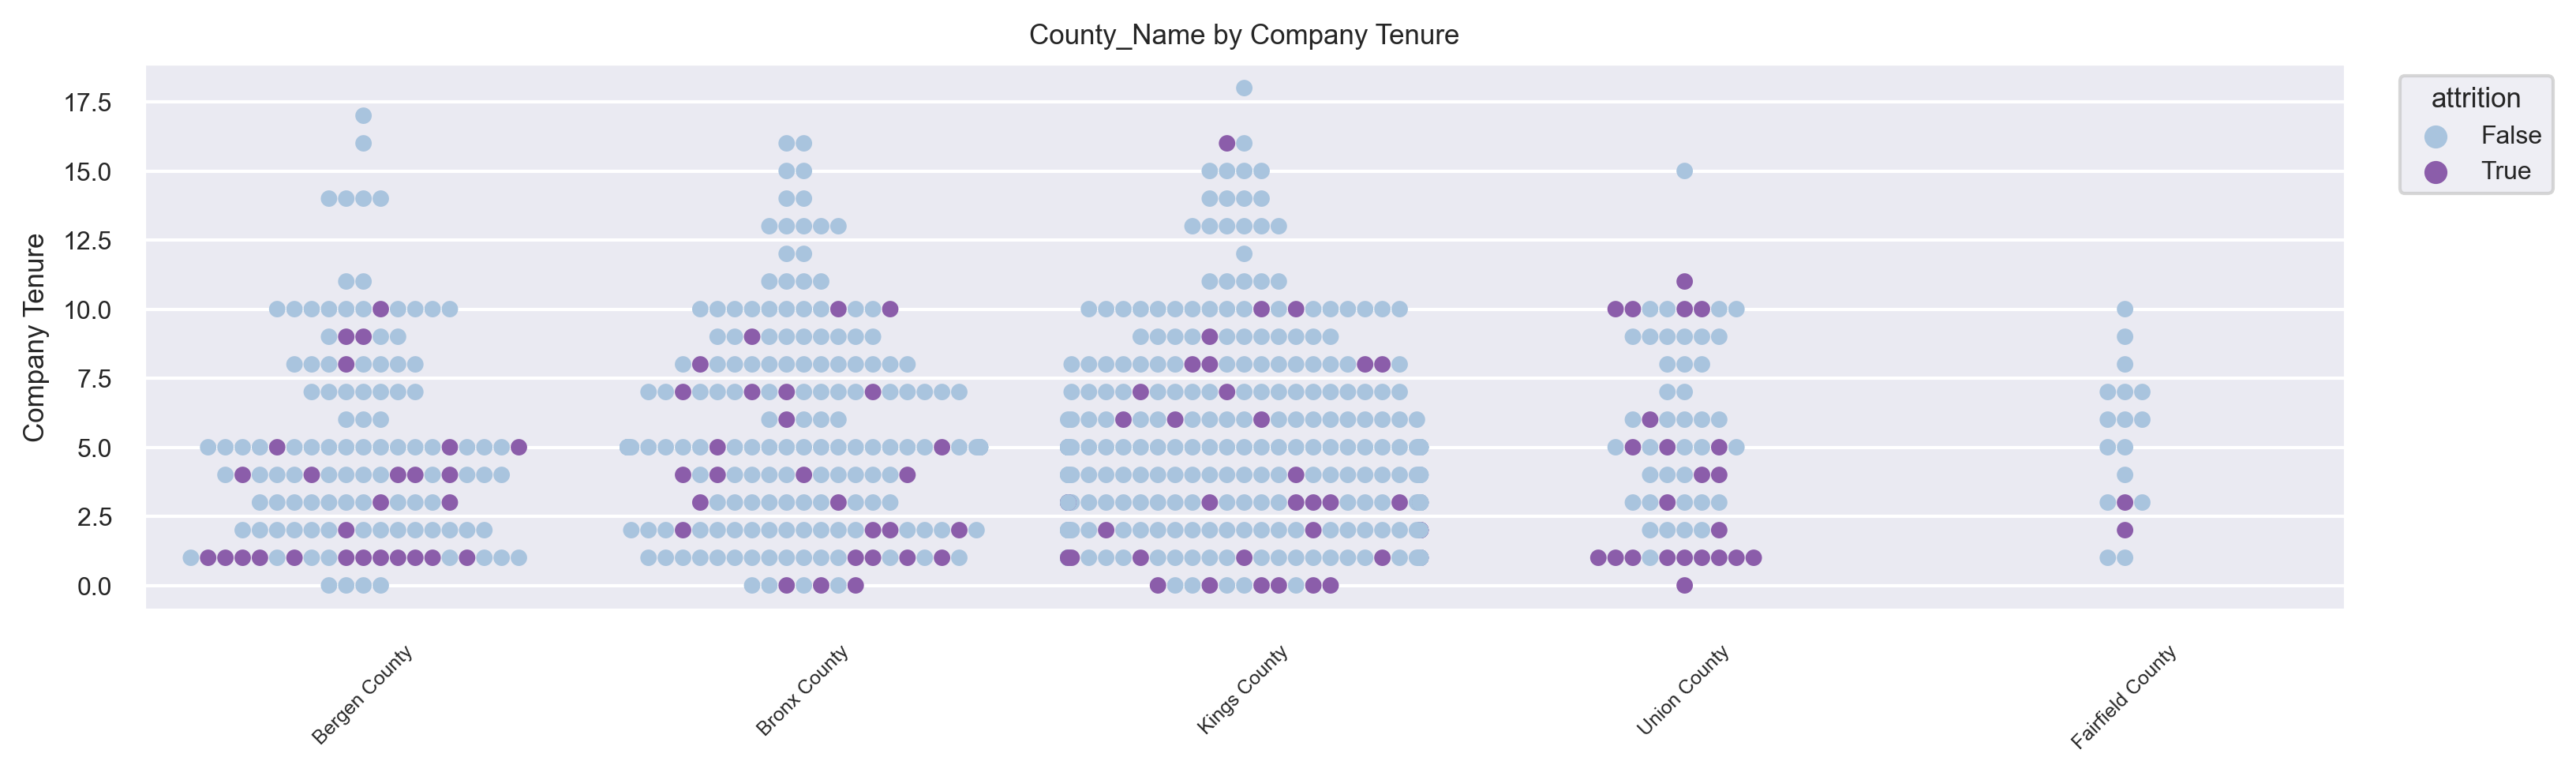

In [25]:
# plotting discrete variable sample by attrition and tenure at the company

disc_sample = [
                'gender',
                'marital_status',
                'education',
                'work_life_balance',
                'stock_option_level',
                'relationship_satisfaction',
                'environment_satisfaction',
                'job_role',
                'county_name']

for col in disc_sample:
    plt.figure(figsize=(12, 3))
    sns.set(font_scale = .7)
    sns.swarmplot(
        x = col, 
        y = "years_at_company", 
        data = train, 
        hue = "attrition", 
        
        palette = "BuPu")

    plt.xlabel(None)
    plt.ylabel("Company Tenure")
    plt.xticks(fontsize = 6, rotation = 45)
    plt.title(f'{col.title()} by Company Tenure')

    plt.legend(
        bbox_to_anchor=(1.1, 1), 
        title = "attrition",
        loc = "upper right")
    plt.show()

In [26]:
# looping through discrete variables and conducting Chi-Squared test on target variable

metrics = []

for col in disc_lst:
    # generating the ChiSquared Test and returning results
    observed = pd.crosstab(index = train[col], columns = train["attrition"], margins = True)

    chi, p_value, degf, exp_values = stats.chi2_contingency(observed)

    if p_value < alpha:
        output = {
            "discrete_feature": col,
            "chi2": chi,
            "degs_of_freedom": degf,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'variable: {col}')
        print('Not statistically significant.')
        print('---------------------------------')

chi2_results = pd.DataFrame(metrics)
chi2_results.round(5)

variable: department
Not statistically significant.
---------------------------------
variable: education
Not statistically significant.
---------------------------------
variable: education_field
Not statistically significant.
---------------------------------
variable: environment_satisfaction
Not statistically significant.
---------------------------------
variable: gender
Not statistically significant.
---------------------------------
variable: job_involvement
Not statistically significant.
---------------------------------
variable: job_satisfaction
Not statistically significant.
---------------------------------
variable: performance_rating
Not statistically significant.
---------------------------------
variable: relationship_satisfaction
Not statistically significant.
---------------------------------
variable: work_life_balance
Not statistically significant.
---------------------------------


discrete_feature    chi2  degs_of_freedom  p_value
0         county_name 20.7215               10   0.0231
1           job_level 28.3985                8   0.0004
2            job_role 50.7249               18   0.0001
3      marital_status 21.8442                6   0.0013
4               state 13.0733                6   0.0419
5  stock_option_level 31.9373                8   0.0001

----

#### **``Summary: Chi_Squared Results``**

After initial discrete/categorical hypotheses testing against the "attrition" target variable - we can conclude that the following features/variables hold a statistical relationship with the target:

- job level
- job role
- marital status
- stock option level

**<u>Follow-up/thoughts after analysis:</u>**

Features such as "job level" and "job role" although initially don't appear to be related, I presume that there may be some relationship amongst an employee's title or role and their salary level at this company. For instance, certain salary levels may only be applicable or tagged to a particular role such as a Research Director or Sales Executive.

I observe that there are only 4 distinct job levels and 9 distinct job roles at this company. In future analysis - I will want to conduct summary statistics and statistical testing across these features to investigate if there is any relationship amongst the independent variables.

In [27]:
# selecting statistically signigicant features for scaling and pre-modeling processing

X_train = prepare.select_stat_variables(X_train)
X_validate = prepare.select_stat_variables(X_validate)
X_test = prepare.select_stat_variables(X_test)

df shape: (688, 16)
df shape: (296, 16)
df shape: (246, 16)


----
#### **``Data Scaling:``**

In [28]:
# pre-scaling df data

X_train.select_dtypes(include = "number").head(2)

employee_age  employment_rates_at_35  high_school_graduation_rate  \
161             56                  0.8025                       0.9408   
1647            27                  0.7417                       0.7783   

      household_income_at_35  monthly_income  percentage_married_by_35  \
161                    63424            4963                    0.5089   
1647                   32542            3517                    0.2223   

      poverty_rate  total_working_years  women_teenage_birthrate  \
161         0.0748                    7                   0.0410   
1647        0.3055                    5                   0.2765   

      years_at_company  years_in_current_role  years_with_curr_manager  
161                  5                      4                        3  
1647                 3                      2                        2

In [29]:
# scaling continuous variables using SKlearn's Standard Scaler

X_train = prepare.scaled_data(X_train)
X_validate = prepare.scaled_data(X_validate)

X_train.select_dtypes(include = "number").head(2)

scaled df shape: (688, 16)
scaled df shape: (296, 16)


employee_age  employment_rates_at_35  high_school_graduation_rate  \
161         2.3606                  1.5048                       1.5345   
1647       -0.9658                 -0.4535                      -1.2238   

      household_income_at_35  monthly_income  percentage_married_by_35  \
161                   1.8010         -0.0531                    1.6471   
1647                 -0.8827         -0.5358                   -1.1946   

      poverty_rate  total_working_years  women_teenage_birthrate  \
161        -1.5344              -0.3594                  -1.6967   
1647        1.1694              -0.7324                   1.1973   

      years_at_company  years_in_current_role  years_with_curr_manager  
161            -0.0803                 0.1864                  -0.1486  
1647           -0.6298                -0.4904                  -0.4773

----
#### **``Assigning and Creating Discrete Feature Dummy Variables``**

In [30]:
# applying created function to return transformed dataframes w. dummy variables for modeling

X_train = prepare.get_dummy_df(X_train)
X_validate = prepare.get_dummy_df(X_validate)

# inspecting the transformed dataframe
X_train.head(2)

dummy df shape: (688, 32)
dummy df shape: (296, 32)


employee_age  employment_rates_at_35  high_school_graduation_rate  \
161         2.3606                  1.5048                       1.5345   
1647       -0.9658                 -0.4535                      -1.2238   

      household_income_at_35  monthly_income  percentage_married_by_35  \
161                   1.8010         -0.0531                    1.6471   
1647                 -0.8827         -0.5358                   -1.1946   

      poverty_rate  total_working_years  women_teenage_birthrate  \
161        -1.5344              -0.3594                  -1.6967   
1647        1.1694              -0.7324                   1.1973   

      years_at_company  ...  job_role_Research Scientist  \
161            -0.0803  ...                         True   
1647           -0.6298  ...                         True   

      job_role_Sales Executive  job_role_Sales Representative  \
161                      False                          False   
1647                     False                          False   

      marital_status_Divorced  marital_status_Married  marital_status_Single  \
161                     False                    True                  False   
1647                    False                    True                  False   

      stock_option_level_0  stock_option_level_1  stock_option_level_2  \
161                  False                 False                 False   
1647                  True                 False                 False   

      stock_option_level_3  
161                   True  
1647                 False  

[2 rows x 32 columns]

#### **``Feature Selection:``**

In [31]:
# Using SKlearn's SelectKBest to view rank feature significance for continuous variables

f_selector = SelectKBest(f_regression, k = 'all')

cont_df = X_train.select_dtypes(include = "number")

# find the top number of independent variables (X's) correlated with y
f_selector.fit(cont_df, y_train)

# boolean mask of whether the column was selected or not
feature_mask = f_selector.get_support()

# get list of top (2) K features. 
f_feature = cont_df.iloc[:,feature_mask].columns.tolist()

feature_lst = pd.DataFrame(f_feature).rename(columns = {0: "continuous_feature"})
feature_lst

continuous_feature
0                  employee_age
1        employment_rates_at_35
2   high_school_graduation_rate
3        household_income_at_35
4                monthly_income
5      percentage_married_by_35
6                  poverty_rate
7           total_working_years
8       women_teenage_birthrate
9              years_at_company
10        years_in_current_role
11      years_with_curr_manager

In [32]:
# Using SKlearn's SelectKBest to view rank feature significance for discrete variables

f_selector = SelectKBest(chi2, k = 'all')

disc_df = X_train.select_dtypes(exclude = "number")

# find the top number of independent variables (X's) correlated with y
f_selector.fit(disc_df, y_train)

# boolean mask of whether the column was selected or not
feature_mask = f_selector.get_support()

# get list of top (2) K features. 
f_feature = disc_df.iloc[:,feature_mask].columns.tolist()

feature_lst = pd.DataFrame(f_feature).rename(columns = {0: "discrete_feature"})
feature_lst

discrete_feature
0                          job_level_1
1                          job_level_2
2                          job_level_3
3                          job_level_4
4   job_role_Healthcare Representative
5             job_role_Human Resources
6       job_role_Laboratory Technician
7                     job_role_Manager
8      job_role_Manufacturing Director
9           job_role_Research Director
10         job_role_Research Scientist
11            job_role_Sales Executive
12       job_role_Sales Representative
13             marital_status_Divorced
14              marital_status_Married
15               marital_status_Single
16                stock_option_level_0
17                stock_option_level_1
18                stock_option_level_2
19                stock_option_level_3

In [33]:
# Using SKlearn's Recursive Feature Elimination - w. Cross Validation (RFECV) to determine best features to model on
# Applying a Random Forest Classifier to determine feature predictive contribution 

rf_features = acquire.retrieve_rfecv_feature_lst()

pd.DataFrame(rf_features).rename(columns = {0: "Features"}).sort_values("Features").reset_index(drop = True)

Features
0                         employee_age
1               employment_rates_at_35
2          high_school_graduation_rate
3               household_income_at_35
4                          job_level_1
5                          job_level_2
6                          job_level_3
7   job_role_Healthcare Representative
8             job_role_Human Resources
9       job_role_Laboratory Technician
10     job_role_Manufacturing Director
11         job_role_Research Scientist
12            job_role_Sales Executive
13       job_role_Sales Representative
14             marital_status_Divorced
15              marital_status_Married
16               marital_status_Single
17                      monthly_income
18            percentage_married_by_35
19                        poverty_rate
20                stock_option_level_0
21                stock_option_level_1
22                stock_option_level_2
23                stock_option_level_3
24                 total_working_years
25             women_teenage_birthrate
26                    years_at_company
27               years_in_current_role
28             years_with_curr_manager

In [34]:
# transforming modeling datasets with RFECV features 

train_model = X_train[rf_features]
validate_model = X_validate[rf_features]

train_model.head(3)

employee_age  employment_rates_at_35  high_school_graduation_rate  \
161         2.3606                  1.5048                       1.5345   
1647       -0.9658                 -0.4535                      -1.2238   
624         1.2135                  1.5048                       1.5345   

      household_income_at_35  job_level_1  job_level_2  job_level_3  \
161                   1.8010         True        False        False   
1647                 -0.8827         True        False        False   
624                   1.8010        False        False         True   

      job_role_Healthcare Representative  job_role_Human Resources  \
161                                False                     False   
1647                               False                     False   
624                                 True                     False   

      job_role_Laboratory Technician  ...  poverty_rate  stock_option_level_0  \
161                            False  ...       -1.5344                 False   
1647                           False  ...        1.1694                  True   
624                            False  ...       -1.5344                  True   

      stock_option_level_1  stock_option_level_2  stock_option_level_3  \
161                  False                 False                  True   
1647                 False                 False                 False   
624                  False                 False                 False   

      total_working_years  women_teenage_birthrate  years_at_company  \
161               -0.3594                  -1.6967           -0.0803   
1647              -0.7324                   1.1973           -0.6298   
624                3.5569                  -1.6967           -0.9046   

      years_in_current_role  years_with_curr_manager  
161                  0.1864                  -0.1486  
1647                -0.4904                  -0.4773  
624                 -0.4904                  -0.4773  

[3 rows x 29 columns]

----
### **``Modeling``**

``Model Class: Decision Tree``

In [35]:
# model 1A: Decision Tree

metrics = []
leaf_counter = 0

for i in range(1, 16):
    # creating the model
    tree = DecisionTreeClassifier(
        min_samples_leaf = (leaf_counter + 1), 
        max_depth = i,
        random_state=548)

    # increasing leaf counter by 1
    leaf_counter += 1

    # fitting the model
    tree = tree.fit(train_model, y_train)

    # applying the model and evaluating its performance on the training dataset
    in_sample_accuracy = tree.score(train_model, y_train)

    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = tree.score(validate_model, y_validate)

    output = {
        "model": "decision_tree", \
        "max_depth": i, \
        "min_sample_leaves": leaf_counter, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.validate_accuracy)
df.round(4)

model  max_depth  min_sample_leaves  train_accuracy  \
0   decision_tree          1                  1          0.8270   
1   decision_tree          2                  2          0.8372   
2   decision_tree          3                  3          0.8445   
3   decision_tree          4                  4          0.8576   
4   decision_tree          5                  5          0.8634   
5   decision_tree          6                  6          0.8648   
6   decision_tree          7                  7          0.8590   
7   decision_tree          8                  8          0.8561   
8   decision_tree          9                  9          0.8561   
9   decision_tree         10                 10          0.8547   
10  decision_tree         11                 11          0.8532   
11  decision_tree         12                 12          0.8459   
12  decision_tree         13                 13          0.8488   
13  decision_tree         14                 14          0.8474   
14  decision_tree         15                 15          0.8474   

    validate_accuracy  percent_change_diff  
0              0.8074               0.0243  
1              0.8142               0.0283  
2              0.8074               0.0459  
3              0.8209               0.0446  
4              0.7838               0.1015  
5              0.7872               0.0987  
6              0.8142               0.0551  
7              0.8041               0.0647  
8              0.8041               0.0647  
9              0.8074               0.0585  
10             0.7973               0.0701  
11             0.7939               0.0655  
12             0.8041               0.0557  
13             0.8108               0.0451  
14             0.8176               0.0365

In [36]:
# model 1B: Decision Tree (reversed sample leaves)

metrics = []
leaf_counter = 21

for i in range(1, 21):
    # creating the model
    tree = DecisionTreeClassifier(
        min_samples_leaf = (leaf_counter - 1), 
        max_depth = i, 
        random_state=548)

    # decreasing leaf counter by 1
    leaf_counter -= 1

    # fitting the model
    tree = tree.fit(train_model, y_train)

    # applying the model and evaluating its performance on the training dataset
    in_sample_accuracy = tree.score(train_model, y_train)

    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = tree.score(validate_model, y_validate)

    output = {
        "model": "decision_tree_reversed", \
        "max_depth": i, \
        "min_sample_leaves": leaf_counter, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.validate_accuracy)
df.round(4)

model  max_depth  min_sample_leaves  train_accuracy  \
0   decision_tree_reversed          1                 20          0.8270   
1   decision_tree_reversed          2                 19          0.8358   
2   decision_tree_reversed          3                 18          0.8372   
3   decision_tree_reversed          4                 17          0.8416   
4   decision_tree_reversed          5                 16          0.8416   
5   decision_tree_reversed          6                 15          0.8474   
6   decision_tree_reversed          7                 14          0.8474   
7   decision_tree_reversed          8                 13          0.8488   
8   decision_tree_reversed          9                 12          0.8459   
9   decision_tree_reversed         10                 11          0.8532   
10  decision_tree_reversed         11                 10          0.8547   
11  decision_tree_reversed         12                  9          0.8605   
12  decision_tree_reversed         13                  8          0.8590   
13  decision_tree_reversed         14                  7          0.8706   
14  decision_tree_reversed         15                  6          0.8735   
15  decision_tree_reversed         16                  5          0.8794   
16  decision_tree_reversed         17                  4          0.9026   
17  decision_tree_reversed         18                  3          0.9230   
18  decision_tree_reversed         19                  2          0.9448   
19  decision_tree_reversed         20                  1          1.0000   

    validate_accuracy  percent_change_diff  
0              0.8074               0.0243  
1              0.8277               0.0097  
2              0.8074               0.0369  
3              0.8074               0.0423  
4              0.8142               0.0336  
5              0.8176               0.0365  
6              0.8108               0.0451  
7              0.8108               0.0469  
8              0.7939               0.0655  
9              0.7939               0.0747  
10             0.8074               0.0585  
11             0.8041               0.0702  
12             0.7939               0.0820  
13             0.7939               0.0966  
14             0.7635               0.1441  
15             0.7568               0.1620  
16             0.7534               0.1981  
17             0.7601               0.2142  
18             0.7466               0.2654  
19             0.7230               0.3832

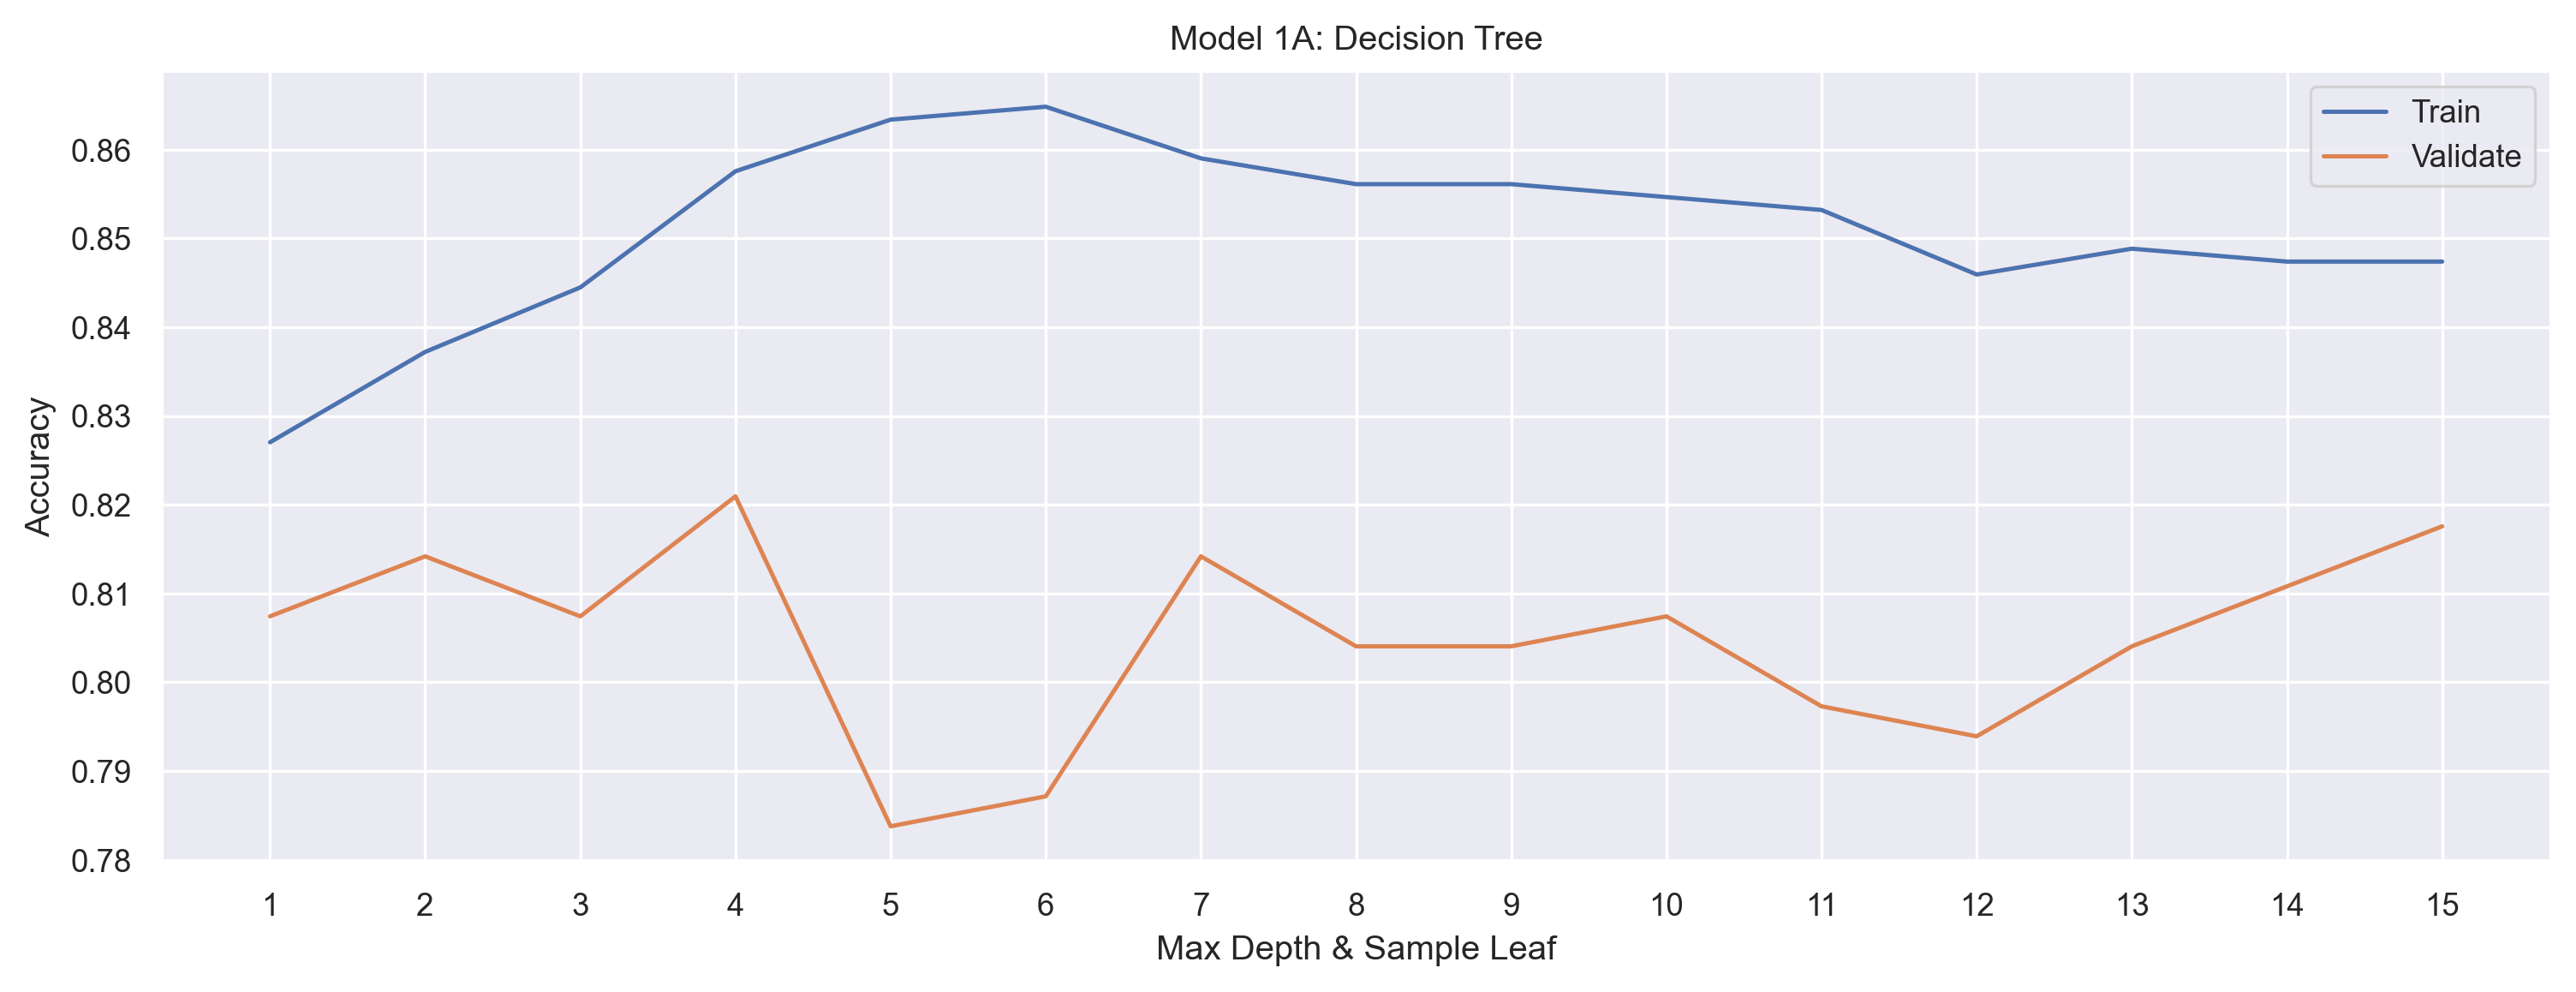

In [37]:
# Decision Tree 1A: comparison across in-sample and out-sample datasets:

sns.set_theme("paper")

i_range = range(1, 16)
train_scores = []
validate_scores = []

for i in i_range:
    tree = DecisionTreeClassifier(
        min_samples_leaf = i, 
        max_depth = i,
        random_state=548)
        
    tree.fit(train_model, y_train)

    train_scores.append(tree.score(train_model, y_train))
    validate_scores.append(tree.score(validate_model, y_validate))


plt.figure(figsize=(12, 4))
plt.title('Model 1A: Decision Tree')
plt.xlabel('Max Depth & Sample Leaf')
plt.ylabel('Accuracy')
plt.plot(i_range, train_scores, label='Train')
plt.plot(i_range, validate_scores, label='Validate')
plt.legend()
plt.xticks(i_range)
plt.show()

``Model Class: K-nearest Neighbor (KNN)``

In [38]:
# model number 2: K-nearest neighbor (KNN)

metrics = []

for k in range(1, 16):
    # creating the model
    knn = KNeighborsClassifier(
                                n_neighbors = k, 
                                weights = 'uniform')

    # fitting the model (on train and only train)
    knn = knn.fit(train_model, y_train)

    # evaluating the model's performance on training dataset
    in_sample_accuracy = knn.score(train_model, y_train)
    
    # evaluating the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = knn.score(validate_model, y_validate)

    output = {
        "num_of_neighbors": k,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy}
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.train_accuracy)
df.round(4)

num_of_neighbors  train_accuracy  validate_accuracy  percent_change_diff
0                  1          1.0000             0.7297               0.2703
1                  2          0.8706             0.8243               0.0532
2                  3          0.8837             0.7905               0.1054
3                  4          0.8590             0.8277               0.0364
4                  5          0.8503             0.8108               0.0464
5                  6          0.8503             0.8345               0.0186
6                  7          0.8503             0.8311               0.0226
7                  8          0.8445             0.8311               0.0159
8                  9          0.8474             0.8209               0.0312
9                 10          0.8401             0.8311               0.0108
10                11          0.8532             0.8243               0.0338
11                12          0.8416             0.8277               0.0165
12                13          0.8445             0.8176               0.0319
13                14          0.8387             0.8176               0.0252
14                15          0.8445             0.8277               0.0199

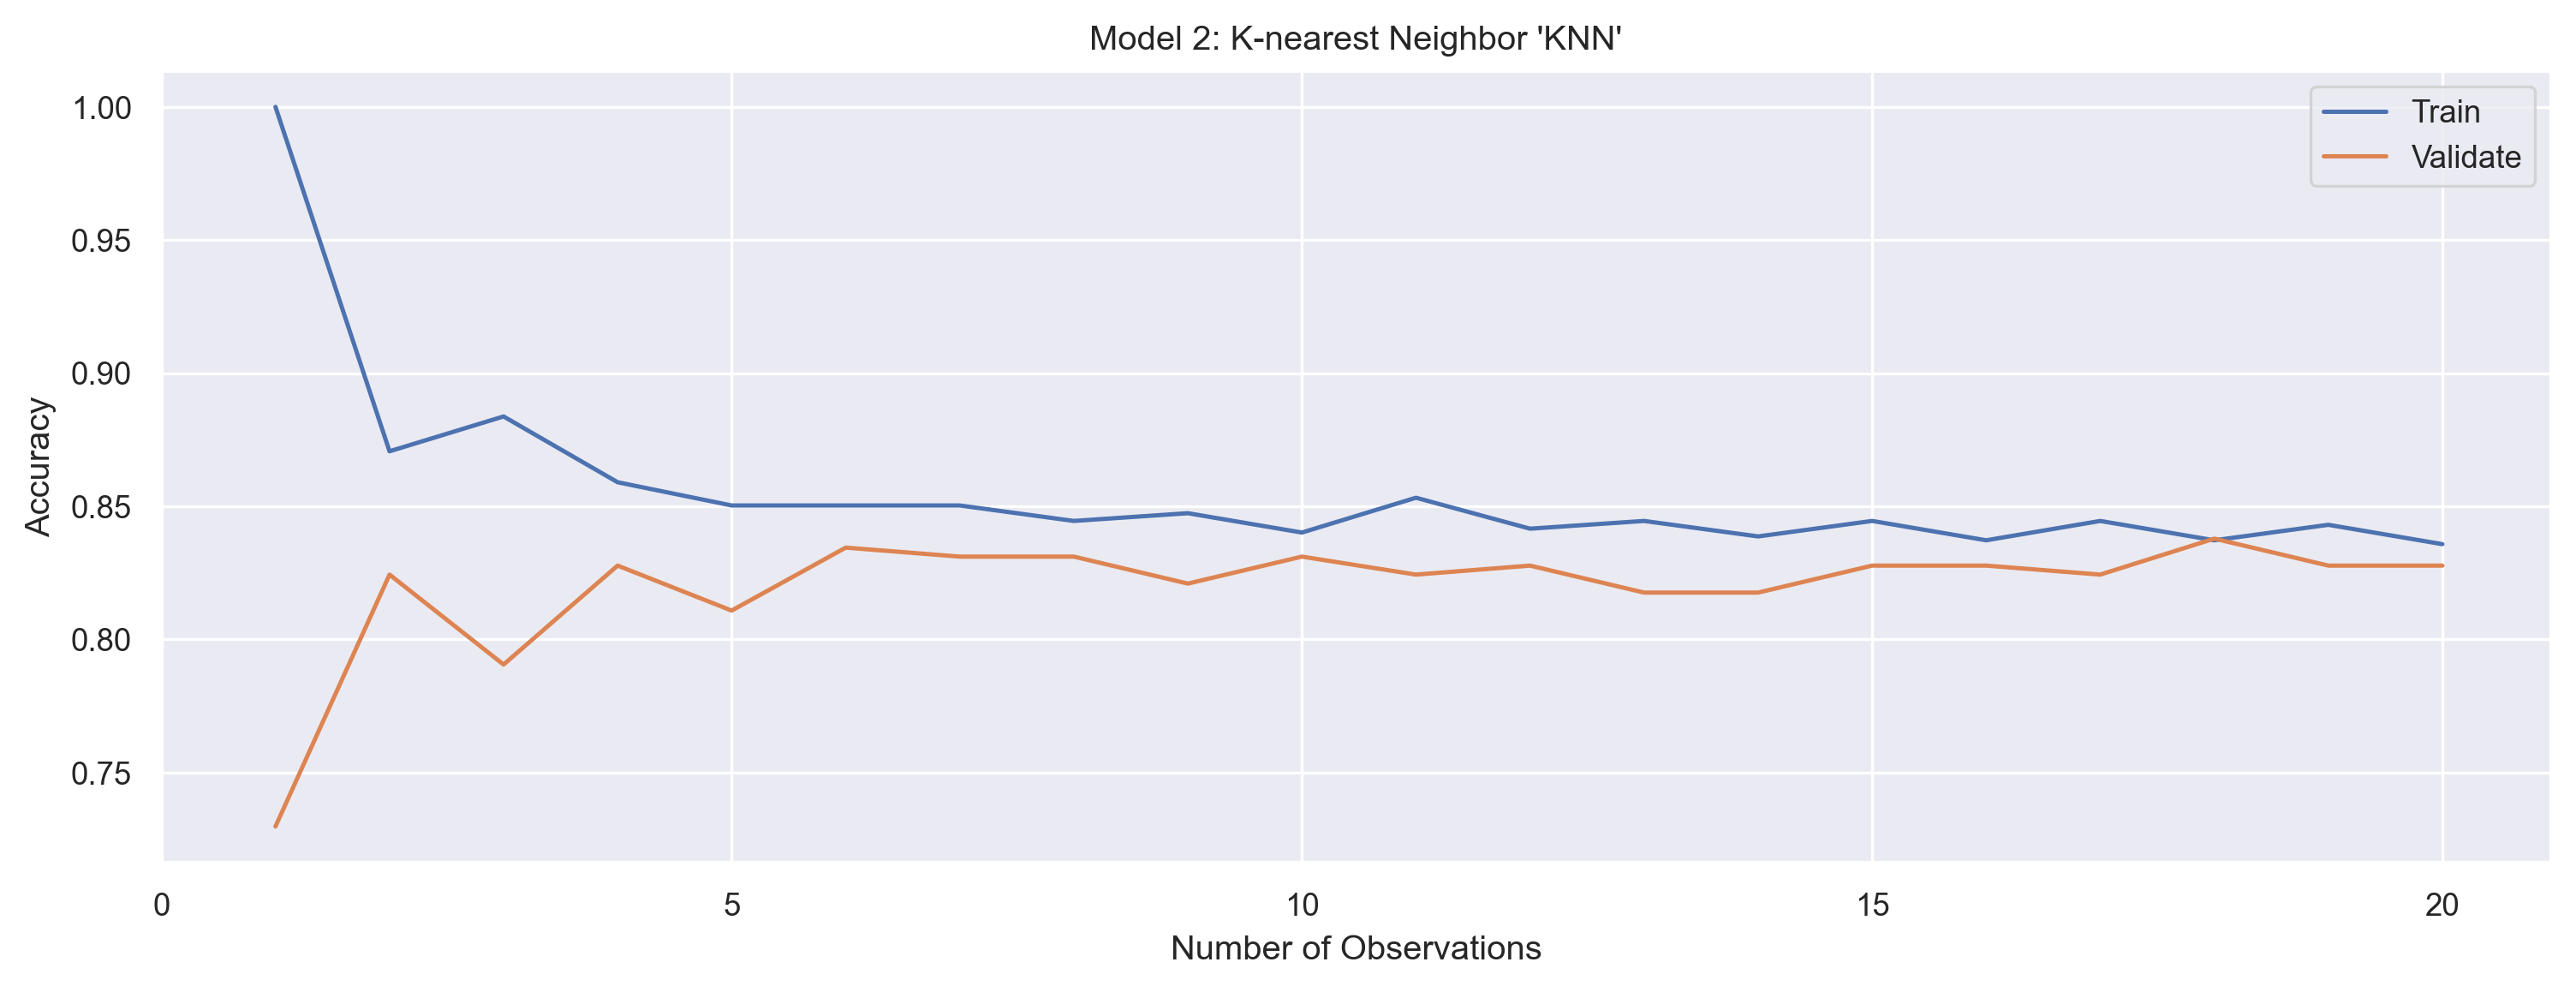

In [39]:
# KNN plot: comparison across in-sample and out-sample datasets:

sns.set_theme("paper")

n_range = range(1, 21)
train_scores = []
validate_scores = []

for n in n_range:
    knn = KNeighborsClassifier(
        n_neighbors = n, 
        weights = 'uniform')

    knn.fit(train_model, y_train)
    train_scores.append(knn.score(train_model, y_train))
    validate_scores.append(knn.score(validate_model, y_validate))

plt.figure(figsize=(12, 4))
plt.title("Model 2: K-nearest Neighbor 'KNN'")
plt.xlabel('Number of Observations')
plt.ylabel('Accuracy')
plt.plot(n_range, train_scores, label='Train')
plt.plot(n_range, validate_scores, label='Validate')
plt.legend()
plt.xticks([0,5,10,15,20])
plt.show()

``Model Class: Logistic Regression``

In [40]:
# model number 3: Logistic Regression

metrics = []

for i in np.linspace(0.1, 1.0, 10):

    # creating the model
    logi = LogisticRegression(
        C = i, 
        random_state=548)

    # fitting the model (on train and only train)
    logi = logi.fit(train_model, y_train)

    # applying the model and evaluating its performance on the training dataset
    in_sample_accuracy = logi.score(train_model, y_train)

    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = logi.score(validate_model, y_validate)

    output = {
        "model": "logi_model", \
        "C_parameter": i, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.validate_accuracy)
df.round(4)

model  C_parameter  train_accuracy  validate_accuracy  \
0  logi_model       0.1000          0.8387             0.8311   
1  logi_model       0.2000          0.8358             0.8345   
2  logi_model       0.3000          0.8343             0.8311   
3  logi_model       0.4000          0.8358             0.8311   
4  logi_model       0.5000          0.8372             0.8345   
5  logi_model       0.6000          0.8358             0.8345   
6  logi_model       0.7000          0.8358             0.8378   
7  logi_model       0.8000          0.8372             0.8412   
8  logi_model       0.9000          0.8372             0.8412   
9  logi_model       1.0000          0.8372             0.8412   

   percent_change_diff  
0               0.0091  
1               0.0016  
2               0.0039  
3               0.0056  
4               0.0033  
5               0.0016  
6              -0.0025  
7              -0.0048  
8              -0.0048  
9              -0.0048

In [41]:
# Logistic Regression Report on Validate

metrics = []

for i in np.linspace(0.1, 1.0, 10):

    # creating the model
    logi = LogisticRegression(
        C = i, 
        random_state=548)

    # fitting the model (on train and only train)
    logi = logi.fit(train_model, y_train)

    # We'll evaluate the model's petreeormance on train, first
    y_predictions = logi.predict(validate_model)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_validate, y_predictions, output_dict=True)
    print(f"With Class Weight: {i.round(2)}")
    print(pd.DataFrame(report))
    
    print()

With Class Weight: 0.1
             False    True  accuracy  macro avg  weighted avg
precision   0.8368  0.6250    0.8311     0.7309        0.7996
recall      0.9877  0.0962    0.8311     0.5419        0.8311
f1-score    0.9060  0.1667    0.8311     0.5363        0.7761
support   244.0000 52.0000    0.8311   296.0000      296.0000

With Class Weight: 0.2
             False    True  accuracy  macro avg  weighted avg
precision   0.8470  0.6000    0.8345     0.7235        0.8036
recall      0.9754  0.1731    0.8345     0.5742        0.8345
f1-score    0.9067  0.2687    0.8345     0.5877        0.7946
support   244.0000 52.0000    0.8345   296.0000      296.0000

With Class Weight: 0.3
             False    True  accuracy  macro avg  weighted avg
precision   0.8464  0.5625    0.8311     0.7045        0.7965
recall      0.9713  0.1731    0.8311     0.5722        0.8311
f1-score    0.9046  0.2647    0.8311     0.5846        0.7922
support   244.0000 52.0000    0.8311   296.0000      296.0000

``Model Class: Random Forest``

In [42]:
# model number 4: Random Forest 

metrics = []
leaf_counter = 21

for i in range(1, 21):
    # Make the model
    rf = RandomForestClassifier(
        min_samples_leaf = (leaf_counter-1), 
        max_depth = i,
        random_state=548)

    # update leaf count
    leaf_counter -= 1

    # Fit the model (on train and only train)
    rf = rf.fit(train_model, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = rf.score(train_model, y_train)
    
    # next, we'll evaluate the model on "out-of-sample" data (validate)
    out_of_sample_accuracy = rf.score(validate_model, y_validate)
    
    output = {
        "model": "rf_classifier",
        "max_depth": i, \
        "num_of_sample_leaf": leaf_counter, \
        "train_accuracy": in_sample_accuracy, \
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["percent_change_diff"] = ((df.train_accuracy - df.validate_accuracy) / df.train_accuracy)
df.round(2)


model  max_depth  num_of_sample_leaf  train_accuracy  \
0   rf_classifier          1                  20          0.8200   
1   rf_classifier          2                  19          0.8300   
2   rf_classifier          3                  18          0.8300   
3   rf_classifier          4                  17          0.8400   
4   rf_classifier          5                  16          0.8400   
5   rf_classifier          6                  15          0.8400   
6   rf_classifier          7                  14          0.8400   
7   rf_classifier          8                  13          0.8400   
8   rf_classifier          9                  12          0.8500   
9   rf_classifier         10                  11          0.8500   
10  rf_classifier         11                  10          0.8500   
11  rf_classifier         12                   9          0.8500   
12  rf_classifier         13                   8          0.8500   
13  rf_classifier         14                   7          0.8500   
14  rf_classifier         15                   6          0.8600   
15  rf_classifier         16                   5          0.8600   
16  rf_classifier         17                   4          0.8700   
17  rf_classifier         18                   3          0.8900   
18  rf_classifier         19                   2          0.9200   
19  rf_classifier         20                   1          1.0000   

    validate_accuracy  percent_change_diff  
0              0.8200              -0.0000  
1              0.8200               0.0000  
2              0.8300               0.0100  
3              0.8300               0.0100  
4              0.8300               0.0100  
5              0.8300               0.0100  
6              0.8300               0.0200  
7              0.8200               0.0300  
8              0.8300               0.0200  
9              0.8300               0.0200  
10             0.8300               0.0200  
11             0.8300               0.0200  
12             0.8400               0.0200  
13             0.8300               0.0200  
14             0.8300               0.0300  
15             0.8300               0.0300  
16             0.8300               0.0400  
17             0.8200               0.0700  
18             0.8200               0.1100  
19             0.8200               0.1800

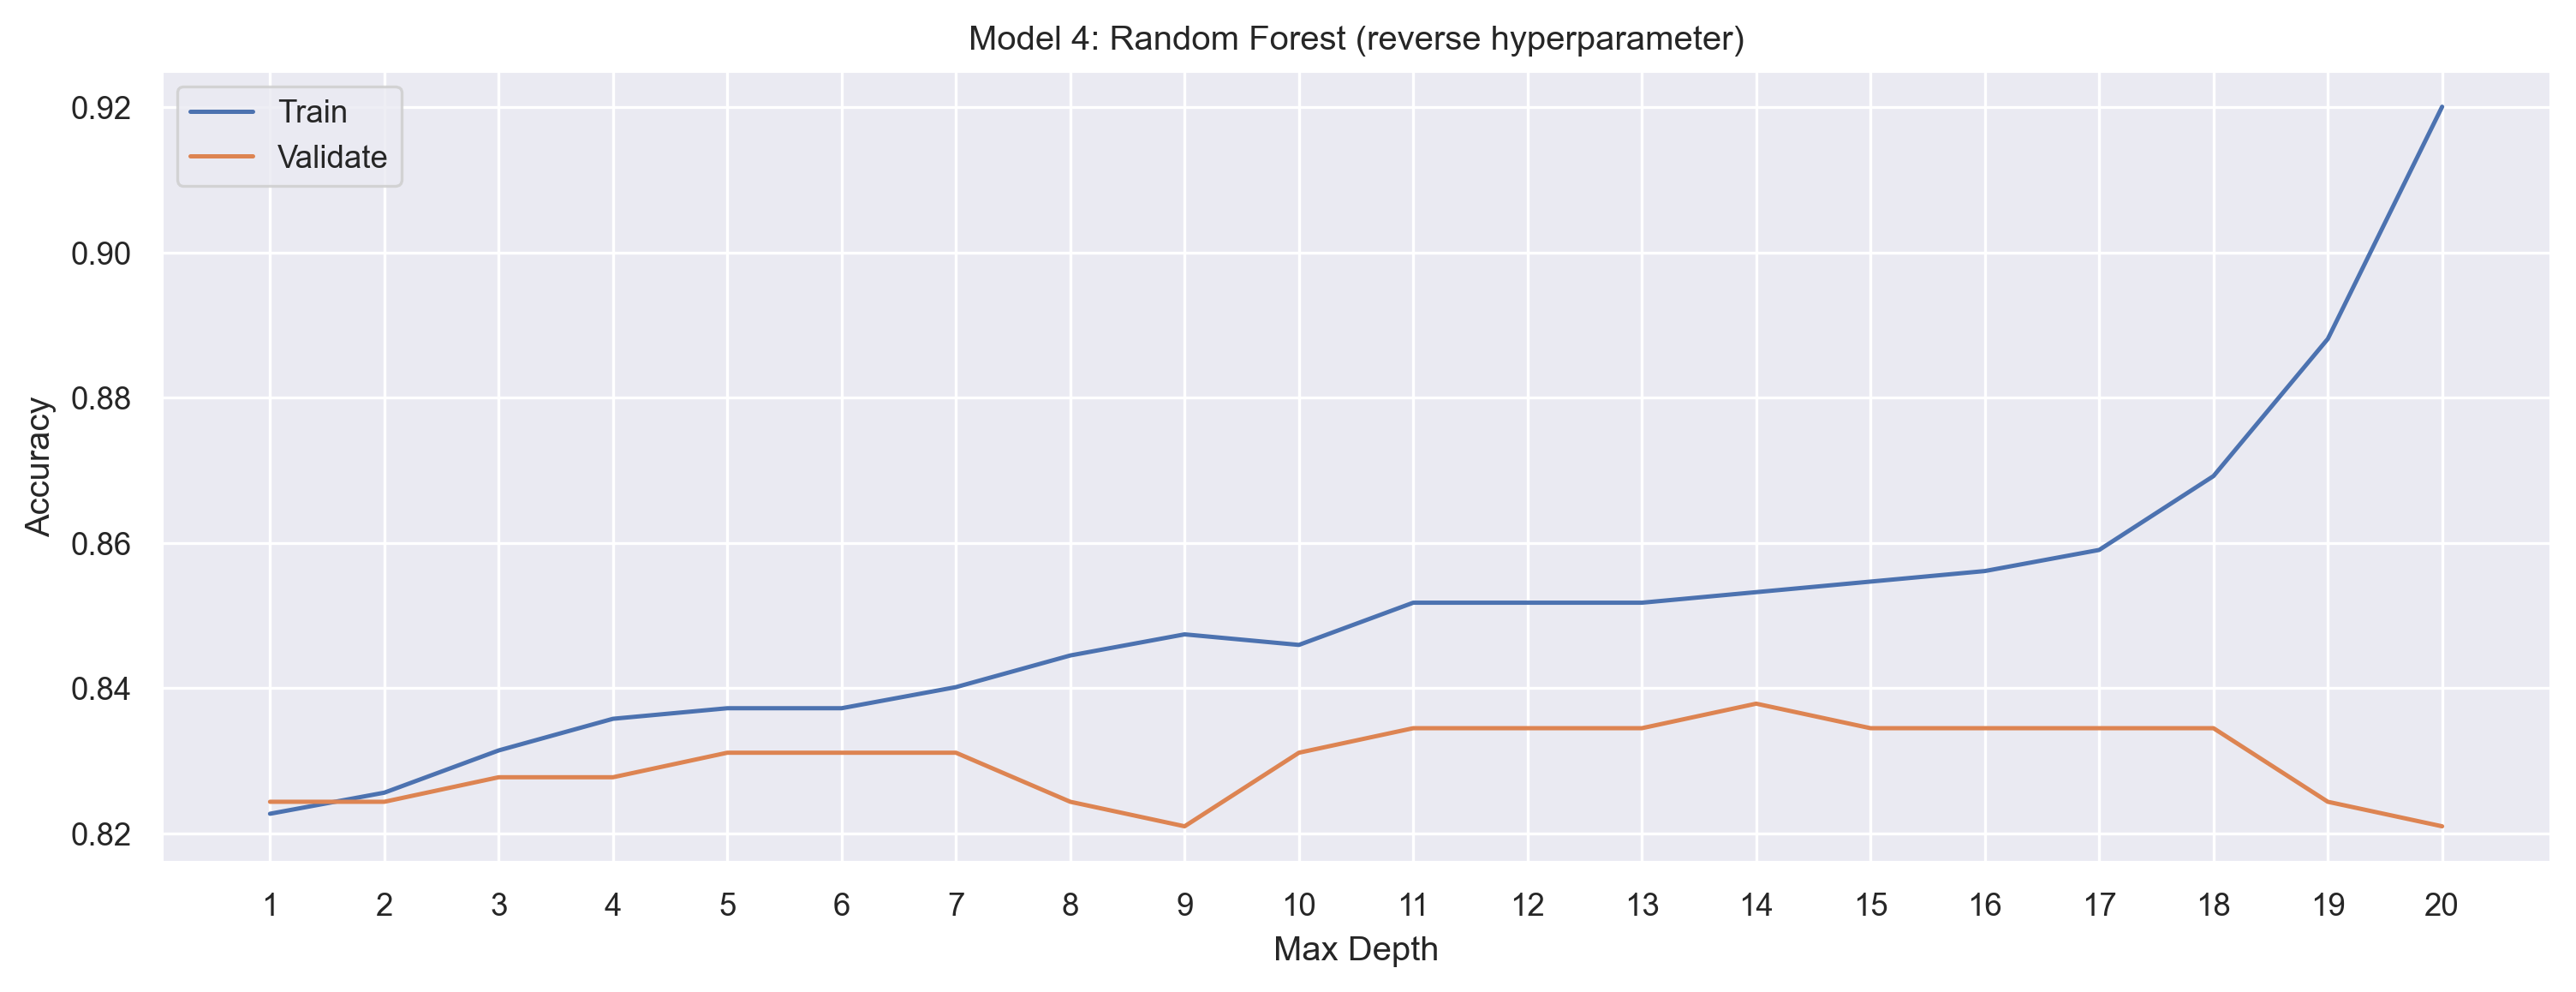

In [43]:
# Random Forest plot: comparison across in-sample and out-sample datasets:

sns.set_theme("paper")

i_range = range(1, 21)
leaf_counter = 21
train_scores = []
validate_scores = []

for i in i_range:
    rf = RandomForestClassifier(
        min_samples_leaf = leaf_counter, 
        max_depth = i,
        random_state=548)
        
    # update leaf counter
    leaf_counter -= 1

    rf.fit(train_model, y_train)

    train_scores.append(rf.score(train_model, y_train))
    validate_scores.append(rf.score(validate_model, y_validate))


plt.figure(figsize=(12, 4))
plt.title('Model 4: Random Forest (reverse hyperparameter)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(i_range, train_scores, label='Train')
plt.plot(i_range, validate_scores, label='Validate')
plt.legend()
plt.xticks(i_range)
plt.show()

----
#### **``Summary: Modeling``**

After comparing all six (6) unique models, I concluded that the following models resulted in the best predictive overall accuracy performance:

**Logistic Regression (1): C = 1.0**

- ~84% predictive accuracy
- relative training set diff. ~0%

**Logistic Regression (2): C = 0.9**

- ~84% predictive accuracy
- relative training set diff. ~%0

**Decision Tree (1): depth of 13, and min sample leaf of 13**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**Decision Tree (2): depth of 7, and min sample leaf of 14**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**Random Forest: depth of 7, and min sample leaf of 14**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**K-nearest Neighbor (KNN): k = 4**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

**K-nearest Neighbor (KNN): k = 10**

- ~84% predictive accuracy
- relative training set diff. ~1% (+)

-----

**<u>``Model Evaluation``</u>**

After evaluating all the models tested, I chose to deploy the Logistic Regression model for the following reasons:

- Ease of understanding/interpretation
- May be most flexible to deploy/maintain over time
    - Compared to decision tree or random forest models, the logistic regression model may be less dependent on commonly collected information

In [44]:
# deploying the Logistic Regression w/C of 1.0 on Test Dataset
# scaling the test dataset

X_test = prepare.scaled_data(X_test)
X_test.head(3)

scaled df shape: (246, 16)


job_level                   job_role marital_status stock_option_level  \
1763         2  Healthcare Representative        Married                  1   
1954         2  Healthcare Representative        Married                  1   
1301         1         Research Scientist         Single                  0   

      employee_age  employment_rates_at_35  high_school_graduation_rate  \
1763       -0.5243                  1.5706                       1.6193   
1954       -0.6493                 -0.7487                      -0.1753   
1301       -0.7743                 -0.7487                      -0.1753   

      household_income_at_35  monthly_income  percentage_married_by_35  \
1763                  1.9412          0.1054                    1.7572   
1954                 -0.4358          0.1343                   -0.1766   
1301                 -0.4358         -1.0677                   -0.1766   

      poverty_rate  total_working_years  women_teenage_birthrate  \
1763       -1.6189               0.3040                  -1.8183   
1954        0.2320              -0.5067                   0.1518   
1301        0.2320              -0.7093                   0.1518   

      years_at_company  years_in_current_role  years_with_curr_manager  
1763            0.3804                -1.1350                   1.1656  
1954           -0.1338                -0.1755                  -0.4785  
1301           -0.6480                -0.4953                  -0.4785

In [45]:
# assigning dummy variables

X_test = prepare.get_dummy_df(X_test)
X_test.head(3)

dummy df shape: (246, 32)


employee_age  employment_rates_at_35  high_school_graduation_rate  \
1763       -0.5243                  1.5706                       1.6193   
1954       -0.6493                 -0.7487                      -0.1753   
1301       -0.7743                 -0.7487                      -0.1753   

      household_income_at_35  monthly_income  percentage_married_by_35  \
1763                  1.9412          0.1054                    1.7572   
1954                 -0.4358          0.1343                   -0.1766   
1301                 -0.4358         -1.0677                   -0.1766   

      poverty_rate  total_working_years  women_teenage_birthrate  \
1763       -1.6189               0.3040                  -1.8183   
1954        0.2320              -0.5067                   0.1518   
1301        0.2320              -0.7093                   0.1518   

      years_at_company  ...  job_role_Research Scientist  \
1763            0.3804  ...                        False   
1954           -0.1338  ...                        False   
1301           -0.6480  ...                         True   

      job_role_Sales Executive  job_role_Sales Representative  \
1763                     False                          False   
1954                     False                          False   
1301                     False                          False   

      marital_status_Divorced  marital_status_Married  marital_status_Single  \
1763                    False                    True                  False   
1954                    False                    True                  False   
1301                    False                   False                   True   

      stock_option_level_0  stock_option_level_1  stock_option_level_2  \
1763                 False                  True                 False   
1954                 False                  True                 False   
1301                  True                 False                 False   

      stock_option_level_3  
1763                 False  
1954                 False  
1301                 False  

[3 rows x 32 columns]

In [46]:
# selecting features to model on

test_model = X_test[rf_features]
test_model.head(3)

employee_age  employment_rates_at_35  high_school_graduation_rate  \
1763       -0.5243                  1.5706                       1.6193   
1954       -0.6493                 -0.7487                      -0.1753   
1301       -0.7743                 -0.7487                      -0.1753   

      household_income_at_35  job_level_1  job_level_2  job_level_3  \
1763                  1.9412        False         True        False   
1954                 -0.4358        False         True        False   
1301                 -0.4358         True        False        False   

      job_role_Healthcare Representative  job_role_Human Resources  \
1763                                True                     False   
1954                                True                     False   
1301                               False                     False   

      job_role_Laboratory Technician  ...  poverty_rate  stock_option_level_0  \
1763                           False  ...       -1.6189                 False   
1954                           False  ...        0.2320                 False   
1301                           False  ...        0.2320                  True   

      stock_option_level_1  stock_option_level_2  stock_option_level_3  \
1763                  True                 False                 False   
1954                  True                 False                 False   
1301                 False                 False                 False   

      total_working_years  women_teenage_birthrate  years_at_company  \
1763               0.3040                  -1.8183            0.3804   
1954              -0.5067                   0.1518           -0.1338   
1301              -0.7093                   0.1518           -0.6480   

      years_in_current_role  years_with_curr_manager  
1763                -1.1350                   1.1656  
1954                -0.1755                  -0.4785  
1301                -0.4953                  -0.4785  

[3 rows x 29 columns]

In [47]:
# creating the model and scoring against all three datasets

# Logistic Regression model
logi_final = LogisticRegression(
            C = 1, 
            random_state=548)

# fitting the model (on train dataset)
logi_final = logi_final.fit(train_model, y_train)

# applying the model and evaluating its performance on all three (3) datasets

train_accuracy = logi_final.score(train_model, y_train)
validate_accuracy = logi_final.score(validate_model, y_validate)
test_accuracy = logi_final.score(test_model, y_test)

In [48]:
# returning final results including relative difference test dataset 

train_diff = (baseline_train - train_accuracy)/train_accuracy
val_diff = (train_accuracy - validate_accuracy)/validate_accuracy
test_diff = (validate_accuracy - test_accuracy)/test_accuracy

pd.DataFrame({
    'dataset': ["baseline", "train", "validate", "test (final)"], 
    "accuracy": [baseline_train, train_accuracy, validate_accuracy, test_accuracy], 
    "relative_difference": [0, train_diff, val_diff, test_diff]})

dataset  accuracy  relative_difference
0      baseline    0.8227               0.0000
1         train    0.8372              -0.0173
2      validate    0.8412              -0.0048
3  test (final)    0.8252               0.0194

In [49]:
# generating predictions 

predictions = logi_final.predict(test_model)
predictions[0:21]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [50]:
# calculating accuracies 

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
ALL = TP + FP + FN + TN

print(f'Accuracy: {((TN+TP)/ALL).round(3)}')
print(f'True Negative: {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print(f'True Positive: {TP}')

Accuracy: 0.825
True Negative: 195
False Positive: 8
False Negative: 35
True Positive: 8


<Figure size 1500x900 with 0 Axes>

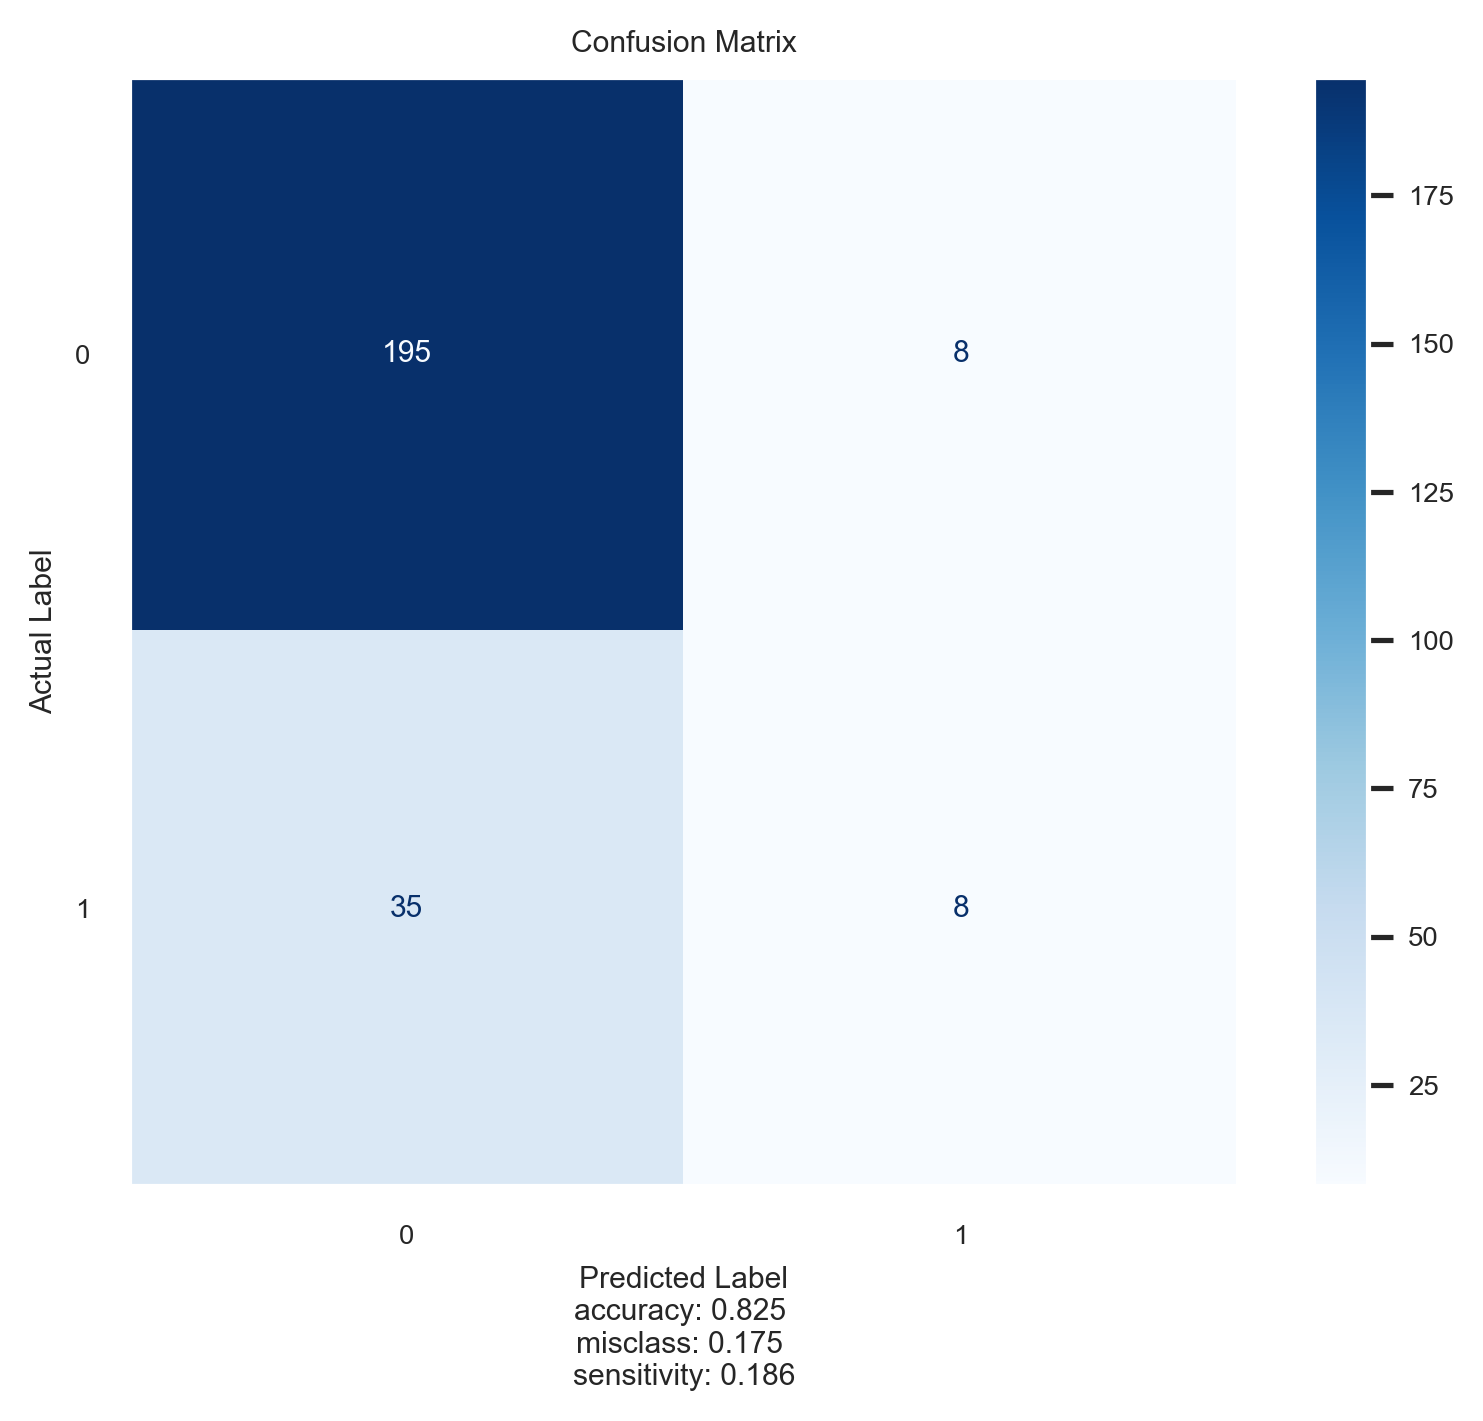

In [51]:
# confusion matrix on test dataset

accuracy = (TN+TP)/ALL
misclass = (FP+FN)/ALL
sensitivity = TP/(TP+FN)

plt.figure(figsize = (5, 3))
sns.set(font_scale = 0.6)

cm = confusion_matrix(
    y_test,
    predictions)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap="Blues", values_format='')

plt.grid(None)

plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label\naccuracy: {:0.3f} \nmisclass: {:0.3f} \nsensitivity: {:0.3f}'.format(accuracy, misclass, sensitivity))

plt.show()

In [52]:
# final accuracy report on ibm dataset

ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
true_positive_rate = sensitivity = recall = power = TP/(TP+FN)
precision = PPV = TP/(TP+FP)
f1_score = 2*(precision*recall)/(precision+recall)

false_positive_rate = false_alarm_ratio = fallout = FP/(FP+TN)
true_negative_rate = specificity = selectivity = TN/(TN+FP)
false_negative_rate = miss_rate = FN/(FN+TP)

support_pos = TP + FN
support_neg = FP + TN

indx_lst = [
        "Accuracy", 
        "True Positive Rate/Sensitivity/Recall/Power", 
        "False Positive Rate/False Alarm Ratio/Fall-out", 
        "True Negative Rate/Specificity/Selectivity", 
        "False Negative Rate/Miss Rate", 
        "Precision/PPV", 
        "F1 Score", 
        "Support (False)", 
        "Support (True)"
        ]

metric = [
        accuracy.round(4),
        true_positive_rate.round(4),
        false_positive_rate.round(4),
        true_negative_rate.round(4),
        false_negative_rate.round(4),
        precision.round(4),
        f1_score.round(4),
        support_neg.round(4),
        support_pos.round(4)
]

performance_report = pd.DataFrame(metric, indx_lst).rename(columns = {0: "Performance"})
performance_report

Performance
Accuracy                                             0.8252
True Positive Rate/Sensitivity/Recall/Power          0.1860
False Positive Rate/False Alarm Ratio/Fall-out       0.0394
True Negative Rate/Specificity/Selectivity           0.9606
False Negative Rate/Miss Rate                        0.8140
Precision/PPV                                        0.5000
F1 Score                                             0.2712
Support (False)                                    203.0000
Support (True)                                      43.0000

----
### **``Analysis Summary & Recommendations``**

After deploying the final logistic regression model on the test dataset, we can conclude that the model is in fact better equipped to predict employee attrition than a baseline model prediction.

Model sensitivity or the *true-positive rate*, which represents all total instances when the model predicted an employee would turn-over or leave the company was ~19% greater than a baseline prediction.

Although model performance was a goal of this analysis, it's important to restate that any model created or used to predict employee turn-over should be handled and interpreted with a high-degree of responsibility and rigor. Since employee turn-over can represent an important decision to both employers and employees, it's also worth noting the many adverse effects that high degree of undue employee turn-over can have at the local and federal levels.

One of the primary objectives of this analysis was to explore a relatively different yet important approach to how organizations interpret, measure, and cultivate the employment life-cycle within their business. 

I believe that by researching and remaining attentive to local socioeconomic data from areas in which a business operates in, employers can help to understand important socioeconomic divides that can have a direct effect on their employees and whether they choose to remain at their company.

More importantly, by studying and leveraging social-mobility information - employers create opportunities to learn and measure how socially equitable and fair their businesses. By auditing current practices and potential cultural norms, employers can examine what, if any of these practices exacerbate unfair or misunderstood working environment, and thus - undue employee attrition.

The following recommendations are based on the informed insights from this analysis and what I believe can help businesses better understand employee attrition and reduce continuity risks.

1. Leverage socioeconomic data/metrics at the local level to understand the communities in which the organization operates in. There are several free resources such as the Opportunity Atlas, America Inequality, and the US Federal Reserve System's Economic FRED platform that provide businesses with on-the-ground data on these metrics, to include social equity topics or ideas for employers to explore and potentially implement. 

2. Use this analysis to explore the casual relationship between employee attrition and the statistically identified county social-mobility metrics and employee recorded data. Employers can reproduce this analysis using their own organizational data. Consider also re-measuring statistical correlation or dependency to employee attrition when specific attrition data such as voluntary or involuntary attrition is included.

3. Leverage and iterate on the top performing machine learning models created through this analysis. Use models not to predict employee attrition, but rather as a measurement of employee sentiment and ways in which employers can help local communities and employees. 

**<u>``Looking Ahead (next steps):``</u>**

- I want to test and measure the potential co-dependencies/collinearity of the social-mobility metrics and how this may impact my analysis.

- To better understand the independent-dependent relationship, I want to test the causal relationship of features to the target variable.

----
``appendix:``


In [53]:
!pip freeze > requirements.txt